# Paper figures

[Figure 3](#figure_3)


In [110]:
import pandas as pd
from collections import defaultdict
import ast
import time
import numpy as np
from scipy import stats
import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import scienceplots
from matplotlib.lines import Line2D

rcParams['font.family'] = 'Arial' # 'sans-serif'
plt.rc('axes', axisbelow=True)

from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score,
    f1_score
)
import sys
import os
import main2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
fontsize_title = 18
fontsize_label = 16
fontsize_legend = 12

config = {
    'fontsize': {
        'half': {
            'title': 18,
            'label': 14,
            'legend': 10
        },
        'full': {
            'title': 36,
            'label': 28,
            'legend': 20,
            'ticks': 16
        }
    },
    'width': 8.27 - 1, # 8.27 inches - 2 * margin
}


In [112]:
def timeit(func):
    """Function timer"""

    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        out = func(*args, **kwargs)
        print(f"> {func.__name__} :: {(time.perf_counter() - start):.3f} sec")
        return out

    return wrapper


In [113]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [114]:
@dataclass
class Fold:
    """
    Each fold holds predictions for all epochs within it.
    We can index into the fold to get the predictions for a specific epoch
    or also get the predictions across a set of folds
    """
    fold: int
    preds: np.ndarray # [n_epochs, samples, 2?]
    labels: np.ndarray # [n_epochs, samples, 2?]
    varids: List[List]

    def __getitem__(self, idx: int):
        # Index into a specific epoch within the fold
        return labels[idx, :], preds[idx, :]

    def __len__(self):
        return self.preds.shape[0]

    def __repr__(self) -> str:
        return f"fold:{self.fold} - {self.preds.shape}"

    def get_best_epoch(self):
        if self.best_epoch:
            return self.best_epoch
        self.cross_entropy_loss = []
        for epoch in range(preds.shape[0]):
            c = cross_entropy(self.preds[epoch], self.labels[epoch])
        self.cross_entropy_loss.append(c)
        self.best_epoch = np.argmin(self.cross_entropy_loss)
        print(self.best_epoch)

In [115]:
class ParquetCache:
    def __init__(self, func):
        self.func = func
        self.cache = {}
        self.last_modified_time = {}

    def __call__(self, *args, **kwargs):
        run = args[0]
        is_svm = kwargs.get('svm', False)

        if is_svm:
            p = f"../Experiments/svm/Log/{run}/output.parquet"
        else:
            p = f"../Log/{run}/output.parquet"
        
        modified_time = os.path.getmtime(p)
        if run in self.last_modified_time.keys() or modified_time != self.last_modified_time[run]:
            self.cache[run] = self.func(*args, **kwargs)
            self.last_modified_time[run] = modified_time
        return self.cache[run]
        


# @ParquetCache
@timeit
def load_run(path: str, svm: bool = False) -> list[Fold]:

    if svm:
        df = pd.read_parquet(f"../Experiments/svm/Log/{path}/output.parquet")
        # df = duckdb.read_parquet(f"../Experiments/svm/Log/{path}/output.parquet")
        # df = df.to_df()
        folds: list[Fold] = main2.create_dataset_svm(df)
    else:
        df = pd.read_parquet(f"../Log/{path}/output.parquet")
        folds: list[Fold] = main2.create_dataset(df)
    return folds


# temp = load_run('mave_50')

(1, 318)
(20, 318)
> load_run_3 :: 0.324 sec
> load_run_3 :: 1.433 sec
go only: pr auc: 0.806829420975876
linear: pr auc: 0.5609635146602254


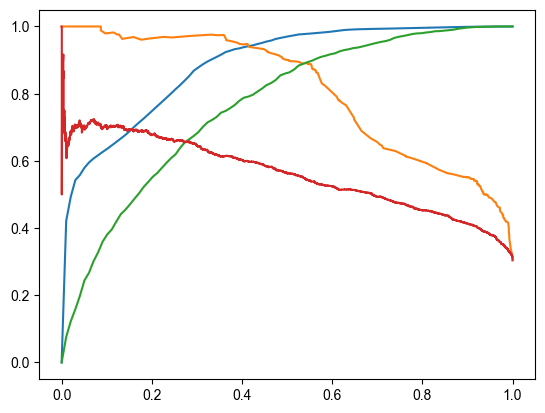

In [116]:
import main3
x = main3.Fold.load_svm('../Experiments/svm/Log/RepeatedKFold/mtl/output.parquet')
print(x[0].labels.shape)

y = main3.Fold.load_nn('../Log/Ablation2/esm_bf_go/output.parquet')
print(y[0].labels.shape)

def compute_roc(folds, name: str = "", ax = None, **kwargs):
    ps = []
    ls = []
    tprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    for fold in folds:
        epoch = fold.get_best_epoch()
        p = fold.preds[epoch]
        l = fold.labels[epoch]
        
        fpr, tpr, threshold = roc_curve(l, p)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        # thresholds.append(threshold)
        # thresholds_best.append(np.argmax(tpr - fpr))
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, 0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plot_kwargs = kwargs.get('plot_kwargs', {})
    label = f"{name} (AUC={mean_auc:.3f}+-{std_auc:.3f})"
    if ax:
        ax.plot(mean_fpr, mean_tpr, label=label, **plot_kwargs)
    return tprs, aucs

def compute_pr(folds, name: str = "", ax = None, **kwargs):
    ps = []
    ls = []
    for fold in folds:
        epoch = fold.get_best_epoch()
        p = fold.preds[epoch]
        l = fold.labels[epoch]
        ps.extend(p)
        ls.extend(l)

    precision, recall, thresholds = precision_recall_curve(ls, ps)
    score = average_precision_score(ls, ps)
    print(f'{name}: pr auc:', score)

    # To make the plot nicer, I interpolate incase there are any precision drops to 0
    # precision = interpolate_zeros(precision)

    ax.plot(recall, precision, label=f"{name} (AUC={score:.3f})", **kwargs)
    return precision, recall, thresholds


runs = {
    'go only': 'go_only', 
    'linear': 'linear',
}

@timeit
def load_run_3(path: str, svm: bool = False) -> list[Fold]:

    if svm:
        folds: list[Fold] = main3.Fold.load_svm(f"../Experiments/svm/Log/{path}/output.parquet")
    else:
        folds: list[Fold] = main3.Fold.load_nn(f"../Log/{path}/output.parquet")
    return folds

for k, v in runs.items():
    runs[k] = load_run_3(v, svm='(svm)' in k)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

fig, ax = plt.subplots(1, 1)
for k, v in runs.items():
    compute_roc(v, k, ax)
    compute_pr(v, k, ax)
plt.show()

In [117]:
def save_fig(
        fig: matplotlib.figure.Figure, 
        fig_name: str, 
        fig_dir: str, 
        fig_fmt: str,
        fig_size: Tuple[float, float] = [6.4, 4], 
        save: bool = True, 
        dpi: int = 300,
        transparent_png = True,
    ):
    """This procedure stores the generated matplotlib figure to the specified 
    directory with the specified name and format.

    Parameters
    ----------
    fig : [type]
        Matplotlib figure instance
    fig_name : str
        File name where the figure is saved
    fig_dir : str
        Path to the directory where the figure is saved
    fig_fmt : str
        Format of the figure, the format should be supported by matplotlib 
        (additional logic only for pdf and png formats)
    fig_size : Tuple[float, float]
        Size of the figure in inches, by default [6.4, 4] 
    save : bool, optional
        If the figure should be saved, by default True. Set it to False if you 
        do not want to override already produced figures.
    dpi : int, optional
        Dots per inch - the density for rasterized format (png), by default 300
    transparent_png : bool, optional
        If the background should be transparent for png, by default True
    """
    if not save:
        return
    
    fig.set_size_inches(fig_size, forward=False)
    fig_fmt = fig_fmt.lower()
    fig_dir = os.path.join(fig_dir, fig_fmt)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    pth = os.path.join(
        fig_dir,
        '{}.{}'.format(fig_name, fig_fmt.lower())
    )
    print(pth)
    if fig_fmt == 'pdf':
        metadata={
            'Creator' : '',
            'Producer': '',
            'CreationDate': None
        }
        fig.savefig(pth, bbox_inches='tight', metadata=metadata)
    elif fig_fmt == 'png':
        alpha = 0 if transparent_png else 1
        axes = fig.get_axes()
        fig.patch.set_alpha(alpha)
        for ax in axes:
            ax.patch.set_alpha(alpha)
        fig.savefig(
            pth, 
            bbox_inches='tight',
            dpi=dpi,
        )
    else:
        try:
            fig.savefig(pth, bbox_inches='tight')
        except Exception as e:
            print("Cannot save figure: {}".format(e)) 

# Random run visualisations

    Show performance of some random runs

> load_run :: 1.348 sec
> load_run :: 0.287 sec


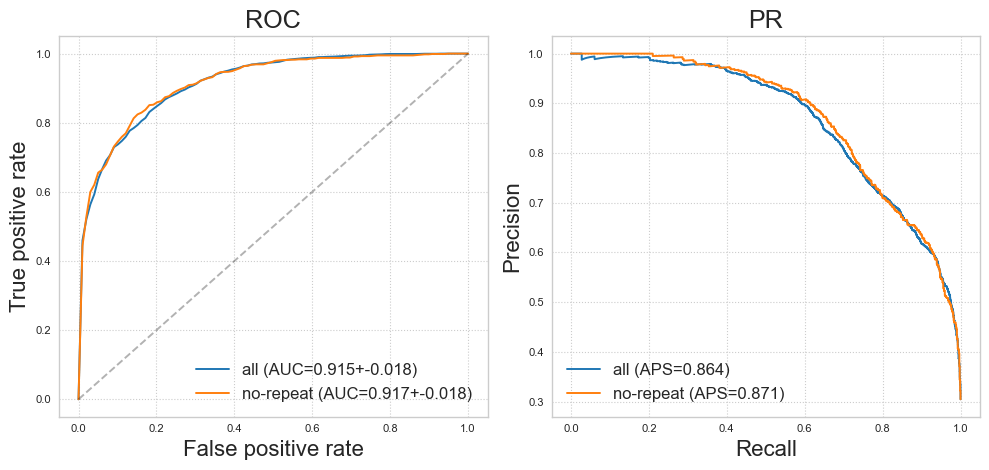

In [299]:
runs = {
    # 'esm bf go': 'esm_mtl_go',
    # '(svm)mtl': 'mtl',
    # '(svm)mkl': 'mkl',
    'ours_with_hpo': 'esm_bf_hpo_go_all',
    'ours_mkl': 'esm100_bf_hpo_go_hposet',
    'test': 'test',
    'dev': 'dev',
    'dev2': 'dev2',
    'dev3': 'dev3',
    'esm': 'Ablation/esm',
    # 'BF': 'bf_go',
    # 'esm_go': 'esm_go',
    # 'esm200': 'esm200_bf_go',
    # 'no_center': 'no_center',
    # '3B': 'esm_variants/esm3000_go',
    # '650M': 'esm_variants/esm650_go',
    # '150M': 'esm_variants/esm150_go',
    # '35M': 'esm_variants/esm35_go',
    # '8M': 'esm_variants/esm8_go',
    # 'MSAT': 'esm_variants/msa_go',
    # 'esm': 'esm200_bf_go',
    # 'ours2': 'esm100_bf_go',
    # 'mave': 'mave',
    # 'focal_loss': 'focal_loss',
}

runs = {
    '(svm)mtl': 'mtl',
    # '(svm)mkl': 'mkl',
    # 'esm': 'Ablation2/esm',
    # 'esm bf': 'Ablation2/esm_bf',
    # 'esm bf go': 'Ablation2/esm_bf_go',
    # 'esm bf go fl mwt ': 'RepeatedKFold/esm_bf_go_fl_mwt',
    # 'Gene name': 'gene_name',
    # 'esm bf': 'Ablation2/esm_bf',
    # 'esm bf go hpo': 'Ablation2/esm_bf_go_hpo',
    # 'esm bf go hpo (subset)': 'Ablation2/esm_bf_go_hpo_hposet',
    # 'esm go': 'Ablation2/esm_go2',
    # 'esm bf go 2': 'Ablation2/esm_bf_go_2',
    # 'dev': 'dev',
    # 'dev2': 'dev2',
    # 'norm': 'normalised_across_all',
    # 'domain': 'domain_generalisation',
    # 'half': 'half_generalisation',
    # 'norm': 'Ablation2/esm_minus_wt',
    # 'norm go': 'Ablation2/esm_norm_go',
    'norm bf': 'Ablation2/esm_minus_wt_bf',
    # '(svm)dt': 'decisiontree'
    # 'norm bf go': 'Ablation2/esm_minus_wt_bf_go',
    # 'attn bf': 'Ablation2/attn_bf_fl_mwt',
    # 'attn bf go': 'Ablation2/attn_bf_go_fl_mwt',
    # 'esm bf go fl mwt': 'RepeatedKFold/esm_bf_go_fl_mwt',
    # 'esm bf go fl mwt attn': 'RepeatedKFold/esm_bf_go_fl_mwt_attn',
    # 'esm bf go hpo fl mwt': 'RepeatedKFold/esm_bf_go_hpo_fl_mwt',
    # 'norm go': 'Ablation2/esm_norm_go',
    # 'norm bf hpo': 'Ablation2/esm_minus_wt_bf_hpo',
    # 'test': 'test',
    # 'esm norm bf go fl': 'RepeatedKFold_norm/esm_bf_go_fl',
    'ESM': 'RepeatedKFold/esm',
    'ESM BF': 'RepeatedKFold/esm_bf',
    'ESM GO': 'RepeatedKFold/esm_go',
    'ESM BF GO': 'RepeatedKFold/esm_bf_go_fl',
    # 'gene name norm': 'gene_name_norm',
    # 'gene name no-norm': 'gene_name_no_norm',
    # 'esm bf fl mwt attn': 'RepeatedKFold/esm_attn_bf_fl_mwt',
    # 'esm layer norm': 'esm_layer_norm_bf',
    # 'subsampled': 'subsample_balanced',
    # 'attn mask': 'RepeatedKFold/esm_attn_with_mask_bf_go_fl',
    # 'attn mask mwt': 'RepeatedKFold/esm_attn_with_mask_bf_go_mwt_fl',
    # 'attn mask esm only': 'RepeatedKFold/esm_attn_mask_mwt_fl',
    'test': 'test',
}

runs = {
    '(svm)mtl': 'mtl',
    # 'ESM': 'RepeatedKFold/esm',
    # 'ESM BF': 'RepeatedKFold/esm_bf',
    # 'ESM GO': 'RepeatedKFold/esm_go',
    'ESM BF GO': 'RepeatedKFold/esm_bf_go_fl', 
    # 'prott5': 'prott5',
    'test': 'test',
    'norm': 'Ablation2/esm_minus_wt',
    'linear': 'linear',
    'go_only': 'go_only',
}

runs = {
    # 'go_only': 'go_only',
    # 'linear + go': 'linear_go',
    # 'non linear + go': 'non_linear_go',
    'ESM': 'RepeatedKFold/esm',
    'ESM GO': 'RepeatedKFold/esm_go',
    # 'esm go': 'Ablation2/esm_go2',
    # # 'ESM': 'RepeatedKFold/esm',
    # # 'msa esm go': 'msa_esm_go',
    # 'normed': 'esm_normed_all',
    # 'Gene name': 'gene_name',
    'linear': 'linear',
    'non-linear': 'non_linear',
    # 'esm go': 'Ablation2/esm_go2',
    'gene name mlp': 'genes_name_final',
    '(svm)mtl': "RepeatedKFold/mtl",
}

runs = {
    # 'SCN': 'gene2gene/scn2a_from_scn2',
    # 'KCN': 'gene2gene/scn2a_from_kcn2',
    # 'CACNA': 'gene2gene/scn2a_from_cacn2',
    'reference': 'RepeatedKFold/esm',
    'domain': 'domain_generalisation2',
    'half': 'half_generalisation2',
    'half reverse': 'half_generalisation2_rev',
}

# runs = {
#     # '8M': 'esm_8m',
#     # '8M norm': 'esm_8m_norm',
#     # '12M': 'esm_12m_norm',
#     # '150M': 'esm_150m_norm',
#     # '650M': 'esm_650m',
#     # '650M norm': 'esm_650m_norm',
#     '3B': 'Ablation2/esm_go2',
#     # 'test': 'test',
#     'prott5': 'prott5',
# }

# runs = {
#     '(svm)mtl': 'RepeatedKFold/mtl',
#     # '(svm)mtl_no_sim': 'mtl_no_sim',
#     # 'ESM': 'RepeatedKFold/esm',
#     # 'ESM GO': 'RepeatedKFold/esm_go',
#     'ESM BF GO': 'RepeatedKFold/esm_bf_go_fl',
#     # 'ESM BF GO HPO': 'RepeatedKFold/esm_bf_go_hpo_fl',
#     # 'sh go': 'sh_go',
#     # 'attn': 'attn_with_mask_bf_go',
#     'attn repeat': 'RepeatedKFold/esm_attn_with_mask_bf_go_fl',
#     'GO': 'go_only',
# }

# runs = {
#     # 'hpo+parents': 'hpo_plus_parents',
#     # 'hpo': 'hpo_no_parents'
#     'ce': 'loss_functions/ce',
#     'ce_class_weight': 'loss_functions/ce_classweight',
#     'focal': 'loss_functions/focalloss',
# }

runs = {
    # 'SCN*->SCN5A': 'SCN5A_FROM_SCN',
    # 'ALL->SCN5A': "SCN5A_FROM_ALL",
    'KCN->KCNA2': 'KCNA2_FROM_KCN',
    'ALL->KCNA2': 'KCNA2_FROM_ALL',
}

runs = {
    'all': 'RepeatedKFold/esm_bf_go_fl',
    'no-repeat': 'Ablation2/esm_bf_go',
}


for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

with plt.style.context(['seaborn-v0_8-paper']):
    figsize=(10,4.8)
    fig, ax = plt.subplots(1, 2, figsize=figsize, tight_layout=True) # (8, 6)

    ax2 = ax[1]
    ax = ax[0]
    
    for k, v in runs.items():
        if '(svm)' in k:
            aucs = main2.compute_roc(v, ax, k, [0])
            main2.compute_pr(v, ax2, k, [0])
        else:
            be = [i.get_best_epoch() for i in v]
            be = [13] * len(v)
            aucs = main2.compute_roc2(v, ax, k, be, include_label=True)
            aucs1 = compute_pr_old(v, ax2, k, be)#, linewidth=1.5)
            # compute_pr(v, k, ax2)
            thresholds = aucs1[2]
            # ts, tsb = aucs[1], aucs[2]
            # for i in range(10):
            #     x = ts[i][tsb[i]]
            #     print(x)
    
    # Random line
    ax.plot(
        np.linspace(0, 1, 10),
        np.linspace(0, 1, 10),
        color="k",
        alpha=0.3,
        linestyle="--",
    )
    
    ax.set_title("ROC", fontsize=fontsize_title)
    # ax.set_title('Generalisation between regions within gene\'s', fontsize=18)
    # ax.set_title('Predicting SCN2A from various gene families', fontsize=18)
    ax.set_ylabel("True positive rate", fontsize=fontsize_label)
    ax.set_xlabel("False positive rate", fontsize=fontsize_label)
    
    ax.legend(fontsize=fontsize_legend)
    ax.grid(linestyle='dotted')
        
    # plt.savefig('./test_save_figure.pdf', bbox_inches='tight')
    # save_fig(fig, 'scn2a_from_others', fig_dir='.', fig_fmt='pdf', fig_size=(6.4, 4.8))

    ax2.grid(linestyle='dotted')
    ax2.legend(fontsize=fontsize_legend)
    ax2.set_xlabel("Recall", fontsize=fontsize_label)
    ax2.set_ylabel("Precision", fontsize=fontsize_label)
    ax2.set_title('PR', fontsize=18)

# plt.xlim([0, 0.6])
# plt.ylim([0.4, 1.05])
# plt.ylim([0.5, 1.05])

# ax2.set_ylim([0.2, 1.05])

# plt.style.available
plt.show()

LOF: No threshold achieves 90% precision
GOF: 90% precision at threshold = 0.660, precision = 0.900


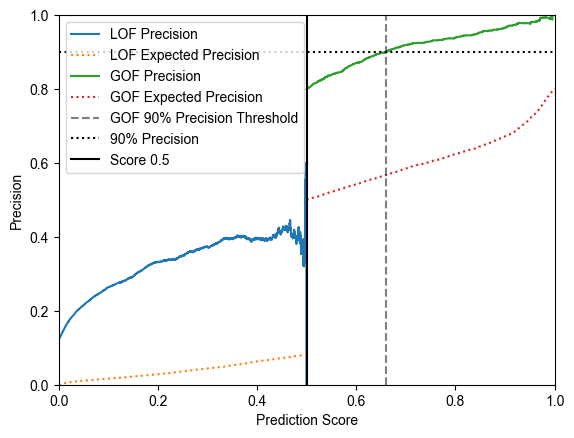

Number of ambiguous variants: 7623


In [272]:
# def compute_precision_recall(ax, class_, runs, label):
def compute_precision_recall(ax, class_, runs, score_range, label):
    preds = []
    labels = []
    
    for fold in runs['all']:
        be = fold.get_best_epoch()
        p = fold.preds[be]  # Shape: (n_samples, 2), e.g., [[0.6, 0.4], ...]
        l = fold.labels[be]  

        p2 = []
        l2 = []
        for i in range(len(p)):
            p_t = p[i]
            if p_t[0] >= 0.5:
                p2.append(1-p_t[0])
                l2.append(0)
            else:
                p2.append(p_t[1])
                l2.append(1)
        p = np.array(p2)
        # l = np.array(l2)
        l = np.argmax(l, 1)
        
        if class_ == 0:  # Benign (class 0, scores in [0, 0.5])
            p2 = np.where((p >= 0) & (p <= 0.5))[0]  # Filter scores in [0, 0.5]
            p = p[p2]  # Benign class probabilities
            l = l[p2]  # Benign class labels (1 if benign, 0 if not)
        else:  # Pathogenic (class 1, scores in [0.5, 1])
            p2 = np.where((p >= 0.5) & (p<= 1))[0]  # Filter scores in [0.5, 1]
            p = p[p2]  # Pathogenic class probabilities
            l = l[p2]  # Pathogenic class labels (1 if pathogenic, 0 if not)
        
        preds.append(p)
        labels.append(l)
    
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    
    # Compute precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(labels, preds)
    
    # Plot precision vs. thresholds
    ax.plot(thresholds, precisions[:-1], label=f'{label} Precision')
    
    # Compute expected precision (average predicted probability)
    # Sort predictions and compute cumulative mean
    sorted_idx = np.argsort(preds)
    sorted_preds = preds[sorted_idx]
    expected_precision = np.cumsum(sorted_preds) / np.arange(1, len(sorted_preds) + 1)
    ax.plot(thresholds, expected_precision[:len(thresholds)], linestyle=':', label=f'{label} Expected Precision')
    
    # Find threshold for 90% precision
    idx = np.where(precisions[:-1] >= 0.9)[0]
    if len(idx) > 0:
        threshold_90 = thresholds[idx[0]]  # First threshold where precision >= 0.9
        precision_90 = precisions[idx[0]]
        ax.axvline(threshold_90, linestyle='--', color='k', alpha=0.5, label=f'{label} 90% Precision Threshold')
        print(f'{label}: 90% precision at threshold = {threshold_90:.3f}, precision = {precision_90:.3f}')
    else:
        print(f'{label}: No threshold achieves 90% precision')
    
    return thresholds, precisions[:-1]

# Create plot
fig, ax = plt.subplots()
thresholds_benign, precisions_benign = compute_precision_recall(ax, 0, runs, [0, 0.5], 'LOF')
thresholds_pathogenic, precisions_pathogenic = compute_precision_recall(ax, 1, runs, [0.5, 1], 'GOF')

# Add reference lines
ax.axhline(0.9, linestyle=':', color='k', label='90% Precision')
ax.axvline(0.5, linestyle='-', color='k', label='Score 0.5')

# Set labels and legend
ax.set_ylabel('Precision')
ax.set_xlabel('Prediction Score')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.legend()
plt.show()

# Identify ambiguous variants (example logic)
# Assuming you have all predictions and labels concatenated
all_preds = []
all_labels = []
for fold in runs['all']:
    be = fold.get_best_epoch()
    all_preds.append(fold.preds[be])
    all_labels.append(fold.labels[be])
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Example: Find thresholds for 90% precision (you'll need to adjust based on output)
benign_threshold = thresholds_benign[np.where(precisions_benign >= 0.9)[0][0]] if np.any(precisions_benign >= 0.9) else None
pathogenic_threshold = thresholds_pathogenic[np.where(precisions_pathogenic >= 0.9)[0][0]] if np.any(precisions_pathogenic >= 0.9) else None

ambiguous_idx = []
for i, (p_benign, p_pathogenic) in enumerate(all_preds):
    if benign_threshold and p_pathogenic <= 0.5 and p_benign > benign_threshold:
        continue  # Benign with 90% precision
    if pathogenic_threshold and p_pathogenic > 0.5 and p_pathogenic > pathogenic_threshold:
        continue  # Pathogenic with 90% precision
    ambiguous_idx.append(i)

print(f'Number of ambiguous variants: {len(ambiguous_idx)}')

In [290]:
from sklearn.metrics import precision_score, recall_score

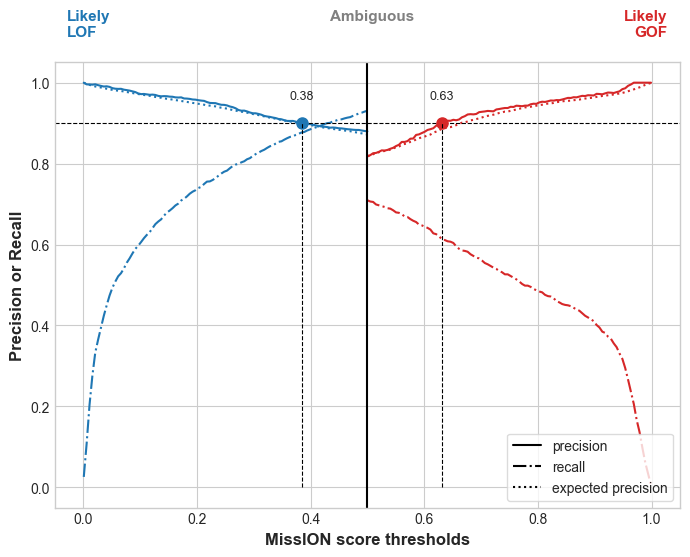

Threshold for 90% benign precision: ~0.384
Threshold for 90% pathogenic precision: ~0.631


In [301]:


preds = []
labels = []
for fold in runs['no-repeat']:
    be = fold.get_best_epoch()
    p = fold.preds[be, :, 1]
    l = fold.labels[be, :, 1]

    preds.extend(p)
    labels.extend(l)

preds = np.array(preds)
labels = np.array(labels)

y_scores = preds
y_true = labels

n_samples = y_scores.shape[0]

# ====================== Mock Data ====================================

# # --- 0. Generate Mock Data ---
# # Let's assume 0 = benign, 1 = pathogenic
# # We need true labels (y_true) and predicted scores (y_scores)
# np.random.seed(42)
# n_samples = 5000

# # Simulate true labels (e.g., from ClinVar)
# # Let's say 70% are benign, 30% are pathogenic in our mock dataset
# n_pathogenic = int(0.3 * n_samples)
# n_benign = n_samples - n_pathogenic
# y_true = np.concatenate([np.zeros(n_benign), np.ones(n_pathogenic)])

# # Simulate AlphaMissense-like scores
# # Benign variants should generally have lower scores
# # Pathogenic variants should generally have higher scores
# # Add some noise/overlap to make it realistic
# scores_benign = np.random.beta(a=2, b=5, size=n_benign) * 0.8  # Skewed towards low values
# scores_pathogenic = np.random.beta(a=5, b=2, size=n_pathogenic) * 0.8 + 0.2 # Skewed towards high values
# scores_pathogenic = np.clip(scores_pathogenic, 0, 1) # Ensure scores are within [0,1]

# y_scores = np.concatenate([scores_benign, scores_pathogenic])
# ============================================================

# Shuffle the data
shuffle_indices = np.random.permutation(n_samples)
y_true = y_true[shuffle_indices]
y_scores = y_scores[shuffle_indices]

# --- 1. Calculate Precision, Recall for Benign Class ---
# (AlphaMissense scores 0 to 0.5)
# Here, "positive" means predicted as benign. True positive for this part means correctly identified benign.
thresholds_benign_range = np.linspace(0.001, 0.5, 100) # AlphaMissense score thresholds
precision_benign_list = []
recall_benign_list = []
expected_precision_benign_list = []

for t_b in thresholds_benign_range:
    # Prediction: score <= t_b is predicted benign (1 for this calculation context)
    # score > t_b is predicted pathogenic (0 for this calculation context)
    y_pred_for_benign_eval = (y_scores <= t_b).astype(int)
    
    # We are evaluating the "benign" class.
    # So, true labels for this context are (y_true == 0)
    true_labels_for_benign_eval = (y_true == 0).astype(int)
    
    p = precision_score(true_labels_for_benign_eval, y_pred_for_benign_eval, pos_label=1, zero_division=0)
    r = recall_score(true_labels_for_benign_eval, y_pred_for_benign_eval, pos_label=1, zero_division=0)
    
    precision_benign_list.append(p)
    recall_benign_list.append(r)
    
    # Expected precision: average (1 - score) for those predicted benign
    predicted_benign_scores = y_scores[y_scores <= t_b]
    if len(predicted_benign_scores) > 0:
        expected_p = np.mean(1 - predicted_benign_scores)
    else:
        expected_p = 0 # Or np.nan, but 0 might be better for plotting start
    expected_precision_benign_list.append(expected_p)

# --- 2. Calculate Precision, Recall for Pathogenic Class ---
# (AlphaMissense scores 0.5 to 1)
# Here, "positive" means predicted as pathogenic. True positive means correctly identified pathogenic.
thresholds_pathogenic_range = np.linspace(0.5, 0.999, 100) # AlphaMissense score thresholds
precision_pathogenic_list = []
recall_pathogenic_list = []
expected_precision_pathogenic_list = []

for t_p in thresholds_pathogenic_range:
    # Prediction: score >= t_p is predicted pathogenic (1 for this calculation context)
    # score < t_p is predicted benign (0 for this calculation context)
    y_pred_for_pathogenic_eval = (y_scores >= t_p).astype(int)
    
    # We are evaluating the "pathogenic" class.
    # True labels for this context are (y_true == 1)
    true_labels_for_pathogenic_eval = (y_true == 1).astype(int)
    
    p = precision_score(true_labels_for_pathogenic_eval, y_pred_for_pathogenic_eval, pos_label=1, zero_division=0)
    r = recall_score(true_labels_for_pathogenic_eval, y_pred_for_pathogenic_eval, pos_label=1, zero_division=0)
    
    precision_pathogenic_list.append(p)
    recall_pathogenic_list.append(r)

    # Expected precision: average (score) for those predicted pathogenic
    predicted_pathogenic_scores = y_scores[y_scores >= t_p]
    if len(predicted_pathogenic_scores) > 0:
        expected_p = np.mean(predicted_pathogenic_scores)
    else:
        expected_p = 0 # Or np.nan
    expected_precision_pathogenic_list.append(expected_p)

# --- 3. Find 90% Precision Thresholds ---
target_precision = 0.90

# For benign
idx_benign_90_prec = np.where(np.array(precision_benign_list) >= target_precision)[0]
thresh_benign_90 = thresholds_benign_range[idx_benign_90_prec[-1]] if len(idx_benign_90_prec) > 0 else thresholds_benign_range[-1] # take the highest threshold
prec_at_thresh_benign_90 = precision_benign_list[idx_benign_90_prec[-1]] if len(idx_benign_90_prec) > 0 else precision_benign_list[-1]

# For pathogenic
idx_pathogenic_90_prec = np.where(np.array(precision_pathogenic_list) >= target_precision)[0]
thresh_pathogenic_90 = thresholds_pathogenic_range[idx_pathogenic_90_prec[0]] if len(idx_pathogenic_90_prec) > 0 else thresholds_pathogenic_range[0] # take the lowest threshold
prec_at_thresh_pathogenic_90 = precision_pathogenic_list[idx_pathogenic_90_prec[0]] if len(idx_pathogenic_90_prec) > 0 else precision_pathogenic_list[0]


# --- 4. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for nicer plots
fig, ax = plt.subplots(figsize=(7, 6))

# Benign curves (blue)
ax.plot(thresholds_benign_range, precision_benign_list, color='tab:blue', linestyle='-', label='precision (LOF)')
ax.plot(thresholds_benign_range, recall_benign_list, color='tab:blue', linestyle='-.', label='recall (LOF)')
ax.plot(thresholds_benign_range, expected_precision_benign_list, color='tab:blue', linestyle=':', label='expected precision (LOF)')

# Pathogenic curves (red)
ax.plot(thresholds_pathogenic_range, precision_pathogenic_list, color='tab:red', linestyle='-', label='precision (GOF)')
ax.plot(thresholds_pathogenic_range, recall_pathogenic_list, color='tab:red', linestyle='-.', label='recall (GOF)')
ax.plot(thresholds_pathogenic_range, expected_precision_pathogenic_list, color='tab:red', linestyle=':', label='expected precision (GOF)')

# Target precision line
ax.axhline(target_precision, color='black', linestyle='--', linewidth=0.8)

# Highlight points and vertical lines for 90% precision thresholds
# Benign threshold
ax.plot(thresh_benign_90, prec_at_thresh_benign_90, 'o', color='tab:blue', markersize=8)
ax.vlines(thresh_benign_90, 0, prec_at_thresh_benign_90, color='black', linestyle='--', linewidth=0.8)
ax.text(thresh_benign_90, prec_at_thresh_benign_90 + 0.05, f'{thresh_benign_90:.2f}', ha='center', va='bottom', fontsize=9)

# Pathogenic threshold
ax.plot(thresh_pathogenic_90, prec_at_thresh_pathogenic_90, 'o', color='tab:red', markersize=8)
ax.vlines(thresh_pathogenic_90, 0, prec_at_thresh_pathogenic_90, color='black', linestyle='--', linewidth=0.8)
ax.text(thresh_pathogenic_90, prec_at_thresh_pathogenic_90 + 0.05, f'{thresh_pathogenic_90:.2f}', ha='center', va='bottom', fontsize=9)


# Custom legend to match the original paper's style (simplified)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=1.5, linestyle='-', label='precision'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='-.', label='recall'),
    Line2D([0], [0], color='black', lw=1.5, linestyle=':', label='expected precision')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, edgecolor='lightgray')


# Labels and Title
ax.set_xlabel("MissION score thresholds", fontsize=12, fontweight='bold')
ax.set_ylabel("Precision or Recall", fontsize=12, fontweight='bold')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

# Category labels on top
ax.text(0.02, 1.12, "Likely\nLOF", color='tab:blue', transform=ax.transAxes, ha='left', va='top', fontsize=11, fontweight='bold')
ax.text( (thresh_benign_90 + thresh_pathogenic_90) / 2 , 1.12, "Ambiguous", color='gray', transform=ax.transAxes, ha='center', va='top', fontsize=11, fontweight='bold')
ax.text(0.98, 1.12, "Likely\nGOF", color='tab:red', transform=ax.transAxes, ha='right', va='top', fontsize=11, fontweight='bold')

# Main title "A"
# ax.text(-0.1, 1.15, "A", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top')

ax.axvline(0.5, color='k')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for top text

save_fig(

plt.show()

print(f"Threshold for 90% benign precision: ~{thresh_benign_90:.3f}")
print(f"Threshold for 90% pathogenic precision: ~{thresh_pathogenic_90:.3f}")



LOF: 90% precision at threshold = 0.601, precision = 0.900
GOF: 90% precision at threshold = 0.660, precision = 0.900


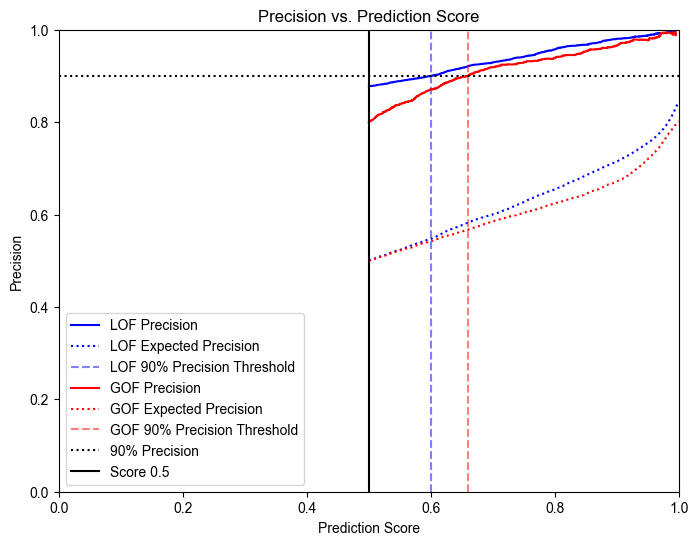

Number of ambiguous variants: 1187


In [253]:
def compute_precision_recall(ax, class_, runs, label):
    preds = []
    labels = []
    
    for fold in runs['all']:
        be = fold.get_best_epoch()
        p = fold.preds[be]  # Shape: (n_samples, 2), e.g., [[0.6, 0.4], ...]
        l = fold.labels[be]  # Shape: (n_samples, 2), e.g., [[1, 0], [0, 1], ...]
        
        if class_ == 0:  # Benign: model predicts benign (p_benign > 0.5)
            p2 = np.where(p[:, 0] > 0.5)[0]  # p_benign > 0.5 means predicted benign
            p = p[p2, 0]  # Benign probabilities
            l = l[p2, 0]  # Benign labels (1 if benign, 0 if not)
        else:  # Pathogenic: model predicts pathogenic (p_pathogenic > 0.5)
            p2 = np.where(p[:, 1] > 0.5)[0]  # p_pathogenic > 0.5 means predicted pathogenic
            p = p[p2, 1]  # Pathogenic probabilities
            l = l[p2, 1]  # Pathogenic labels (1 if pathogenic, 0 if not)
        
        preds.append(p)
        labels.append(l)
    
    preds = np.concatenate(preds) if preds else np.array([])
    labels = np.concatenate(labels) if labels else np.array([])
    
    if len(preds) == 0:
        print(f'{label}: No predictions for this class')
        return None, None, None
    
    # Compute precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(labels, preds)
    
    # Plot precision vs. thresholds
    ax.plot(thresholds, precisions[:-1], label=f'{label} Precision', color='blue' if class_ == 0 else 'red')
    
    # Compute expected precision (average predicted probability)
    sorted_idx = np.argsort(preds)
    sorted_preds = preds[sorted_idx]
    expected_precision = np.cumsum(sorted_preds) / np.arange(1, len(sorted_preds) + 1)
    ax.plot(thresholds, expected_precision[:len(thresholds)], linestyle=':', color='blue' if class_ == 0 else 'red', 
            label=f'{label} Expected Precision')
    
    # Find threshold for 90% precision
    idx = np.where(precisions[:-1] >= 0.9)[0]
    threshold_90 = None
    if len(idx) > 0:
        threshold_90 = thresholds[idx[0]]  # First threshold where precision >= 0.9
        precision_90 = precisions[idx[0]]
        ax.axvline(threshold_90, linestyle='--', color='blue' if class_ == 0 else 'red', alpha=0.5, 
                   label=f'{label} 90% Precision Threshold')
        print(f'{label}: 90% precision at threshold = {threshold_90:.3f}, precision = {precision_90:.3f}')
    else:
        print(f'{label}: No threshold achieves 90% precision')
    
    return thresholds, precisions[:-1], threshold_90

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))
benign_data = compute_precision_recall(ax, 0, runs, 'LOF')
pathogenic_data = compute_precision_recall(ax, 1, runs, 'GOF')

# Add reference lines
ax.axhline(0.9, linestyle=':', color='k', label='90% Precision')
ax.axvline(0.5, linestyle='-', color='k', label='Score 0.5')

# Set labels and legend
ax.set_ylabel('Precision')
ax.set_xlabel('Prediction Score')
ax.set_xlim(0.0, 1)
ax.set_ylim(0, 1)
ax.legend()
plt.title('Precision vs. Prediction Score')
plt.show()

# Identify ambiguous variants
all_preds = np.concatenate([fold.preds[fold.get_best_epoch()] for fold in runs['all']], axis=0)
all_labels = np.concatenate([fold.labels[fold.get_best_epoch()] for fold in runs['all']], axis=0)

benign_threshold = benign_data[2] if benign_data[2] is not None else -np.inf
pathogenic_threshold = pathogenic_data[2] if pathogenic_data[2] is not None else -np.inf

ambiguous_idx = []
for i, (p_benign, p_pathogenic) in enumerate(all_preds):
    is_benign = p_benign > 0.5 and p_benign >= benign_threshold  # Predicted benign with high confidence
    is_pathogenic = p_pathogenic > 0.5 and p_pathogenic >= pathogenic_threshold  # Predicted pathogenic with high confidence
    if not (is_benign or is_pathogenic):
        ambiguous_idx.append(i)

print(f'Number of ambiguous variants: {len(ambiguous_idx)}')

In [62]:
runs1 = {
    'SCN': 'gene2gene/scn2a_from_scn2',
    'KCN': 'gene2gene/scn2a_from_kcn2',
    'CACNA': 'gene2gene/scn2a_from_cacn2',
}
runs2 = {
    'reference': 'RepeatedKFold/esm',
    'domain': 'domain_generalisation2',
    'half': 'half_generalisation2',
    'half reverse': 'half_generalisation2_rev',
}

for runs in [runs1, runs2]:
    for k, v in runs.items():
        if '(svm)' in k:
            runs[k] = load_run(v, svm=True)
        else:
            runs[k] = load_run(v)
    for k, v in runs.items():
        for e in range(len(v)):
            v[e].get_best_epoch()



> load_run :: 0.211 sec
> load_run :: 0.248 sec
> load_run :: 0.201 sec
> load_run :: 1.528 sec
> load_run :: 1.055 sec
> load_run :: 1.373 sec
> load_run :: 1.644 sec


ValueError: multilabel-indicator format is not supported

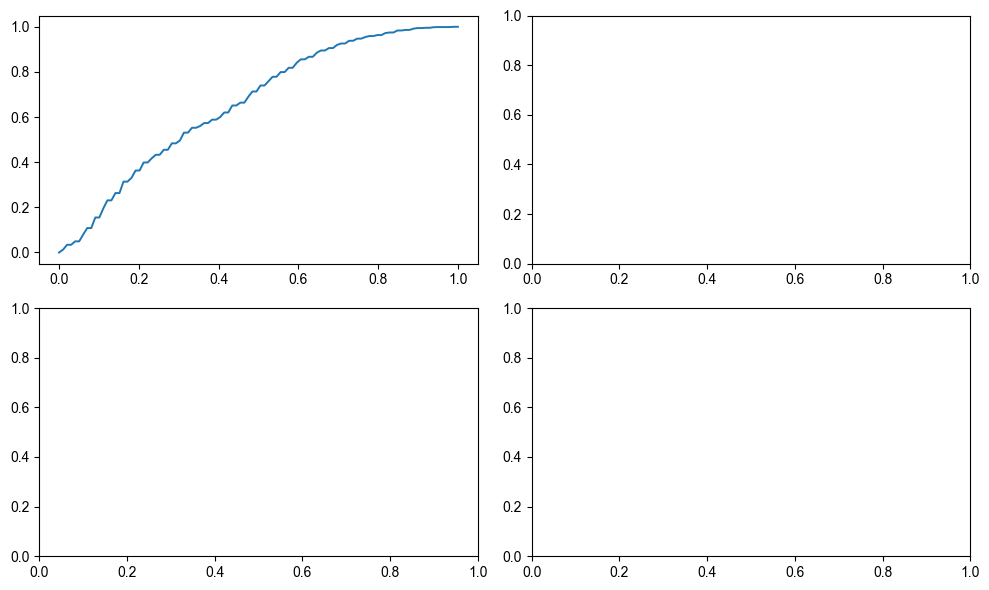

In [66]:

def f(folds, name: str):
    ba = []
    mcc = []
    f1_w = []
    f1_m = []
    for fold in folds:
        be = fold.get_best_epoch()
        preds = fold.preds[be]
        labels = fold.labels[be]
        p = np.argmax(preds, 1)
        l = np.argmax(labels, 1)
        s = balanced_accuracy_score(l, p)
        ba.append(s)
        s = matthews_corrcoef(l, p)
        mcc.append(s)
        s = f1_score(l, p, labels=[0, 1], average='weighted', zero_division=np.nan)
        f1_w.append(s)
        s = f1_score(l, p, labels=[0, 1], average='macro', zero_division=np.nan)
        f1_m.append(s)
    print(f"{name}, {np.mean(ba):.4f}, {np.mean(mcc):.4f}, {np.mean(f1_w):.4f}, {np.mean(f1_m):.4f}")

fig, axes = plt.subplots(2, 2, figsize=(10,6), tight_layout=True) # (8, 6)
ax = axes[0]

with plt.style.context(['seaborn-v0_8-paper']):
    
    
    for k, v in runs1.items():
        be = [i.get_best_epoch() for i in v]
        aucs = main2.compute_roc2(v, ax[0], k, be, include_label=True)
        aucs1 = compute_pr(v, ax[1], k)#, linewidth=1.5)
        f(v, k)
        
    ax[0].plot(
            np.linspace(0, 1, 10),
            np.linspace(0, 1, 10),
            color="k",
            alpha=0.3,
            linestyle="--",
        )

########### BOTTOM row 
ax = axes[1]
for k, v in runs2.items():
    be = [i.get_best_epoch() for i in v]
    aucs = main2.compute_roc2(v, ax[0], k, be, include_label=True)
    aucs1 = compute_pr(v, ax[1], k)#, linewidth=1.5)
    f(v, k)

    ax[0].plot(
            np.linspace(0, 1, 10),
            np.linspace(0, 1, 10),
            color="k",
            alpha=0.3,
            linestyle="--",
        )
    
    # plt.title('Predicting SCN2A from various gene families', fontsize=18)
    # plt.title('Generalisation between regions within gene\'s', fontsize=18)
    # plt.xlabel('False Positive Rate', fontsize=14)
    # plt.ylabel('True Positive Rate', fontsize=14)
    # plt.grid(linestyle='dashed', alpha=0.3)
    # plt.legend(fontsize=fontsize_legend)

for ax in axes.flatten():
    ax.grid(linestyle='dashed', alpha=0.3)
    ax.legend(fontsize=fontsize_legend-2)

plt.suptitle('Generalisation between regions within gene\'s', fontsize=18)
# axes[1, 0].suptitle('Predicting SCN2A from various gene families', fontsize=18)

    # save_fig(fig, 'scn2a_from_various', fig_dir='.', fig_fmt='pdf', fig_size=(6.4, 4.8))

In [1065]:
AVERAGE='weighted'

def compute_metric_svm(folds: List[Fold], metric='f1'):
    scores = []
    genes = []
    for fold_idx, fold in enumerate(folds):
        genes.append(fold.varids[0].split('_')[0])
        be = 0
        p = fold.preds[be]
        l = fold.labels[be]
        p = (p > 0).astype(int)
        if metric == 'f1':
            score = f1_score(l, p, average=AVERAGE, labels=[0, 1], pos_label=1, zero_division=np.nan)
        elif metric == 'ba':
            score = accuracy_score(l, p)
        else: 
            raise Exception('unsupported metric')
        scores.append(score)
    return scores, genes
    
def compute_metric(folds: List[Fold], metric='f1'):
    scores = []
    genes = []
    for fold_idx, fold in enumerate(folds):
        genes.append(fold.varids[0][0].split('_')[0])
        be = fold.get_best_epoch()
        preds = fold.preds[be]
        labels = fold.labels[be]
        l = np.argmax(labels, 1)
        p = np.argmax(preds, 1)
        if metric == 'f1':
            score = f1_score(l, p, average=AVERAGE, labels=[0, 1], pos_label=1, zero_division=np.nan)
        elif metric == 'ba':
            score = accuracy_score(l, p)
        else: 
            raise Exception('unsupported metric')
        scores.append(score)
    return scores, genes

s1 = compute_metric_svm(runs['(svm)mtl'], 'f1')[0]
s2 = compute_metric(runs['ESM BF GO'], 'f1')[0]
print(stats.ks_2samp(s1, s2, alternative='two-sided'))
print(stats.ranksums(s1, s2, alternative='two-sided'))

KstestResult(statistic=0.6333333333333333, pvalue=0.0029060572229452682, statistic_location=0.8391907702788761, statistic_sign=1)
RanksumsResult(statistic=-2.5612496949731396, pvalue=0.010429636628155808)


# Figure 3
<a id='figure_3'></a>

## Primary results figure

### A)

    Performance comparison plots for our model vs bosselman

    A.1 : All variants
    A.2 : HPO subset
    A.3 : non-HPO subset

    A.3 might not be very useful to show, instead I'll include our model with and without HPO in A.1 vs MTL
    
### B)

    B.1 : MAVE
    B.2 : Gene-fold
    B.3 : Domain-fold

In [13]:
runs = {
    # 'ours': 'esm_mtl_go',
    # 'ours': 'Ablation2/esm_go2',
    # 'ours': 'attention_model',
    # 'ours': "Ablation2/esm_norm_go",
    'ours': 'Ablation2/esm_bf_go',
    # 'ours': 'RepeatedKFold/esm_bf_go_fl',
    # 'ours': 'Ablation2/esm_minus_wt_bf',
    # 'ours': 'esm_go',
    '(svm)mtl': 'mtl',
    '(svm)mkl': 'mkl',
    '(svm)mtl-b': 'bosselman_dataset_mtl',
    '(svm)mkl-b': 'bosselman_dataset_mkl',
    # 'ours_with_hpo': 'esm_bf_hpo_go_all',
    'ours_hpo': 'esm100_bf_hpo_go_hposet'
}

runs = {
    'ours': 'RepeatedKFold/esm_bf_go_fl',
    # 'ours': 'test',
    # 'ours': 'RepeatedKFold_norm/esm_bf_go_fl',
    # 'ours': 'Ablation2/esm_bf_go',
    # 'ours': 'attn_with_mask_bf_go',
    # 'ours': 'RepeatedKFold/esm_attn_with_mask_bf_go_mwt_fl',
    # 'ours': 'RepeatedKFold/esm_bf_go_fl_mwt_attn',
    # 'esm bf go hpo fl mwt': 'RepeatedKFold/esm_bf_go_hpo_fl_mwt',
    # 'ours_hpo': 'RepeatedKFold/esm_bf_go_hpo_fl_mwt',
    'ours hpo': 'RepeatedKFold/esm_bf_go_hpo_fl',
    # '(svm)mtl': 'mtl',
    '(svm)mtl': 'RepeatedKFold/mtl',
    # '(svm)mkl': 'mkl',
    '(svm)mkl': 'RepeatedKFold/mkl',
    '(svm)mtl-b': 'bosselman_dataset_mtl',
    '(svm)mkl-b': 'bosselman_dataset_mkl',
}

for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

> load_run :: 1.306 sec
> load_run :: 0.741 sec
> load_run :: 0.039 sec
> load_run :: 0.026 sec
> load_run :: 0.005 sec
> load_run :: 0.006 sec


0.608435068934879 0.4566910809366047


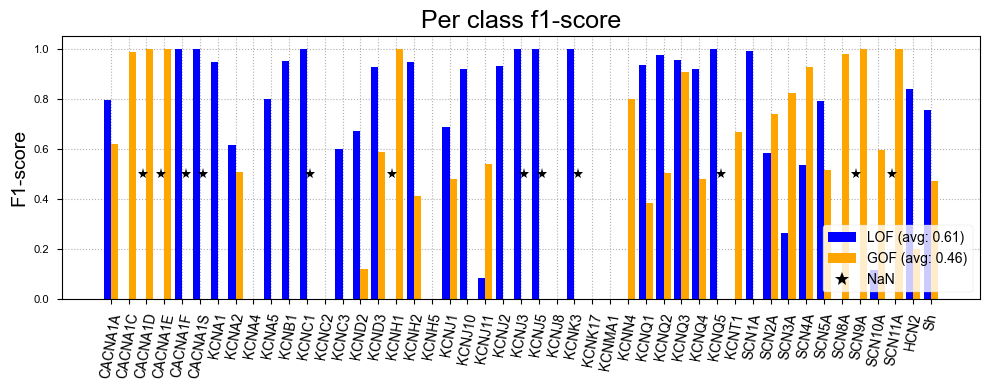

In [14]:

def my_f1_score(folds, gene: str, epoch: int):
    ps = []
    ls = []
    for fold in folds:
        varids = fold.varids[epoch]
        be = fold.get_best_epoch()
        for k, v in enumerate(varids):
            if gene in v:
                p = fold.preds[be][k]
                l = fold.labels[be][k]
                p = np.argmax(p)
                l = np.argmax(l)
                ps.append(p)
                ls.append(l)

    ps = np.array(ps)
    ls = np.array(ls)
    return f1_score(ps, ls, labels=[0, 1], average=None, zero_division=np.nan)

genes = ['CACNA1A', 'CACNA1C', 'CACNA1D', 'CACNA1E', 'CACNA1F', 'CACNA1S', 'KCNA1', 'KCNA2', 'KCNA4', 'KCNA5', 'KCNB1', 'KCNC1', 'KCNC2', 'KCNC3', 'KCND2', 'KCND3', 'KCNH1', 'KCNH2', 'KCNH5', 'KCNJ1', 'KCNJ10', 'KCNJ11', 'KCNJ2', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK3', 'KCNK17', 'KCNMA1', 'KCNN4', 'KCNQ1', 'KCNQ2', 'KCNQ3', 'KCNQ4', 'KCNQ5', 'KCNT1', 'SCN1A', 'SCN2A', 'SCN3A', 'SCN4A', 'SCN5A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'HCN2', 'Sh']
v1 = []
v2 = []
for g in genes:
    f = my_f1_score(runs['ours'], g, 10)
    # print(g, f)
    v1.append(f[0])
    v2.append(f[1])

bar_width = 0.4
group_gap = 0.2

indices = np.arange(len(v1)) * (2 * bar_width + group_gap)  # X positions for groups

with plt.style.context(['seaborn-v0_8-paper']):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
    b1 = ax.bar(indices, v1, width=bar_width, label=f'LOF (avg: {np.nanmean(v1):.2f})', color='blue')
    b2 = ax.bar(indices + bar_width, v2, width=bar_width, label=f'GOF (avg: {np.nanmean(v2):.2f})', color='orange')

    ax.set_xticks(np.arange(len(genes))+bar_width / 2)
    ax.set_xticklabels(genes, ha='center', fontsize=10)
    ax.tick_params(axis='x', rotation=80)

    for i in range(len(v1)):
        if np.isnan(v1[i]):
            plt.plot(indices[i], 0.5, 'k*', markersize=8)  # Red star at the base
        if np.isnan(v2[i]):
            plt.plot(indices[i] + bar_width, 0.5, 'k*', markersize=8)

    star_marker = Line2D([0], [0], marker='*', color='k', markersize=10, linestyle='None', label='NaN')

    # ax.legend()
    plt.legend(handles=[b1, b2, star_marker], fontsize=10, loc=4)
    ax.grid(linestyle='dotted')
    ax.set_title('Per class f1-score', fontsize=18)
    ax.set_ylabel('F1-score', fontsize=14)

print(np.nanmean(v1), np.nanmean(v2))

ours avg: 0.445
mtl avg: 0.505


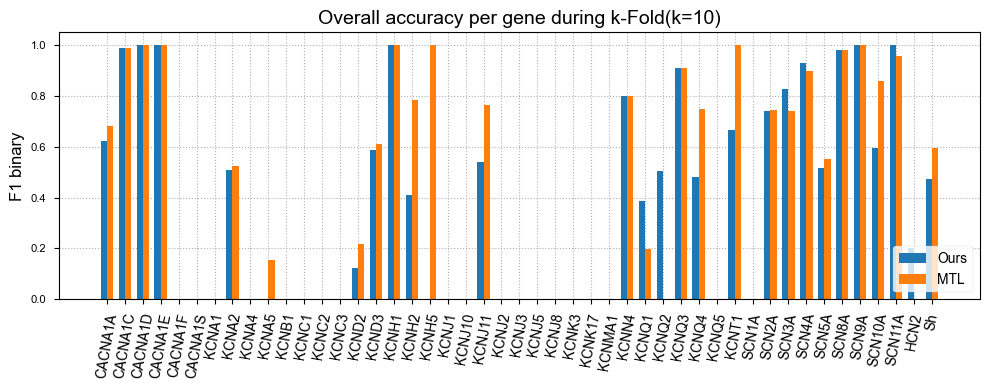

In [15]:
AVERAGE = 'binary'

def gene_wise_f1(folds, gene_of_interest):
    f1s = []
    preds = []
    labels = []
    vs = []
    preds = []
    labels = []
    for fold in folds:
        be = fold.get_best_epoch()
        vs.extend(fold.varids[be])
        # preds.extend(fold.preds[be, :, 1])
        p = fold.preds[be, :]
        p = np.argmax(p, 1)
        preds.extend(p)
        # labels.extend(fold.labels[be, :, 1])
        l = fold.labels[be, :]
        l = np.argmax(l, 1)
        labels.extend(l)
    preds = np.array(preds)
    labels = np.array(labels)

    # preds = np.zeros_like(preds)
    preds = (preds >= 0.5).astype(int)
    genes = np.array([v.split('_')[0] for v in vs])

    idx = np.where(genes == gene_of_interest)

    # print(gene_of_interest, sum(preds[idx] == labels[idx]) / len(labels[idx]))
    
    f1 = f1_score(preds[idx], labels[idx], average=AVERAGE, pos_label=1, labels=[0, 1], zero_division=np.nan)
    # f1 = balanced_accuracy_score(preds[idx], labels[idx])
    return f1

def gene_wise_f1_svm(folds, gene_of_interest):
    f1s = []
    preds = []
    labels = []
    vs = []
    preds = []
    labels = []
    for fold in folds:
        be = fold.best_epoch
        vs.extend(fold.varids)
        preds.extend(fold.preds[0, :])
        labels.extend(fold.labels[0, :])

    preds = np.array(preds)
    labels = np.array(labels)
    preds = (preds > 0).astype(int)
    genes = np.array([v.split('_')[0] for v in vs])

    idx = np.where(genes == gene_of_interest)
    f1 = f1_score(preds[idx], labels[idx], average=AVERAGE, pos_label=1, labels=[0, 1], zero_division=np.nan)
    # f1 = balanced_accuracy_score(preds[idx], labels[idx])
    # print(gene_of_interest, sum(preds[idx] == labels[idx]) / len(labels[idx]))
    
    return f1


genes = ['CACNA1A', 'CACNA1C', 'CACNA1D', 'CACNA1E', 'CACNA1F', 'CACNA1S', 'KCNA1', 'KCNA2', 'KCNA4', 'KCNA5', 'KCNB1', 'KCNC1', 'KCNC2', 'KCNC3', 'KCND2', 'KCND3', 'KCNH1', 'KCNH2', 'KCNH5', 'KCNJ1', 'KCNJ10', 'KCNJ11', 'KCNJ2', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK3', 'KCNK17', 'KCNMA1', 'KCNN4', 'KCNQ1', 'KCNQ2', 'KCNQ3', 'KCNQ4', 'KCNQ5', 'KCNT1', 'SCN1A', 'SCN2A', 'SCN3A', 'SCN4A', 'SCN5A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'HCN2', 'Sh']
scores = {}
for g in genes:
    x = gene_wise_f1(runs['ours'], g)
    scores[g] = x
    
a = np.array(list(scores.values()))

scores2 = {}
for g in genes:
    x = gene_wise_f1_svm(runs['(svm)mtl'], g)
    scores2[g] = x
    # print(g, x)

b = np.array(list(scores2.values()))
x = np.arange(len(genes))

with plt.style.context(['seaborn-v0_8-paper']):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
    bar_width = 0.35
    ax.bar(x - bar_width/2, a, bar_width, label=f'Ours')
    ax.bar(x + bar_width/2, b, bar_width, label=f'MTL')
    print(f'ours avg: {np.nanmean(a):.3f}')
    print(f'mtl avg: {np.nanmean(b):.3f}')
    
    ax.set_xticks(np.arange(len(genes)))
    ax.set_xticklabels(genes, ha='center', fontsize=10)
    ax.tick_params(axis='x', rotation=80)
    
    plt.legend(loc=4, fontsize=10)
    
    plt.title('Overall accuracy per gene during k-Fold(k=10)', fontsize=14)
    plt.ylabel(f'F1 {AVERAGE}', fontsize=12)
    plt.grid(linestyle='dotted')
    # plt.savefig('../Figures/new_per_gene_k_fold_acc.svg', bbox_inches='tight')

Ours: 0.7224539762866359
MTL: 0.7389804846451553
ours avg: 0.722
MTL avg: 0.739
./pdf/kfold_per_gene_acc.pdf


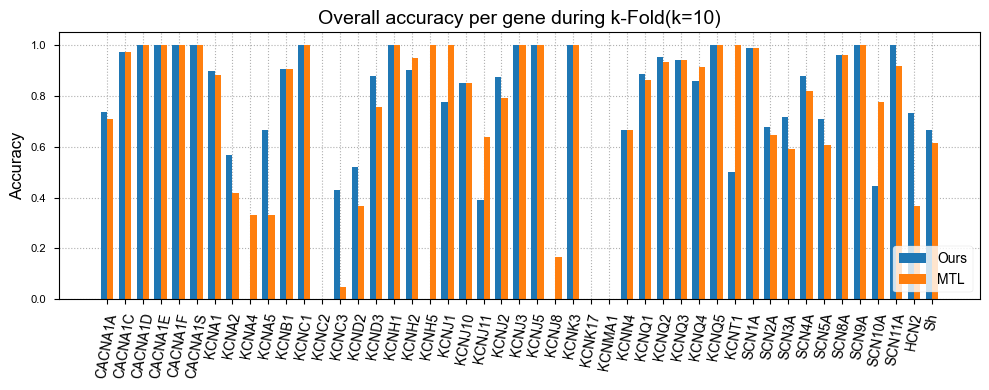

In [16]:
def gene_wise(folds: list[Fold], gene_of_interest: str):

    scores = []
    for fold_idx, fold in enumerate(folds):
        # genes = defaultdict(lambda: defaultdict(list))
        epoch = fold.get_best_epoch()
        
        p1 = fold.preds[epoch]
        l1 = fold.labels[epoch]
        varids = fold.varids[epoch]
        for idx, varid in enumerate(varids):
            gene = varid.split('_')[0]
            if gene == gene_of_interest:
                p = p1[idx]
                l = l1[idx]

                p = np.argmax(p)
                l = np.argmax(l)
                scores.append( p == l )
                # if p == l:
                #     scores.append(1)
                # else:
                #     scores.append(0)

    return scores

def gene_wise_svm(folds: List[Fold], gene_of_interest: str):

    scores = []
    for ii, fold in enumerate(folds):
        p1 = fold.preds[0]
        l1 = fold.labels[0]
        
        # p1 = (p1>=0).astype(int)
        # ba.append(balanced_accuracy_score(l1, p1))

        for idx, varid in enumerate(fold.varids):
            gene = varid.split('_')[0]
            if gene == gene_of_interest:
                p = fold.preds[0, idx]
                l = fold.labels[0, idx]
                
                p = (p >= 0).astype(int)
                
                if p == l:
                    scores.append(1)
                else:
                    scores.append(0)

    return scores

genes = ['CACNA1A', 'CACNA1C', 'CACNA1D', 'CACNA1E', 'CACNA1F', 'CACNA1S', 'HCN2', 'KCNA1', 'KCNA2', 'KCNA4', 'KCNA5', 'KCNB1', 'KCNC1', 'KCNC2', 'KCNC3', 'KCND2', 'KCND3', 'KCNH1', 'KCNH2', 'KCNH5', 'KCNJ1', 'KCNJ10', 'KCNJ11', 'KCNJ2', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK17', 'KCNK3', 'KCNMA1', 'KCNN4', 'KCNQ1', 'KCNQ2', 'KCNQ3', 'KCNQ4', 'KCNQ5', 'KCNT1', 'SCN10A', 'SCN11A', 'SCN1A', 'SCN2A', 'SCN3A', 'SCN4A', 'SCN5A', 'SCN8A', 'SCN9A', 'Sh']
genes = ['CACNA1A', 'CACNA1C', 'CACNA1D', 'CACNA1E', 'CACNA1F', 'CACNA1S', 'KCNA1', 'KCNA2', 'KCNA4', 'KCNA5', 'KCNB1', 'KCNC1', 'KCNC2', 'KCNC3', 'KCND2', 'KCND3', 'KCNH1', 'KCNH2', 'KCNH5', 'KCNJ1', 'KCNJ10', 'KCNJ11', 'KCNJ2', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK3', 'KCNK17', 'KCNMA1', 'KCNN4', 'KCNQ1', 'KCNQ2', 'KCNQ3', 'KCNQ4', 'KCNQ5', 'KCNT1', 'SCN1A', 'SCN2A', 'SCN3A', 'SCN4A', 'SCN5A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'HCN2', 'Sh']
# print(genes)
scores = {}
for g in genes:
    x = gene_wise(runs['ours'], g)
    scores[g] = x

avg1 = []
for k, v in scores.items():
    try:
        avg1.append(sum(v)/len(v))
    except ZeroDivisionError as e:
        print(v)
        # avg.append(np.nan)
        raise e

print('Ours:', np.nanmean(avg1))
# plt.bar(np.arange(len(avg)), avg)

scores = {}
for g in genes:
    x = gene_wise_svm(runs['(svm)mtl'], g)
    scores[g] = x

avg = []
for k, v in scores.items():
    avg.append(sum(v)/len(v))

print('MTL:', np.mean(avg))
# plt.bar(np.arange(len(avg)), avg)

x = np.arange(len(avg))
a = np.array(avg1)
b = np.array(avg)


with plt.style.context(['seaborn-v0_8-paper']):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
    bar_width = 0.35
    ax.bar(x - bar_width/2, a, bar_width, label=f'Ours')# (avg: {np.mean(avg1):.3f})')
    ax.bar(x + bar_width/2, b, bar_width, label=f'MTL')# (avg: {np.mean(avg):.3f})')
    print(f'ours avg: {np.mean(avg1):.3f}')
    print(f'MTL avg: {np.mean(avg):.3f}')
    
    ax.set_xticks(np.arange(len(genes)))
    ax.set_xticklabels(genes, ha='center', fontsize=10)
    ax.tick_params(axis='x', rotation=80)
    
    # ax.axhline(y=np.mean(avg1), color='royalblue', label=f'mean ({np.mean(avg1):.3f})', alpha=0.9)
    # ax.axhline(y=np.mean(avg), color='darkorange', label=f'mean ({np.mean(avg):.3f})', alpha=0.9)
    plt.legend(loc=4, fontsize=10)
    
    plt.title('Overall accuracy per gene during k-Fold(k=10)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(linestyle='dotted')
    # plt.savefig('../Figures/new_per_gene_k_fold_acc.svg', bbox_inches='tight')

    save_fig(fig, 'kfold_per_gene_acc', fig_dir='.', fig_fmt='pdf', fig_size=(10,4))
    plt.show()

Ours: 0.925, 0.017
MTL: 0.897, 0.021
MTL(Our data): pr auc: 0.8125988919961203
./pdf/kfold_full_ds_1_no_orig.pdf


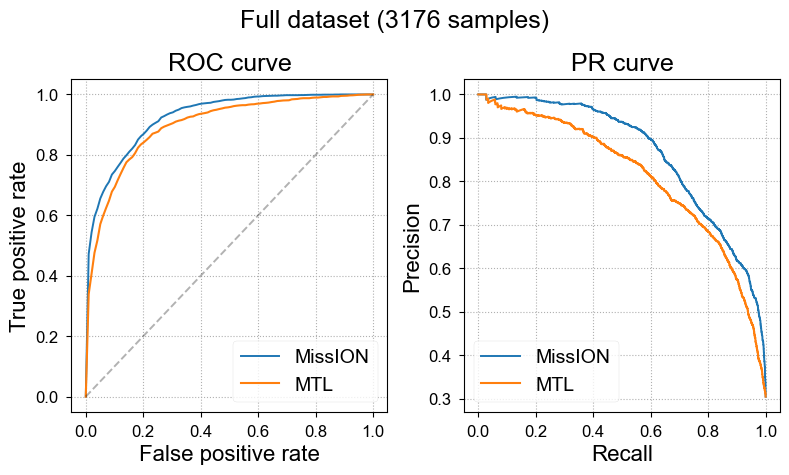

In [17]:
with plt.style.context(['seaborn-v0_8-paper']):

    fig_size = (8, 4.8)
    # fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig, ax = plt.subplots(1, 2, figsize=fig_size, tight_layout=True)

    # Our model
    be = [i.get_best_epoch() for i in runs['ours']]
    aucs1, threshold, threshold_best = main2.compute_roc2(runs['ours'], ax[0], 'Mis', be, linewidth=1.5)
    print(f'Ours: {np.mean(aucs1):.3f}, {np.std(aucs1):.3f}')
    
    # Bosselman MTL
    aucs3 = main2.compute_roc(runs['(svm)mtl'], ax[0], 'MTL (Our data)\n', [0], linewidth=1.5)
    print(f'MTL: {np.mean(aucs3):.3f}, {np.std(aucs3):.3f}')
    
    # aucs4 = main2.compute_roc(runs['(svm)mtl-b'], ax[0], 'MTL', [0], linewidth=1.5)
    # print(f'MTL-b: {np.mean(aucs4):.3f}, {np.std(aucs4):.3f}')
    
    # print('Cohen\'s d:', cohen_d(aucs1, aucs2))
    # print('Cohen\'s d:', cohen_d(aucs1, aucs3))
    # print('Cohen\'s d:', cohen_d(aucs2, aucs3))
    
    # Random line
    ax[0].plot(
        np.linspace(0, 1, 10),
        np.linspace(0, 1, 10),
        color="k",
        alpha=0.3,
        linestyle="--",
    )
    
    ax[0].set_title("ROC curve", fontsize=fontsize_title)
    ax[0].set_ylabel("True positive rate", fontsize=fontsize_label)
    ax[0].set_xlabel("False positive rate", fontsize=fontsize_label)
    
    # ax[0].legend(fontsize=9)
    # ax[0].legend(labels=['MissION', 'MTL', 'MTL$_{O}$'], fontsize=14)
    ax[0].legend(labels=['MissION', 'MTL'], fontsize=14)
    ax[0].grid(linestyle=':')
    ax[0].tick_params(labelsize=12)


    ## ---- PR -----
    # Our model
    be = [i.get_best_epoch() for i in runs['ours']]
    aucs1 = compute_pr_old(runs['ours'], ax[1], 'Ours', be)#, linewidth=1.5)
    
    # be = [i.get_best_epoch() for i in runs['ours_with_hpo']]
    # aucs2 = compute_pr(runs['ours_with_hpo'], ax, 'Ours w/ HPO', be)
    
    # Bosselman MTL
    aucs3 = main2.compute_pr(runs['(svm)mtl'], ax[1], 'MTL(Our data)', [0], linewidth=1.5)
    # aucs4 = main2.compute_pr(runs['(svm)mtl-b'], ax[1], 'MTL', [0], linewidth=1.5)
    ax[1].grid(linestyle=':')
    ax[1].set_xlabel('Recall', fontsize=fontsize_label)
    ax[1].set_ylabel('Precision', fontsize=fontsize_label)
    ax[1].set_title('PR curve', fontsize=18)
    ax[1].tick_params(labelsize=12)
    ax[1].legend(fontsize=9)
    # ax[1].set_ylim([-0.05, 1.05])

    # ax[1].axhline(
    #     0.24891129956451982,
    #     color='k',
    #     alpha=0.3,
    #     linestyle='--')
    
    # ax[1].legend(labels=['MissION', 'MTL', 'MTL$_{O}$'], fontsize=14, loc=3)
    ax[1].legend(labels=['MissION', 'MTL'], fontsize=14, loc=3)

    plt.suptitle('Full dataset (3176 samples)', fontsize=18)

    save_fig(fig, 'kfold_full_ds_1_no_orig', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

plt.show()

#### HPO subset

    Performance on just the HPO subset of data

In [2719]:
# runs = {
#     # 'ours': 'esm100_bf_hpo_go_hposet',
#     'ours': 'Ablation2/esm_bf_go_hpo_hposet',
#     # 'ours': 'Ablation2/esm_bf_hpo_hposet',
#     # 'ours': 'Ablation2/esm_go_hpo_hposet',
#     '(svm)mkl': 'mkl',
#     '(svm)mkl-b': 'bosselman_dataset_mkl',
# }

# for k, v in runs.items():
#     if '(svm)' in k:
#         runs[k] = load_run(v, svm=True)
#     else:
#         runs[k] = load_run(v)

# for k, v in runs.items():
#     for e in range(len(v)):
#         v[e].get_best_epoch()

Ours: 0.970 0.011
MKL: 0.964 0.014
MKL (Out data)
: pr auc: 0.9242592149946106
./pdf/kfold_full_ds_2_no_orig.pdf


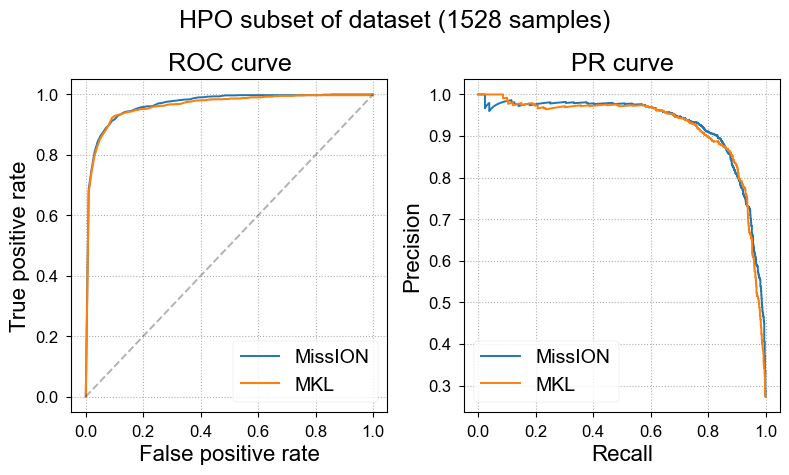

In [51]:
with plt.style.context(['seaborn-v0_8-paper']):

    fig_size = (8, 4.8)
    # fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig, ax = plt.subplots(1, 2, figsize=fig_size, tight_layout=True)

    # Our model
    be = [i.get_best_epoch() for i in runs['ours hpo']]
    aucs1, threshold, threshold_best = main2.compute_roc2(runs['ours hpo'], ax[0], 'Ours', be, linewidth=1.5)
    print(f'Ours: {np.mean(aucs1):.3f} {np.std(aucs1):.3f}')
    
    # Bosselman MTL
    aucs3 = main2.compute_roc(runs['(svm)mkl'], ax[0], 'MKL (Our data)\n', [0], linewidth=1.5)
    print(f'MKL: {np.mean(aucs3):.3f} {np.std(aucs3):.3f}')
    
    # aucs4 = main2.compute_roc(runs['(svm)mkl-b'], ax[0], 'MKL', [0], linewidth=1.5)
    # print(f'MKL-b: {np.mean(aucs4):.3f} {np.std(aucs4):.3f}')
    
    # print('Cohen\'s d:', cohen_d(aucs1, aucs2))
    # print('Cohen\'s d:', cohen_d(aucs1, aucs3))
    # print('Cohen\'s d:', cohen_d(aucs2, aucs3))
    
    # Random line
    ax[0].plot(
        np.linspace(0, 1, 10),
        np.linspace(0, 1, 10),
        color="k",
        alpha=0.3,
        linestyle="--",
    )
    
    ax[0].set_title("ROC curve", fontsize=fontsize_title)
    ax[0].set_ylabel("True positive rate", fontsize=fontsize_label)
    ax[0].set_xlabel("False positive rate", fontsize=fontsize_label)
    
    ax[0].grid(linestyle=':')
    ax[0].tick_params(labelsize=12)
    
    # ax[0].legend(fontsize=12)
    # ax[0].legend(labels=['MissION', 'MKL', 'MKL$_{O}$'], fontsize=14)
    ax[0].legend(labels=['MissION', 'MKL'], fontsize=14)

    ## ---- PR -----
    # Our model
    be = [i.get_best_epoch() for i in runs['ours hpo']]
    aucs1 = compute_pr_old(runs['ours hpo'], ax[1], 'Ours', be)
    
    # be = [i.get_best_epoch() for i in runs['ours_with_hpo']]
    # aucs2 = compute_pr(runs['ours_with_hpo'], ax, 'Ours w/ HPO', be)
    
    # Bosselman MTL
    aucs3 = main2.compute_pr(runs['(svm)mkl'], ax[1], 'MKL (Out data)\n', [0])
    # aucs4 = main2.compute_pr(runs['(svm)mkl-b'], ax[1], 'MKL', [0])
    ax[1].grid(linestyle=':')
    ax[1].set_xlabel('Recall', fontsize=fontsize_label)
    ax[1].set_ylabel('Precision', fontsize=fontsize_label)
    ax[1].set_title('PR curve', fontsize=18)
    ax[1].tick_params(labelsize=12)
    # ax[1].set_ylim([-0.05, 1.05])

    # ax[1].axhline(
    #     0.273739,
    #     color='k',
    #     linestyle='--',
    #     alpha=0.3)
    
    # ax[1].legend(fontsize=12)
    # ax[1].legend(labels=['MissION', 'MKL', 'MKL$_{O}$'], fontsize=14)
    ax[1].legend(labels=['MissION', 'MKL'], fontsize=14)

    plt.suptitle('HPO subset of dataset (1528 samples)', fontsize=18)

    save_fig(fig, 'kfold_full_ds_2_no_orig', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

In [43]:
runs = {
    'ours-mtl': 'esm100_bf_hpo_go_hposet',
    'ours-mkl': 'Ablation2/esm_bf_go_hpo_hposet',
    '(svm)mtl': 'mtl',
    '(svm)mtl-b': 'bosselman_dataset_mtl',
    '(svm)mkl': 'mkl',
    '(svm)mkl-b': 'bosselman_dataset_mkl',
}

for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

> load_run :: 0.569 sec
> load_run :: 0.201 sec
> load_run :: 0.020 sec
> load_run :: 0.006 sec
> load_run :: 0.011 sec
> load_run :: 0.006 sec


./pdf/kfold_combined.pdf


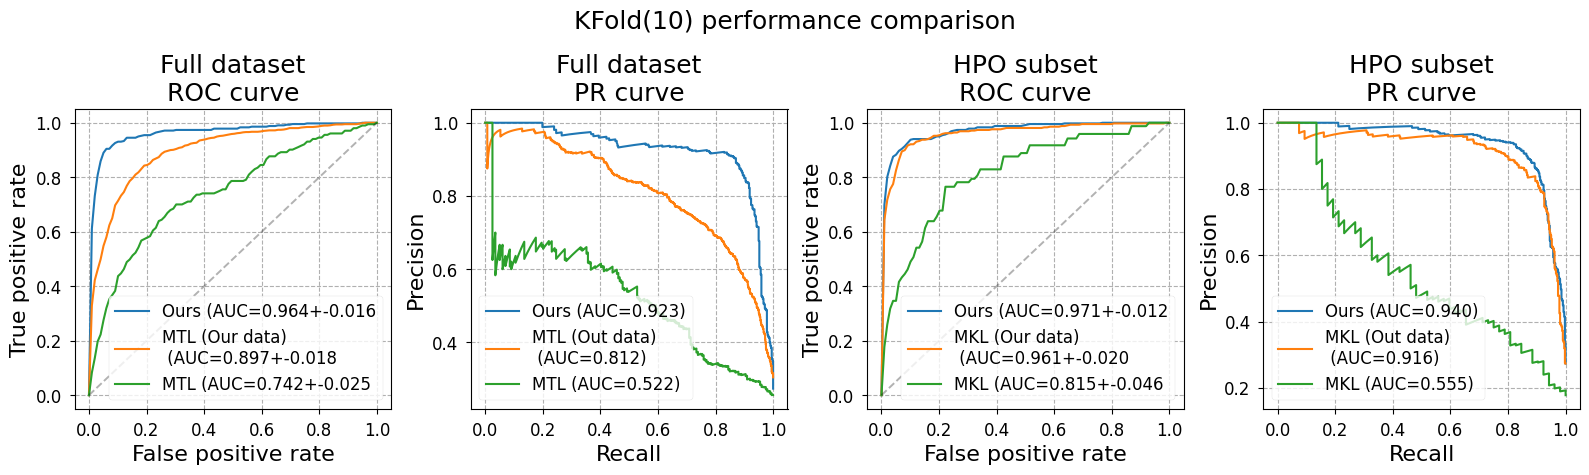

In [224]:
with plt.style.context(['seaborn-v0_8-paper']):

    # fig_size = (9, 7)
    fig_size = (16, 4.8)
    # fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig, ax = plt.subplots(1, 4, figsize=fig_size, tight_layout=True)
    ax = ax.reshape(2, 2)

    # Our model
    be = [i.get_best_epoch() for i in runs['ours-mtl']]
    aucs1, threshold, threshold_best = main2.compute_roc2(runs['ours-mtl'], ax[0, 0], 'Ours', be, linewidth=1.5)
    
    # Bosselman MTL
    aucs3 = main2.compute_roc(runs['(svm)mtl'], ax[0, 0], 'MTL (Our data)\n', [0], linewidth=1.5)
    
    aucs4 = main2.compute_roc(runs['(svm)mtl-b'], ax[0, 0], 'MTL', [0], linewidth=1.5)
    
    # print('Cohen\'s d:', cohen_d(aucs1, aucs2))
    # print('Cohen\'s d:', cohen_d(aucs1, aucs3))
    # print('Cohen\'s d:', cohen_d(aucs2, aucs3))
    
    # Random line
    ax[0, 0].plot(
        np.linspace(0, 1, 10),
        np.linspace(0, 1, 10),
        color="k",
        alpha=0.3,
        linestyle="--",
    )
    
    ax[0, 0].set_title("Full dataset\nROC curve", fontsize=fontsize_title)
    ax[0, 0].set_ylabel("True positive rate", fontsize=fontsize_label)
    ax[0, 0].set_xlabel("False positive rate", fontsize=fontsize_label)
    
    ax[0, 0].grid(linestyle='dashed')
    ax[0, 0].tick_params(labelsize=12)
    ax[0, 0].legend(fontsize=12)

    ## ---- PR -----
    # Our model
    be = [i.get_best_epoch() for i in runs['ours-mtl']]
    aucs1 = compute_pr(runs['ours-mtl'], ax[0, 1], 'Ours', be, linewidth=1.5)
    
    # be = [i.get_best_epoch() for i in runs['ours_with_hpo']]
    # aucs2 = compute_pr(runs['ours_with_hpo'], ax, 'Ours w/ HPO', be)
    
    # Bosselman MTL
    aucs3 = main2.compute_pr(runs['(svm)mtl'], ax[0, 1], 'MTL (Out data)\n', [0], linewidth=1.5)
    aucs4 = main2.compute_pr(runs['(svm)mtl-b'], ax[0, 1], 'MTL', [0], linewidth=1.5)
    ax[0, 1].grid(linestyle='dashed')
    ax[0, 1].set_xlabel('Recall', fontsize=fontsize_label)
    ax[0, 1].set_ylabel('Precision', fontsize=fontsize_label)
    ax[0, 1].set_title('Full dataset\nPR curve', fontsize=18)
    ax[0, 1].tick_params(labelsize=12)
    ax[0, 1].legend(fontsize=12)
    # ax[1].set_ylim([-0.05, 1.05])

    # ----- HPO subset ------

    be = [i.get_best_epoch() for i in runs['ours-mkl']]
    aucs1, threshold, threshold_best = main2.compute_roc2(runs['ours-mkl'], ax[1, 0], 'Ours', be, linewidth=1.5)
    
    # Bosselman MTL
    aucs3 = main2.compute_roc(runs['(svm)mkl'], ax[1, 0], 'MKL (Our data)\n', [0], linewidth=1.5)
    
    aucs4 = main2.compute_roc(runs['(svm)mkl-b'], ax[1, 0], 'MKL', [0], linewidth=1.5)
    
    # print('Cohen\'s d:', cohen_d(aucs1, aucs2))
    # print('Cohen\'s d:', cohen_d(aucs1, aucs3))
    # print('Cohen\'s d:', cohen_d(aucs2, aucs3))
    
    # Random line
    ax[1, 0].plot(
        np.linspace(0, 1, 10),
        np.linspace(0, 1, 10),
        color="k",
        alpha=0.3,
        linestyle="--",
    )
    
    ax[1, 0].set_title("HPO subset\nROC curve", fontsize=fontsize_title)
    ax[1, 0].set_ylabel("True positive rate", fontsize=fontsize_label)
    ax[1, 0].set_xlabel("False positive rate", fontsize=fontsize_label)
    
    ax[1, 0].grid(linestyle='dashed')
    ax[1, 0].tick_params(labelsize=12)
    ax[1, 0].legend(fontsize=12)


    ## ---- PR -----
    # Our model
    be = [i.get_best_epoch() for i in runs['ours-mkl']]
    aucs1 = compute_pr(runs['ours-mkl'], ax[1, 1], 'Ours', be, linewidth=1.5)
    
    # be = [i.get_best_epoch() for i in runs['ours_with_hpo']]
    # aucs2 = compute_pr(runs['ours_with_hpo'], ax, 'Ours w/ HPO', be)
    
    # Bosselman MTL
    aucs3 = main2.compute_pr(runs['(svm)mkl'], ax[1, 1], 'MKL (Out data)\n', [0], linewidth=1.5)
    aucs4 = main2.compute_pr(runs['(svm)mkl-b'], ax[1, 1], 'MKL', [0], linewidth=1.5)
    ax[1, 1].grid(linestyle='dashed')
    ax[1, 1].set_xlabel('Recall', fontsize=fontsize_label)
    ax[1, 1].set_ylabel('Precision', fontsize=fontsize_label)
    ax[1, 1].set_title('HPO subset\nPR curve', fontsize=18)
    ax[1, 1].tick_params(labelsize=12)
    ax[1, 1].legend(fontsize=12)
    # ax[1].set_ylim([-0.05, 1.05])

    plt.suptitle('KFold(10) performance comparison', fontsize=18)

    save_fig(fig, 'kfold_combined', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

# Data quantitiy vs Performance

In [1251]:
runs = {
    # 'ours': 'esm_mtl_go',
    'ours': 'Ablation2/esm_bf_go',
    '(svm)mtl': 'mtl',
    '(svm)mkl': 'mkl',
    '(svm)mtl-b': 'bosselman_dataset_mtl',
    '(svm)mkl-b': 'bosselman_dataset_mkl',
    # 'ours_with_hpo': 'esm_bf_hpo_go_all',
    'ours_hpo': 'esm100_bf_hpo_go_hposet'
}
for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

> load_run :: 0.368 sec
> load_run :: 0.012 sec
> load_run :: 0.012 sec
> load_run :: 0.006 sec
> load_run :: 0.005 sec
> load_run :: 0.680 sec


mtl-b 0.7669671991390687
mkl-b 0.8194305546685214
mtl 0.8331933770639999
mkl 0.920381748386423
Ours 0.8602154530777891
Ours hpo 0.9356154506859073


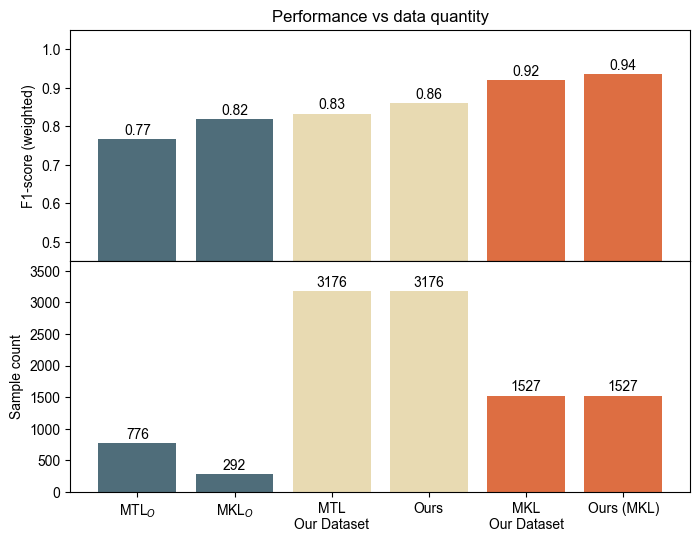

In [1328]:
aucs = {}

metric = 'f1'
average = 'weighted'

# aucs1 = main2.compute_roc(runs['(svm)mtl-b'], None, 'MTL', [0])
aucs1 = compute_metric_svm(runs['(svm)mtl-b'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('mtl-b', aucs1)
aucs['mtlb'] = aucs1


# aucs1 = main2.compute_roc(runs['(svm)mkl-b'], None, 'MKL', [0])
aucs1 = compute_metric_svm(runs['(svm)mkl-b'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('mkl-b', aucs1)
aucs['mklb'] = aucs1


# aucs1 = main2.compute_roc(runs['(svm)mtl'], None, 'MTL', [0])
aucs1 = compute_metric_svm(runs['(svm)mtl'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('mtl', aucs1)
aucs['mtl'] = aucs1

# aucs1 = main2.compute_roc(runs['(svm)mkl'], None, 'MKL', [0])
aucs1 = compute_metric_svm(runs['(svm)mkl'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('mkl', aucs1)
aucs['mkl'] = aucs1

be = [i.get_best_epoch() for i in runs['ours']]
# aucs1 = main2.compute_roc2(runs['ours'], None, 'Ours', be)[0]
aucs1 = compute_metric(runs['ours'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('Ours', aucs1)
aucs['Ours'] = aucs1

be = [i.get_best_epoch() for i in runs['ours_hpo']]
# aucs1 = main2.compute_roc2(runs['ours_hpo'], None, 'Ours', be)[0]\
aucs1 = compute_metric(runs['ours_hpo'], "", metric, average)[0]
aucs1 = np.mean(aucs1)
print('Ours hpo', aucs1)
aucs['Ours hpo'] = aucs1


# labels = ['Ours', 'Ours-hpo', 'MKL', 'MTL']
# labels = ['MTL', 'MKL', 'Ours', 'Ours-hpo']
labels = ['MTL$_{O}$', 'MKL$_{O}$', 'MTL\nOur Dataset', 'MKL\nOur Dataset', 'Ours', 'Ours (MKL)']
# counts = [3176, 1527, 292, 776]
counts = [776, 292, 3176, 1527, 3176, 1527]
# counts = [292, 776, 3176, 3176, 1527, 1527]

# fig, ax = plt.subplots(2, 1)
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, hspace=0)  # Set hspace to 0 to remove vertical spacing

# Create the top plot
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)  # Share the x-axis if desired

# # ax[0].grid()
# # ax[0].set_axisbelow(True)
# rects = ax0.bar(x = labels, height=aucs.values())
# ax0.bar_label(rects, padding=1, fmt="{:.2f}")
# ax0.set_ylim([0.45, 1.05])
# ax0.set_ylabel('F1-score (weighted)')

# rects = ax1.bar(x=labels, height=counts)
# ax1.bar_label(rects, padding=1, fmt="{:.0f}")
# ax1.set_ylim([0, 3176 * 1.15])
# ax1.set_ylabel("Sample count")


colors = ['#dd6e42', '#e8dab2', '#4f6d7a', '#a7c957', '#7ca982']

rects = ax0.bar(x = labels[:2], height=[aucs['mtlb'], aucs['mklb']], color=colors[2])
ax0.bar_label(rects, padding=1, fmt="{:.2f}")
rects = ax0.bar(x = [labels[2], labels[4]], height=[aucs['mtl'], aucs['Ours']], color=colors[1])
ax0.bar_label(rects, padding=1, fmt="{:.2f}")
rects = ax0.bar(x = [labels[3], labels[5]], height=[aucs['mkl'], aucs['Ours hpo']], color=colors[0])
ax0.bar_label(rects, padding=1, fmt="{:.2f}")
ax0.set_ylim([0.45, 1.05])
ax0.set_ylabel('F1-score (weighted)')

rects = ax1.bar(x=labels[:2], height=counts[:2], color=colors[2])
ax1.bar_label(rects, padding=1, fmt="{:.0f}")
rects = ax1.bar(x=labels[2], height=counts[2], color=colors[1])
ax1.bar_label(rects, padding=1, fmt="{:.0f}")
rects = ax1.bar(x=labels[4], height=counts[4], color=colors[1])
ax1.bar_label(rects, padding=1, fmt="{:.0f}")

rects = ax1.bar(x=labels[5], height=counts[5], color=colors[0])
ax1.bar_label(rects, padding=1, fmt="{:.0f}")
rects = ax1.bar(x=labels[3], height=counts[3], color=colors[0])
ax1.bar_label(rects, padding=1, fmt="{:.0f}")
# rects = ax1.bar(x=[labels[2], labels[3]], height=[counts[2], counts[3]], color=colors[1])
# ax1.bar_label(rects, padding=1, fmt="{:.0f}")
# rects = ax1.bar(x=labels[4:], height=counts[4:], color=colors[0])
# ax1.bar_label(rects, padding=1, fmt="{:.0f}")

ax1.set_ylim([0, 3176 * 1.15])
ax1.set_ylabel("Sample count")

ax0.set_title("Performance vs data quantity")
plt.savefig("../Figures/performance_vs_quantity2.png", bbox_inches='tight')

### Table of performance metrics

In [135]:
runs = {
    # 'ours': 'esm_mtl_go',
    'esm': 'Ablation2/esm',
    'esm norm': 'Ablation2/esm_minus_wt',
    'esm norm bf go': 'Ablation2/esm_minus_wt_bf_go_fl',
    'esm norm bf': 'Ablation2/esm_minus_wt_bf',
    'esm norm go': 'Ablation2/esm_norm_go',
    'esm bf go': 'Ablation2/esm_bf_go',
    'esm bf': 'Ablation2/esm_bf',
    'esm go': 'Ablation2/esm_go2',
    'attn bf go': 'Ablation2/attn_bf_go_fl_mwt',
    'gene name': 'gene_name',
    '(svm)mtl': 'mtl',
    'group': 'group_fold_esm_minus_wt_bf_cw',
    '(svm)group mtl': 'group_fold',
    '(svm)group mkl': 'group_fold_mkl',
    'attn group': 'group_fold_attn_bf_fl_mwt',
    # 'ours_with_hpo': 'esm_bf_hpo_go_all',
    # 'ours_hposet': 'esm100_bf_hpo_go_hposet', # has data leak during normalisation 
    'esm bf go hpo': 'Ablation2/esm_bf_go_hpo_hposet2',
    '(svm)mkl': 'mkl',
}

runs = {
    'esm bf go fl': 'RepeatedKFold/esm_bf_go_fl',
    'esm bf go fl mwt': 'RepeatedKFold/esm_bf_go_fl_mwt',
    'esm bf go fl mwt attn': 'RepeatedKFold/esm_bf_go_fl_mwt_attn',
    'esm bf go hpo fl mwt': 'RepeatedKFold/esm_bf_go_hpo_fl_mwt',
    'attn mask bf go': 'RepeatedKFold/esm_attn_with_mask_bf_go_fl',
    'attn mask bf go mwt': 'RepeatedKFold/esm_attn_with_mask_bf_go_mwt_fl',
    '(svm)mtl': 'RepeatedKFold/mtl',
    'esm bf go hpo fl mwt': 'RepeatedKFold/esm_bf_go_hpo_fl_mwt',
    '(svm)mkl': 'RepeatedKFold/mkl',
#     'esm bf go 1': 'Ablation2/esm_bf_go',
#     'esm bf go 2': 'Ablation2/esm_bf_go_2',
#     'esm norm go': 'Ablation2/esm_norm_go',
#     'esm norm': 'Ablation2/esm_minus_wt',
}

runs = {
    'esm': 'RepeatedKFold/esm_bf_go_fl',
    'norm': 'RepeatedKFold_norm/esm_bf_go_fl'
}

runs = {
    'esm': 'RepeatedKFold/esm',
    'esm bf': 'RepeatedKFold/esm_bf',
    'esm go': 'RepeatedKFold/esm_go',
    'bf go': 'bf_go',
    # 'esm bf go': 'RepeatedKFold/esm_bf_go_fl',
    # '650M': 'esm_650m',
    # '8m': 'model_versions/8m',
    # 'test': 'test',
    'go only': 'go_only',
    # 'linear go': 'linear_go',
    # 'non linear go': 'non_linear_go',
    '(svm)mtl': 'RepeatedKFold/mtl',
    '(svm)mtl no sim': 'mtl_no_sim',
    'gene name': 'gene_name',
    'gene name final': 'gene_name_final',
    'genes name final': 'genes_name_final',
}
runs = {
    # 'SCN*->SCN5A': 'SCN5A_FROM_SCN',
    # 'ALL->SCN5A': "SCN5A_FROM_ALL",
    'KCN->KCNA2': 'KCNA2_FROM_KCN',
    'ALL->KCNA2': 'KCNA2_FROM_ALL',
}

# runs = {
#     'group esm bf mwt fl': 'group_fold_esm_minus_wt_bf_fl',
#     'group esm bf mwt fl attn': 'group_fold_attn_bf_fl_mwt',
# }

# runs = {
#     'esm norm': 'group_fold_esm_minus_wt_bf_fl',
#     # 'attn': 'test',
#     'attn': 'group_fold_attn_bf_fl_mwt',
# }

for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

> load_run :: 0.030 sec
> load_run :: 0.025 sec


In [139]:
def compute_metrics(folds: list[Fold], svm=False):

    metrics = defaultdict(list)
    for i, fold in enumerate(folds):
        if not svm:
            best_epoch = fold.best_epoch
            # best_epoch = 10
            p = fold.preds[best_epoch]
            l = fold.labels[best_epoch]
    
            p_pos = p[:, 1]
            p_label = np.argmax(p, 1)
            # p_label = []
            # for pi in p:
            #     if pi[1] > 0.65:
            #         p_label.append(1)
            #     else:
            #         p_label.append(0)
            l = np.argmax(l, 1)
        else:
            p = fold.preds[0]
            l = fold.labels[0]
            p_label = (p >= 0).astype(int)
            p_pos = p

        # ROC
        fpr, tpr, threshold = roc_curve(l, p_pos, pos_label=1)
        metrics['ROC AUC'].append(auc(fpr, tpr))

        # PR
        metrics['PR AUC'].append(average_precision_score(l, p_pos, pos_label=1))

        # MCC
        metrics['MCC'].append(matthews_corrcoef(l, p_label))

        # F1
        metrics['f1-weighted'].append(f1_score(l, p_label, average='weighted', labels=[0, 1], zero_division=np.nan))

        metrics['f1-macro'].append(f1_score(l, p_label, average='macro', labels=[0, 1], pos_label=1, zero_division=np.nan))

        metrics['f1-binary'].append(f1_score(l, p_label, average='binary', labels=[0, 1], pos_label=1, zero_division=np.nan))
        # # BA
        # metrics['BA'].append(balanced_accuracy_score(l, p_label))

        # # acc
        metrics['Acc'].append(sum(p_label == l)/len(p_label))

    return metrics

def compute_metrics2(folds: list[Fold], svm=False):
    # This method flattens all predictions into a list and computes metrics on that
    # instead of averaging across folds
    metrics = defaultdict(list)
    p_pos = []
    p_lab = []
    labs = []
    for i, fold in enumerate(folds):
        if not svm:
            best_epoch = fold.best_epoch
            p = fold.preds[best_epoch]
            l = fold.labels[best_epoch]
    
            p_pos1 = p[:, 1]
            p_label = np.argmax(p, 1)
            l = np.argmax(l, 1)
            p_lab.extend(p_label)
            p_pos.extend(p_pos1)
            labs.extend(l)
        else:
            p = fold.preds[0]
            l = fold.labels[0]
            p_label = (p >= 0).astype(int)
            p_pos1 = p
            p_lab.extend(p_label)
            p_pos.extend(p_pos1)
            labs.extend(l)

    # ROC
    fpr, tpr, threshold = roc_curve(labs, p_pos, pos_label=1)
    metrics['ROC AUC'].append(auc(fpr, tpr))

    # PR
    metrics['PR AUC'].append(average_precision_score(labs, p_pos, pos_label=1))

    # MCC
    metrics['MCC'].append(matthews_corrcoef(labs, p_lab))

    # F1
    metrics['f1-weighted'].append(f1_score(labs, p_lab, average='weighted', labels=[0, 1], zero_division=np.nan))

    metrics['f1-macro'].append(f1_score(labs, p_lab, average='macro', labels=[0, 1], pos_label=1, zero_division=np.nan))

    # # BA
    # metrics['BA'].append(balanced_accuracy_score(l, p_label))

    # # acc
    metrics['Acc'].append(sum(np.array(p_lab) == np.array(labs))/len(p_lab))

    return metrics

if metrics:
    ks = ""
    for k in metrics.keys():
        ks += k 
        ks += " | "
    print(ks)

for k, v in runs.items():
    # print('----', k, '----')
    is_svm = 'svm' in k
    metrics = compute_metrics(v, svm=is_svm)
    s = f"{k:9} "
    for k1, v in metrics.items():
        # print(f"{k}: {np.mean(v):.3f} {np.std(v):.3f}")
        s += f"& {np.mean(v):.3f} $\pm$ {np.std(v):.3f}"
        # s += f" {np.mean(v):.3f} |"
    s += f'\\\\ % {k}'
    
    print(s)

ROC AUC | PR AUC | MCC | f1-weighted | f1-macro | f1-binary | Acc | 
KCN->KCNA2 & 0.700 $\pm$ 0.180& 0.788 $\pm$ 0.115& 0.250 $\pm$ 0.250& 0.583 $\pm$ 0.088& 0.583 $\pm$ 0.088& 0.657 $\pm$ 0.112& 0.600 $\pm$ 0.100\\ % KCN->KCNA2
ALL->KCNA2 & 0.680 $\pm$ 0.240& 0.714 $\pm$ 0.213& 0.517 $\pm$ 0.299& 0.741 $\pm$ 0.158& 0.741 $\pm$ 0.158& 0.788 $\pm$ 0.121& 0.750 $\pm$ 0.150\\ % ALL->KCNA2


In [1100]:
final = defaultdict(list)
final_std = defaultdict(list)

pos = 0
for k, v in runs.items():
    if k in ['ours', '(svm)mtl']:
        # print('----', k, '----')
        is_svm = 'svm' in k
        metrics = compute_metrics(v, svm=is_svm)
    
        for k, v in metrics.items():
            final[k].append(np.mean(v))
            final_std[k].append(np.std(v))

final

defaultdict(list, {})

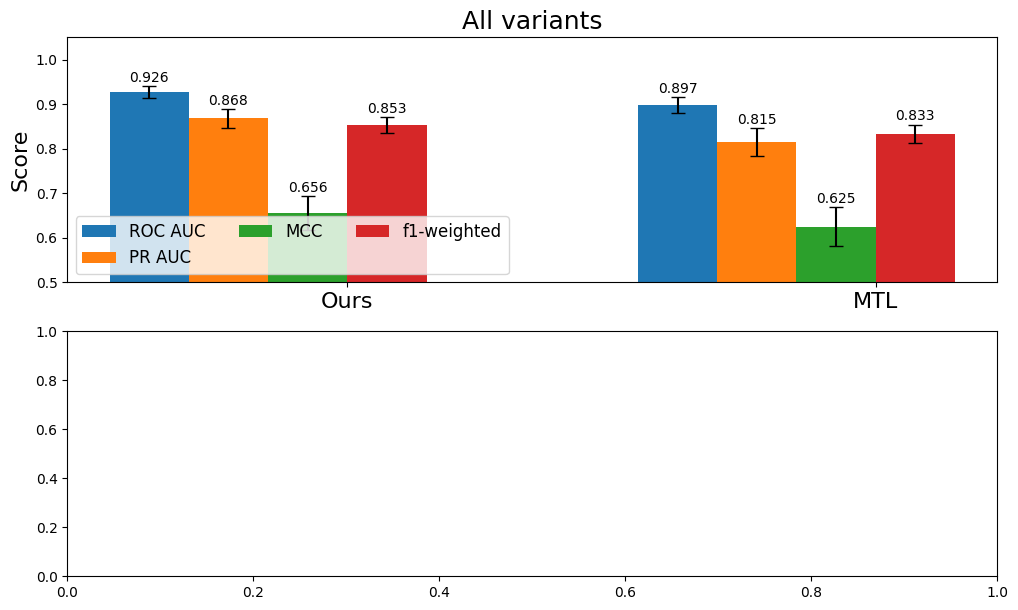

In [503]:
xnames = list(runs.keys())
# print(xnames)
xnames = ['Ours', 'MTL']

x = np.arange(len(xnames))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(2, 1, figsize=(12,7))

final = defaultdict(list)
final_std = defaultdict(list)

pos = 0
for k, v in runs.items():
    if k in ['ours', '(svm)mtl']:
        # print('----', k, '----')
        is_svm = 'svm' in k
        metrics = compute_metrics(v, svm=is_svm)
    
        for k, v in metrics.items():
            final[k].append(np.mean(v))
            final_std[k].append(np.std(v))

        # for metric, value in metrics.items():
        #     ax[0].boxplot(value, positions = [pos])
        #     pos += 1
        # pos += 2

for k, v in final.items():
    v_err = final_std[k]
    offset = width * multiplier
    rects = ax[0].bar(x + offset, v, width, label=k, yerr=v_err, capsize=5)
    ax[0].bar_label(rects, padding=1, fmt='{:.3f}')
    multiplier += 1



ax[0].set_ylim([0.5, 1.05])
ax[0].set_ylabel('Score', fontsize=fontsize_label)
ax[0].set_title('All variants', fontsize=fontsize_title)
ax[0].set_xticks(x + width*2+0.075, xnames, fontsize=fontsize_label)
ax[0].legend(loc='lower left', ncols=3, fontsize=fontsize_legend)


xnames = ['Ours', 'MKL']

x = np.arange(len(xnames))
width = 0.15
multiplier = 0

final = defaultdict(list)
final_std = defaultdict(list)

for k, v in runs.items():
    if k in ['ours_hposet', '(svm)mkl']:
        # print('----', k, '----')
        is_svm = 'svm' in k
        metrics = compute_metrics(v, svm=is_svm)
    
        for k, v in metrics.items():
            final[k].append(np.mean(v))
            final_std[k].append(np.std(v))

for k, v in final.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, v, width, label=k, yerr=v_err, capsize=5)
    ax[1].bar_label(rects, padding=1, fmt='{:.3f}')
    multiplier += 1

ax[1].set_title('Subset with HPO terms', fontsize=fontsize_title)
ax[1].set_ylim([0, 1.1])
ax[1].set_ylabel('Score', fontsize=fontsize_label)
ax[1].set_xticks(x + width*2+0.075, xnames, fontsize=fontsize_label)
# ax[1].legend(loc='lower left', ncols=3)

# plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Various metrics', fontsize=fontsize_title)
# plt.savefig('../Figures/metrics_bar_plot.svg', bbox_inches='tight')

plt.show()

### MAVE

    MAVE Generalisation performance

    How does our model generalise to an unseen gene
    How does performance improve as we introduce more and more samples into the training set

In [ ]:
# runs = {
#     'mave': 'mave',
#     '1': 'mave_1',
#     '10': 'mave_10',
#     '20': 'mave_20',
#     'mave_norm': 'mave_normalised',
#     '1_norm': 'mave_1_normalised',
#     '10_norm': 'mave_10_normalised',
# }

runs = {
    '1%': 'mave_1p_nogo',
    '5%': 'mave_5p',
    '10%': 'mave_10p',
    '20%': 'mave_20p',
    '30%': 'mave_30p',
    '40%': 'mave_40p',
    '50%': 'mave_50p',
    '60%': 'mave_60p',
    '70%': 'mave_70p',
    '80%': 'mave_80p',
    '90%': 'mave_90p',
}

runs = {
    '1': 'mave_bf_go/mave_1',
    '5': 'mave_bf_go/mave_5',
    '10': 'mave_bf_go/mave_10',
    '20': 'mave_bf_go/mave_20',
    '30': 'mave_bf_go/mave_30',
    '40': 'mave_bf_go/mave_40',
    '50': 'mave_bf_go/mave_50',
    '60': 'mave_bf_go/mave_60',
    '70': 'mave_bf_go/mave_70',
    '80': 'mave_bf_go/mave_80',
    '90': 'mave_bf_go/mave_90',
    '100': 'mave_bf_go/mave_100',
}

# runs = {
#     'kcn': 'mave_from_kcn',
# }

runs = {
    # 'scn5a': 'scn5a_gen',
    # 'scn5a_10': 'scn5a_gen_10',
    # 'scn5a_10_nocw': 'scn5a_gen_10_nocw',
    # 'scn5a_esm': 'scn5a_gen_esmonly',
    # 'scn5a_0_shot': 'scn5a_gen/zero_shot',
    # 'scn5a_1_shot': 'scn5a_gen/one_shot',
    # 'scn5a_5 shot': 'scn5a_gen/five_shot',
    # 'scn5a_10_shot': 'scn5a_gen/ten_shot',

    '0': 'scn5a_gen/zero_shot_no_go',
    '1': 'scn5a_gen/one_shot_no_go',
    '5': 'scn5a_gen/five_shot_no_go',
    '10': 'scn5a_gen/ten_shot_no_go',
    '20': 'scn5a_gen/20_shot_no_go',
    '30': 'scn5a_gen/30_shot_no_go',
    '40': 'scn5a_gen/40_shot_no_go',
    '50': 'scn5a_gen/50_shot_no_go',
}

# runs = {
#     '0': 'scn2a_gen/zero_shot_no_go',
#     '1': 'scn2a_gen/one_shot_no_go',
#     '5': 'scn2a_gen/five_shot_no_go',
#     '10': 'scn2a_gen/ten_shot_no_go',
#     '20': 'scn2a_gen/20_shot_no_go',
#     '30': 'scn2a_gen/30_shot_no_go',
#     '40': 'scn2a_gen/40_shot_no_go',
#     '50': 'scn2a_gen/50_shot_no_go',
# }

## Count based sampling
runs = {
    '0': 'mave_fixed_test/0',
    '1': 'mave_fixed_test/1',
    '5': 'mave_fixed_test/5',
    '10': 'mave_fixed_test/10',
    '20': 'mave_fixed_test/20',
    '30': 'mave_fixed_test/30',
    '40': 'mave_fixed_test/40',
    '50': 'mave_fixed_test/50',
    '60': 'mave_fixed_test/60',
    '70': 'mave_fixed_test/70',
    '80': 'mave_fixed_test/80',
    '90': 'mave_fixed_test/90',
}

# runs3 = {
#     '0': 'sh_fixed_test/0',
#     '1': 'sh_fixed_test/1',
#     '5': 'sh_fixed_test/5',
#     '10': 'sh_fixed_test/10',
#     '20': 'sh_fixed_test/20',
#     '30': 'sh_fixed_test/30',
#     '40': 'sh_fixed_test/40',
#     '50': 'sh_fixed_test/50',
#     '60': 'sh_fixed_test/60',
# }

## Percentage based sampling
runs2 = {
    '0': 'mave_percentage_test/0',
    '1': 'mave_percentage_test/1',
    '5': 'mave_percentage_test/5',
    '10': 'mave_percentage_test/10',
    '20': 'mave_percentage_test/20',
    '30': 'mave_percentage_test/30',
    '40': 'mave_percentage_test/40',
    '50': 'mave_percentage_test/50',
    '60': 'mave_percentage_test/60',
    '70': 'mave_percentage_test/70',
    '80': 'mave_percentage_test/80',
    '90': 'mave_percentage_test/90',
}


runs3 = {
    '0': 'scn5a_fixed_test/0',
    '1': 'scn5a_fixed_test/1',
    '5': 'scn5a_fixed_test/5',
    '10': 'scn5a_fixed_test/10',
    '20': 'scn5a_fixed_test/20',
    '30': 'scn5a_fixed_test/30',
    '40': 'scn5a_fixed_test/40',
    '50': 'scn5a_fixed_test/50',
    '60': 'scn5a_fixed_test/60',
    '70': 'scn5a_fixed_test/70',
    '80': 'scn5a_fixed_test/80',
    '90': 'scn5a_fixed_test/90',
}

runs4 = {
    '0': 'Generalisation/scn5a_percentage_test/0',
    '1': 'Generalisation/scn5a_percentage_test/1',
    '5': 'Generalisation/scn5a_percentage_test/5',
    '10': 'Generalisation/scn5a_percentage_test/10',
    '20': 'Generalisation/scn5a_percentage_test/20',
    '30': 'Generalisation/scn5a_percentage_test/30',
    '40': 'Generalisation/scn5a_percentage_test/40',
    '50': 'Generalisation/scn5a_percentage_test/50',
    '60': 'Generalisation/scn5a_percentage_test/60',
    '70': 'Generalisation/scn5a_percentage_test/70',
    '80': 'Generalisation/scn5a_percentage_test/80',
    '90': 'Generalisation/scn5a_percentage_test/90',
}

# ====================================================

## These use the properly normalised embeddings with the correct wildtype subtraction
runs = {
    '0': 'mave_is3/mave_fixed_test/0',
    '1': 'mave_is3/mave_fixed_test/1',
    '10': 'mave_is3/mave_fixed_test/10',
    '20': 'mave_is3/mave_fixed_test/20',
    '30': 'mave_is3/mave_fixed_test/30',
    '40': 'mave_is3/mave_fixed_test/40',
    '50': 'mave_is3/mave_fixed_test/50',
    '60': 'mave_is3/mave_fixed_test/60',
    '70': 'mave_is3/mave_fixed_test/70',
    '80': 'mave_is3/mave_fixed_test/80',
    '90': 'mave_is3/mave_fixed_test/90',
}

runs2 = {
    '0': 'mave_is3/scn2a_fixed_test/0',
    '1': 'mave_is3/scn2a_fixed_test/1',
    # '5': 'mave_is3/scn2a_fixed_test/5',
    '10': 'mave_is3/scn2a_fixed_test/10',
    '20': 'mave_is3/scn2a_fixed_test/20',
    '30': 'mave_is3/scn2a_fixed_test/30',
}

runs3 = {
    '0': 'mave_is3/scn5a_fixed_test/0',
    '1': 'mave_is3/scn5a_fixed_test/1',
    '10': 'mave_is3/scn5a_fixed_test/10',
    '20': 'mave_is3/scn5a_fixed_test/20',
    '30': 'mave_is3/scn5a_fixed_test/30',
    '40': 'mave_is3/scn5a_fixed_test/40',
    '50': 'mave_is3/scn5a_fixed_test/50',
    '60': 'mave_is3/scn5a_fixed_test/60',
    '70': 'mave_is3/scn5a_fixed_test/70',
    '80': 'mave_is3/scn5a_fixed_test/80'
    '90': 'mave_is3/scn5a_fixed_test/90',
    '100': 'mave_is3/scn5a_fixed_test/100',
    '110': 'mave_is3/scn5a_fixed_test/110',
    '120': 'mave_is3/scn5a_fixed_test/120',
    '130': 'mave_is3/scn5a_fixed_test/130',
    '140': 'mave_is3/scn5a_fixed_test/140',
    '150': 'mave_is3/scn5a_fixed_test/150',
}

runs4 = {
    '0': 'mave_is3/scn5a_percentage_test/0',
    '1': 'mave_is3/scn5a_percentage_test/1',
    '10': 'mave_is3/scn5a_percentage_test/10',
    '20': 'mave_is3/scn5a_percentage_test/20',
    '30': 'mave_is3/scn5a_percentage_test/30',
    '40': 'mave_is3/scn5a_percentage_test/40',
    '50': 'mave_is3/scn5a_percentage_test/50',
    '60': 'mave_is3/scn5a_percentage_test/60',
    '70': 'mave_is3/scn5a_percentage_test/70',
    '80': 'mave_is3/scn5a_percentage_test/80',
    '90': 'mave_is3/scn5a_percentage_test/90',
}

for k, v in runs.items():
    runs[k] = load_run(v)

for k, v in runs2.items():
    runs2[k] = load_run(v)

for k, v in runs3.items():
    runs3[k] = load_run(v)

for k, v in runs4.items():
    runs4[k] = load_run(v)


In [1366]:
def load_mave(path):
    path = f"../Log/{path}/"
    folders = os.listdir(path)
    folders = sorted([int(i) for i in folders])
    runs = {}
    for k, v in enumerate(folders):
        runs[str(v)] = load_run(f"{path}/{v}/")
    return runs

# runs = load_mave('mave_is3/scn2a_fixed_test/')
# runs2 = load_mave('mave_is3/scn5a_percentage_test/')
# runs3 = load_mave('mave_is3/scn5a_fixed_test/')
# runs4 = load_mave('mave_is3/mave_fixed_test/')

# runs = load_mave('mave_percentage_test/')
# runs2 = load_mave('mave_fixed_test')
# runs3 = load_mave('scn5a_percentage_test/')
# runs4 = load_mave('scn5a_fixed_test/')

runs = load_mave('mave_final/mave_percentage_test/')
runs2 = load_mave('mave_final/mave_fixed_test/')

runs3 = load_mave('mave_final/scn5a_percentage_test/')
runs4 = load_mave('mave_final/scn5a_fixed_test/')

runs5 = load_mave('mave_final/scn2a_percentage_test/')
runs6 = load_mave('mave_final/scn2a_fixed_test/')

> load_run :: 0.118 sec
> load_run :: 0.093 sec
> load_run :: 0.093 sec
> load_run :: 0.096 sec
> load_run :: 0.097 sec
> load_run :: 0.085 sec
> load_run :: 0.087 sec
> load_run :: 0.087 sec
> load_run :: 0.084 sec
> load_run :: 0.088 sec
> load_run :: 0.085 sec
> load_run :: 0.084 sec
> load_run :: 0.083 sec
> load_run :: 0.074 sec
> load_run :: 0.075 sec
> load_run :: 0.077 sec
> load_run :: 0.079 sec
> load_run :: 0.076 sec
> load_run :: 0.077 sec
> load_run :: 0.081 sec
> load_run :: 0.085 sec
> load_run :: 0.082 sec
> load_run :: 0.080 sec
> load_run :: 0.076 sec
> load_run :: 0.085 sec
> load_run :: 0.078 sec
> load_run :: 0.079 sec
> load_run :: 0.079 sec
> load_run :: 0.080 sec
> load_run :: 0.077 sec
> load_run :: 0.077 sec
> load_run :: 0.084 sec
> load_run :: 0.085 sec
> load_run :: 0.080 sec
> load_run :: 0.075 sec
> load_run :: 0.076 sec
> load_run :: 0.078 sec
> load_run :: 0.073 sec
> load_run :: 0.074 sec
> load_run :: 0.079 sec
> load_run :: 0.072 sec
> load_run :: 0.

In [10]:
def compute_roc(folds: [Fold], ax: plt.axes, name: str, epochs: List[int] = [19]):

    ps = []
    ls = []
    tprs = []
    aucs = []
    fold = folds[0]
    for ii, fold in enumerate(folds):
    # for ii in range(fold.preds.shape[0]):
        # epoch = ii
        # epoch = 3
        epoch = fold.get_best_epoch()
        p = fold.preds[epoch]
        l = fold.labels[epoch]

        p = p[:, 1]
        l = np.argmax(l, 1)

        #p = np.concatenate(p)
        #l = np.concatenate(l)

        ps.append(p)
        ls.append(l)

        mean_fpr = np.linspace(0, 1, 100)
        fpr, tpr, threshold = roc_curve(l, p)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

        # ax.plot(mean_fpr, interp_tpr, color='k', alpha=0.2) #, label=aucs[-1])

    argmax = np.argmax(aucs)
    print('Best epoch:', argmax)

    mean_tpr = tprs[argmax] # np.mean(tprs, 0)
    mean_tpr[-1] = 1.0
    mean_auc = aucs[argmax] #np.mean(aucs)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, label=f"{name} (AUC={mean_auc:.3f})")
    return aucs

def compute_pr_old(folds: List[Fold], ax: plt.axes, name: str, epochs: List[int] = [19]):
    ls = []
    ps = []
    scores = []
    fold = folds[0]
    for fold in folds:
        # epoch = 3
        epoch = fold.get_best_epoch()
        p = fold.preds[epoch]
        l = fold.labels[epoch]
        
        # p = np.argmax(p, 1)
        p = p[:, 1]
        l = np.argmax(l, 1)

        ls.append(l)
        ps.append(p)

        # precision, recall, thresholds = precision_recall_curve(l, p)
        # score = average_precision_score(l, p)
        # scores.append(score)
        
    # best_score = np.argmax(scores)
    # lss.append(ls[best_score])
    # pss.append(ps[best_score])
    # scores_ls.append(scores[best_score])

    ps = np.concatenate(ps)
    ls = np.concatenate(ls)
    
    precision, recall, thresholds = precision_recall_curve(ls, ps)
    score = average_precision_score(ls, ps)

    # To make the plot nicer, I interpolate incase there are any precision drops to 0
    # precision = interpolate_zeros(precision)

    ax.plot(recall, precision, label=f"{name} (APS={score:.3f})")
    return precision, recall, thresholds, score


def compute_ba(folds: List[Fold], ax: plt.axes, name: str, positions: List[int]):
    fold = folds[0]
    bas = []
    acc_lofs = []
    acc_gofs = []
    for ii, fold in enumerate(folds):
        ba = []
        acc_lof = []
        acc_gof = []
        for epoch in range(fold.preds.shape[0]):
            p = fold.preds[epoch]
            l = fold.labels[epoch]
    
            p = np.argmax(p, 1)
            l = np.argmax(l, 1)
    
            ba.append(balanced_accuracy_score(p, l))
    
            lof_idx = np.where(l == 0)[0]
            gof_idx = np.where(l == 1)[0]
    
            acc_lof.append(
                sum(p[lof_idx] == l[lof_idx]) / len(lof_idx)
            )
            acc_gof.append(
                sum(p[gof_idx] == l[gof_idx]) / len(gof_idx)
            )
        best_epoch = np.argmax(ba)
        bas.append(ba[best_epoch])
        acc_lofs.append(acc_lof[best_epoch])
        acc_gofs.append(acc_gof[best_epoch])

    return bas, acc_lofs, acc_gofs


In [1380]:
def compute_f1_score(folds: List[Fold], epoch: int):
    score = []
    for fold_idx, fold in enumerate(folds):
        epoch = fold.get_best_epoch()
        preds = fold.preds[epoch, :, :] # [samples=20, 2] 10lof  10gof not in order
        labels = fold.labels[epoch, :, :]
        preds = np.argmax(preds, 1)
        labels = np.argmax(labels, 1)
        # s = f1_score(labels, preds, average='macro', labels=[0, 1], pos_label=1, zero_division=np.nan)
        s = accuracy_score(labels, preds)
        # s =  f1_score(labels, preds, average='binary', pos_label=0, labels=[0, 1], zero_division=np.nan)
        score.append(s)
    return score

score_avgs = []
labels = []
for k, v in runs.items():
    s = compute_f1_score(v, 5)
    score_avgs.append(s)
    labels.append(k)

score_avgs2 = []
labels2 = []
for k, v in runs2.items():
    s = compute_f1_score(v, 5)
    score_avgs2.append(s)
    labels2.append(k)


score_avgs3 = []
labels3 = []
for k, v in runs3.items():
    s = compute_f1_score(v, 5)
    score_avgs3.append(s)
    labels3.append(k)


score_avgs4 = []
labels4 = []
for k, v in runs4.items():
    s = compute_f1_score(v, 5)
    score_avgs4.append(s)
    labels4.append(k)

score_avgs5 = []
labels5 = []
for k, v in runs5.items():
    s = compute_f1_score(v, 5)
    score_avgs5.append(s)
    labels5.append(k)

score_avgs6 = []
labels6 = []
for k, v in runs6.items():
    s = compute_f1_score(v, 5)
    score_avgs6.append(s)
    labels6.append(k)

./pdf/generalisation_result.pdf


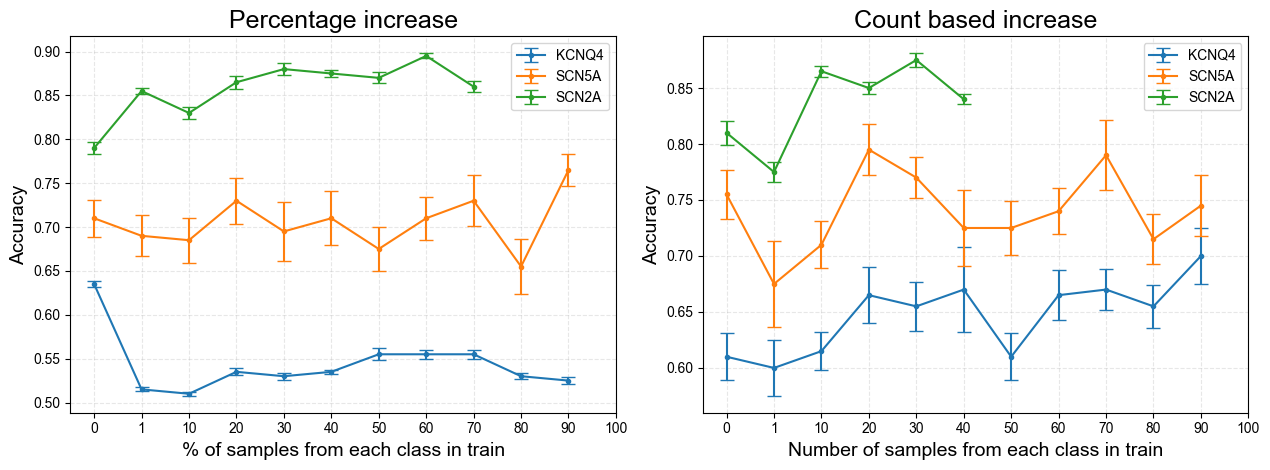

In [1381]:


fig_size = (12.8, 4.8)
fig, ax = plt.subplots(1, 2, figsize=fig_size, tight_layout=True)


## Run 1
data_array = np.array(score_avgs)
means = np.mean(data_array, axis=1)
stds = np.std(data_array, axis=1, ddof=1)  # ddof=1 for sample std
n_measurements = data_array.shape[1]
standard_errors = stds / np.sqrt(n_measurements) / np.sqrt(data_array.shape[1])
x = np.arange(data_array.shape[0])
ax[0].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='KCNQ4')

## Run 3
data_array = np.array(score_avgs3)
x = np.arange(data_array.shape[0])
means = np.mean(data_array, axis=1)
standard_errors = np.std(data_array, axis=1, ddof=1) / np.sqrt(data_array.shape[1])
ax[0].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='SCN5A')

# Run 6
data_array = np.array(score_avgs5)
x = np.arange(data_array.shape[0])
means = np.mean(data_array, axis=1)
standard_errors = np.std(data_array, axis=1, ddof=1) / data_array.shape[1]
ax[0].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='SCN2A')



## ======== AX 2 =======
## Run 2
data_array = np.array(score_avgs2)
x = np.arange(data_array.shape[0])
means = np.mean(data_array, axis=1)
standard_errors = np.std(data_array, axis=1, ddof=1) / np.sqrt(data_array.shape[1])
ax[1].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='KCNQ4')

## Run 4
data_array = np.array(score_avgs4)
x = np.arange(data_array.shape[0])
means = np.mean(data_array, axis=1)
standard_errors = np.std(data_array, axis=1, ddof=1) / np.sqrt(data_array.shape[1])
ax[1].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='SCN5A')

# Run 5
data_array = np.array(score_avgs6)
x = np.arange(data_array.shape[0])
means = np.mean(data_array, axis=1)
standard_errors = np.std(data_array, axis=1, ddof=1) / data_array.shape[1]
ax[1].errorbar(x, means, yerr=standard_errors, fmt='-o', markersize=3, capsize=5, label='SCN2A')


ax[0].set_title('Percentage increase', fontsize=18)
ax[0].set_xlabel('% of samples from each class in train', fontsize=14)
ax[1].set_title('Count based increase', fontsize=18)
ax[1].set_xlabel('Number of samples from each class in train', fontsize=14)

# data_array = np.array(score_avgs4)
# y = np.mean(data_array, 1)
# x = np.arange(data_array.shape[0])
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# coeffs = np.polyfit(x, y, 1)
# p = np.poly1d(coeffs)
# print(p)

labels = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]#, 110, 120, 130, 140, 150]
for i in [0, 1]:

    ax[i].set_xticks(np.arange(len(labels)))
    ax[i].set_xticklabels(labels, ha='center')
    ax[i].tick_params(axis='x', rotation=0)
    # ax.set_xlabel("Amount of samples in train-set", fontsize=14)
    # ax[i].set_ylabel("F1-score (weighted)", fontsize=14)
    ax[i].set_ylabel('Accuracy', fontsize=14)
    # ax.set_title("Performance change from \nincreasing quantity of training samples", fontsize=16)
    ax[i].legend()
    ax[i].grid(linestyle='dashed', alpha=0.3)

save_fig(fig, 'generalisation_result', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

plt.show()

Best epoch: 18
Best epoch: 16
Best epoch: 24
Best epoch: 22
Best epoch: 0
Best epoch: 44
Best epoch: 7
Best epoch: 28
Best epoch: 37
Best epoch: 46
Best epoch: 0
Best epoch: 34


/home/sean/.pyenv/versions/3.9.16/envs/esmpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sean/.pyenv/versions/3.9.16/envs/esmpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sean/.pyenv/versions/3.9.16/envs/esmpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sean/.pyenv/versions/3.9.16/envs/esmpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/sean/.pyenv/versions/3.9.16/envs/esmpy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458

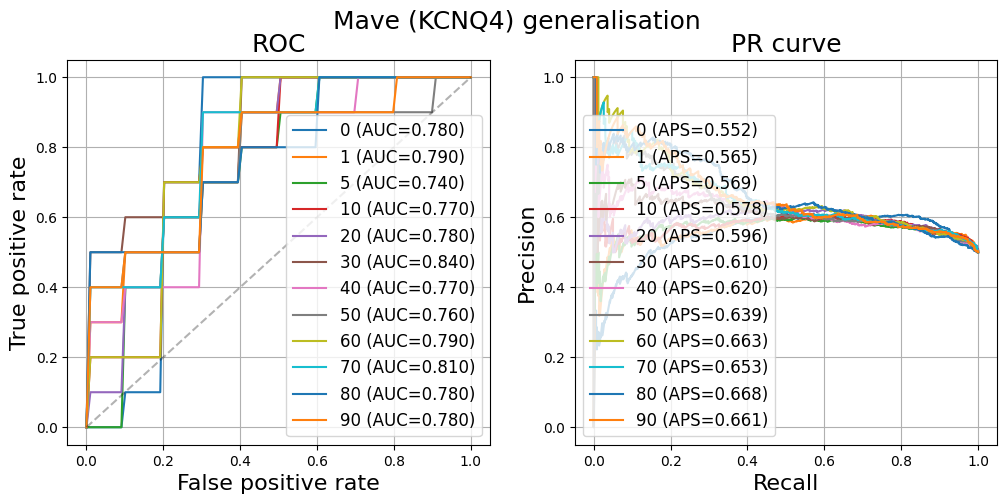

In [723]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# aucs1 = compute_roc(runs['mave'], ax[0], '0%', [0])
# aucs1 = compute_roc(random_choice, ax[0], 'Ours', [0])

for k, v in runs.items():
    compute_roc(v, ax[0], k, [0])

# Random line
ax[0].plot(
    np.linspace(0, 1, 10),
    np.linspace(0, 1, 10),
    color="k",
    alpha=0.3,
    linestyle="--",
)

ax[0].set_title("ROC", fontsize=fontsize_title)
ax[0].set_ylabel("True positive rate", fontsize=fontsize_label)
ax[0].set_xlabel("False positive rate", fontsize=fontsize_label)

ax[0].legend(fontsize=fontsize_legend)
ax[0].grid()


# compute_pr(runs['mave'], ax[1], 'Ours', [0])
# compute_pr(random_choice, ax[1], 'Ours', [0])

bas = []
ba_ls = []
idx = 0
for k, v in runs.items():
    compute_pr(v, ax[1], k, [0])
    ba, acclof, accgof = compute_ba(v, ax[1], k, idx)
    bas.append((acclof, accgof))
    ba_ls.append(ba)



ax[1].set_title('PR curve', fontsize=fontsize_title)
ax[1].set_xlabel('Recall', fontsize=fontsize_label)
ax[1].set_ylabel('Precision', fontsize=fontsize_label)
ax[1].grid()
ax[1].legend(fontsize=fontsize_legend)
plt.suptitle("Mave (KCNQ4) generalisation", fontsize=fontsize_title)

# plt.savefig('../Figures/figure_3_a3.svg', bbox_inches='tight')

# 3
# 723
# 717
# 732
# 4
#728
#715
#752
# 5
# 737
# 729
# 749

plt.show()

IndexError: invalid index to scalar variable.

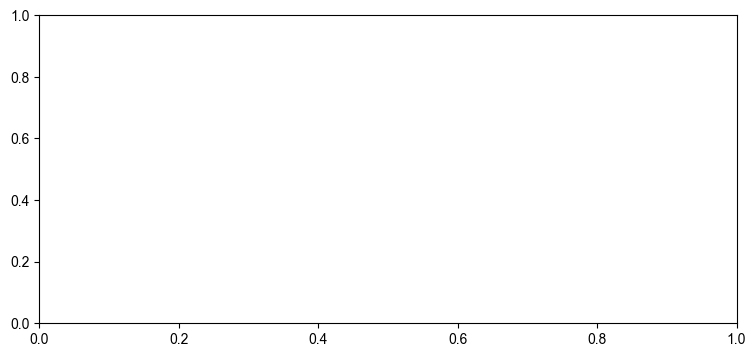

In [2726]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

for k, v in enumerate(bas):
    lof = v[0]
    gof = v[1]

    ax.boxplot(lof, positions=[k], showmeans=True, meanline=False)
    ax.boxplot(gof, positions=[k+0.25], showmeans=True, meanline=False)


# ax.set_title('Change in accuracy as KCNQ4 variants are added to train set', fontsize=fontsize_title)
ax.set_title('SH generalisation accuracy', fontsize=fontsize_title)
# ax.set_title('KCNQ4 generalisation accuracy', fontsize=fontsize_title)
ax.set_ylabel('Accuracy', fontsize=fontsize_label)
ax.set_xlabel('Number of variants from each class added to train set', fontsize=fontsize_label)

ax.get_xticklabels()

temp = []
temp_ticks = []
for i, v in enumerate(runs.keys()):
    temp.extend(['lof', f'\n\n{v}', 'gof'])
    temp_ticks.extend([i, i+0.12, i+0.25])
ax.set_xticks(temp_ticks)
ax.set_xticklabels(temp, ha='center')


ax.tick_params(axis='x', which='both',length=0)

ax.set_ylim([-0.05, 1.05])

# plt.savefig('../Figures/figure_3_kcnq4_generalisation.svg', bbox_inches='tight')
plt.show()

In [2727]:
idxs = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
idx = 0
d = defaultdict(list)
for k, v in enumerate(bas):
    lof = v[0]
    gof = v[1]
    for l in lof:
        d['Accuracy'].append(l)
        d['Amount of training samples'].append(idxs[idx])
        d['class'].append('lof')
    for g in gof:
        d['Accuracy'].append(g)
        d['Amount of training samples'].append(idxs[idx])
        d['class'].append('gof')
    
    idx += 1

d = pd.DataFrame.from_dict(d)

sns.lineplot(
    data=d, 
    x='Amount of training samples', 
    y='Accuracy', 
    hue='class',
    errorbar=('se', 1)  # Specify 'sd' to use custom standard deviations
)

IndexError: invalid index to scalar variable.

---


### Group Fold

    Use each gene as a test set during kfold



---

In [67]:
runs = {
    'ESM BF': 'group_fold_esm100_bf',
    'ESM BF GO': 'group_fold_esm100_bf_go',
}

runs = {
    # 'ESM BF': 'group_fold_esm100_bf_all',  # can also remove _all  # ce_loss with class-weights, 
    'esm mwt go fl': 'group_fold_esm_mwt_go_fl',
    # 'esm bf': 'group_fold_esm_sim_matrix',
    'esm norm only':  'group_fold_esm_minus_wt',
    # 'esm norm bf fl': 'group_fold_esm_minus_wt_bf_fl',
    # 'esm norm bf': 'group_fold_esm_minus_wt_bf',
    # 'esm mwt bf go fl': 'group_fold_esm_mwt_bf_go_fl',
    # 'attn': 'test',
    # 'attn': 'group_fold_attn_bf_fl_mwt',
    # 'attn mask': 'group_fold_attn_with_mask_bf',
    # 'esm bf go hpo': 'group_fold_esm100_bf_go_hpo',
    # 'ESM BF GO': 'group_fold_esm100_bf_go_all',
    # 'esm no cw no l2': 'group_fold/no_cw_no_l2',
    # 'mtl esm': 'group_fold_mtl_matrix',
    # 'no cw': 'group_fold_no_class_weight',
    # 'hpo': 'group_fold_esm100_bf_hpo_all',
    # '(svm)MTL': 'group_fold_mtl_no_uncommon',
    # '(svm)MKL': 'group_fold_mkl',
    # '(svm)MTL logistic': 'group_fold_lr',
    '(svm)MTL': 'group_fold',
}

runs = {
    'ESM BF': 'group_fold_esm100_bf_all', # cross entropy with class weights
    'ESM BF GO': 'group_fold_esm100_bf_go_all', # cross entropy with class weights
    '(svm)MTL': 'group_fold',
}

runs = {
    # 'esm norm': 'group_fold_esm_norm_fl', 
    # 'esm norm2': 'group_fold_test',
    # 'norm id': 'group_fold_norm_id', # Variant minus wildtype with gene specific 2AA id
    # 'esm' : 'group_fold_esm_fl',
    # 'esm bf go fl': 'group_fold_esm100_bf_go_all',
    # 'esm norm': 'group_fold_fixed_norm_bug_bf_go_fl',
    # 'esm mwt go': 'group_fold_esm_mwt_go_fl',
    'MissION': 'group_fold_esm_bf_go_fl',
    # 'Ours': 'group_fold_go_only',
    # 'Ours': 'group_fold_esm_mwt_go_fl',
    # 'norm bf go fl': 'group_fold_fixed_norm_bug_bf_go_fl',
    # 'esm mwt ce':  'group_fold_esm_minus_wt', # ce loss
    '(svm)MTL': 'group_fold',
}

for k, v in runs.items():
    if 'svm' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

> load_run :: 0.780 sec
> load_run :: 0.031 sec


In [87]:
for i in range(len(x)):
    print(x[i].varids[0][0].split('_')[0], x[i].get_best_epoch())

SCN1A 0
SCN5A 0
KCNQ2 10
Sh 4
SCN8A 0
KCNQ1 3
SCN2A 1
CACNA1S 0
SCN4A 4
CACNA1A 4
CACNA1C 14
KCNH2 4
KCNA1 4
CACNA1F 10
SCN9A 8
CACNA1D 3
KCNQ4 9
KCND2 3
KCNA2 0
KCNJ2 2
KCNB1 1
KCND3 13
KCNQ3 5
CACNA1E 10
SCN3A 15
KCNH1 0
KCNJ11 0
KCNA5 0
HCN2 5
KCNJ10 4
SCN10A 10
SCN11A 15
KCNK3 1
KCNC3 3
KCNC1 2
KCNJ1 17
KCNN4 17
KCNJ8 2
KCNT1 18
KCNJ3 18
KCNMA1 16
KCNA4 9
KCNJ5 19
KCNQ5 19
KCNH5 3
KCNK17 0
KCNC2 0


In [95]:
x = runs['MissION']
x[1].preds.shape
epoch = x[1].get_best_epoch()

# for epoch in range(20):
#     p = x[1].preds[epoch] # 597, 2
#     p = np.argmax(p, 1)
#     p
    
#     l = x[1].labels[epoch]
#     l = np.argmax(l, 1)
    
#     print(sum(l == p)/len(l))

ass = []
for i in range(len(x)):
    a = []
    for epoch in range(20):
        p = x[i].preds[epoch] # 597, 2
        p = np.argmax(p, 1)
        p
        
        l = x[i].labels[epoch]
        l = np.argmax(l, 1)
        
        # print(sum(l == p)/len(l))
        a.append(sum(l==p)/len(l))
    ass.append(a)

ass = np.array(ass)
ass = np.mean(ass, 0)
print(ass.shape)

ass

(20,)


array([0.61551948, 0.59330852, 0.60630324, 0.62725482, 0.59905624,
       0.60110859, 0.60467457, 0.58832647, 0.60339936, 0.58452138,
       0.58857828, 0.60415602, 0.55377367, 0.5825078 , 0.57793655,
       0.59868201, 0.56932334, 0.60252885, 0.62305125, 0.55719415])

In [54]:
def load_run_random(path: str, svm: bool = False, df: pd.DataFrame=None) -> list[Fold]:

    if svm:
        df = pd.read_parquet(f"../Experiments/svm/Log/{path}/output.parquet")
        folds: list[Fold] = main2.create_dataset_svm(df)
    else:
        # df = pd.read_parquet(f"../Log/{path}/output.parquet")
        folds: list[Fold] = main2.create_dataset(df)
    return folds

def generate_fake(path, df=None):
    if df is None:
        df = pd.read_parquet(f'../Log/{path}/output.parquet')
    # print(df)
    # pred = np.stack(df['pred'])
    pred = np.stack(df['pred'])
    # print(pred.shape)

    # pred = np.exp(pred) / np.sum(np.exp(pred), 1, keepdims=True)
    
    pred_lof = pred[:, 0]
    pred_gof = pred[:, 1]
    # print(np.mean(pred_lof), np.std(pred_lof))
    # print(np.mean(pred_gof), np.std(pred_gof))

    # new_gof = np.random.normal(np.mean(pred_gof), np.std(pred_gof), size=pred_gof.shape[0])
    new_gof = np.random.uniform(0, 1, size=pred_gof.shape[0])
    new_lof = 1 - new_gof

    # print(new_gof.shape)
    # print(new_lof.shape)
    # print(new_gof)
    # print(new_lof)

    new_pred = np.zeros_like(pred)
    new_pred[:, 0] = new_lof
    new_pred[:, 1] = new_gof
    new_pred = list(new_pred)
    df['pred'] = new_pred
    return load_run_random('null', False, df)
    

# runs['Random'] = generate_fake('group_fold_esm_bf_go_fl')

In [55]:
AVERAGE = 'weighted'

# Computes a metric for group-fold runs where each fold only holds predictions for a single gene
def compute_ba(folds: List[Fold], ax: plt.axes, name: str, positions: List[int]):
    bas = []
    acc_lofs = []
    acc_gofs = []
    genes = []
    for ii, fold in enumerate(folds):
        ba = []
        acc_lof = []
        acc_gof = []
        genes.append(fold.varids[0][0].split('_')[0])
        for epoch in range(fold.preds.shape[0]):
            p = fold.preds[epoch]
            l = fold.labels[epoch]
    
            p = np.argmax(p, 1)
            l = np.argmax(l, 1)

            # p = np.append(p, [1, 1, 0, 1])
            # l = np.append(l, [0, 1, 0, 0])
            
            # ba.append(sum(p == l)/len(p))
            # ba.append(f1_score(l, p, average='binary', pos_label=1, labels=[0, 1], zero_division=0.0))
            ba.append(f1_score(l, p, average=AVERAGE, labels=[0, 1], zero_division=np.nan))
            # ba.append(f1_score(l, p))
            # ba.append(balanced_accuracy_score(l, p))

        best_epoch = fold.get_best_epoch()
        # best_epoch = np.argmax(ba)
        bas.append(ba[best_epoch])

    return bas, genes

def compute_ba_svm(folds: list[Fold]):
    bas = []
    genes = []
    for ii, fold in enumerate(folds):
        genes.append(fold.varids[0].split('_')[0])
        p = fold.preds[0]
        l = fold.labels[0]

        p = (p > 0.0).astype(int)

        # bas.append(sum(p == l) / len(p))
        # bas.append(f1_score(l, p, average='binary', pos_label=1, labels=[0, 1], zero_division=0.0))
        bas.append(f1_score(l, p, average=AVERAGE, labels=[0, 1], zero_division=np.nan))


    return bas, genes

In [56]:
def compute_metric_svm(folds: List[Fold], name: str, metric='f1', average='weighted'):
    scores = []
    genes = []
    for fold_idx, fold in enumerate(folds):
        genes.append(fold.varids[0].split('_')[0])
        be = 0
        p = fold.preds[be]
        l = fold.labels[be]
        p = (p > 0).astype(int)
        if 'random' in name:
            p = np.random.randint(2, size=p.shape[0])
        if metric == 'f1':
            score = f1_score(l, p, average=average, labels=[0, 1], pos_label=1, zero_division=np.nan)
        elif metric == 'acc':
            score = accuracy_score(l, p)
        elif metric == 'ba':
            score = balanced_accuracy_score(l, p)
        else: 
            raise Exception('unsupported metric')
        scores.append(score)
    return scores, genes
    
def compute_metric(folds: List[Fold], name: str, metric='f1', average='weighted'):
    scores = []
    genes = []
    for fold_idx, fold in enumerate(folds):
        genes.append(fold.varids[0][0].split('_')[0])
        be = fold.get_best_epoch()
        preds = fold.preds[be]
        labels = fold.labels[be]
        l = np.argmax(labels, 1)
        p = np.argmax(preds, 1)
        if 'random' in name.lower():
            p = np.random.randint(2, size=p.shape[0])
        if metric == 'f1':
            score = f1_score(l, p, average=average, labels=[0, 1], pos_label=1, zero_division=np.nan)
        elif metric == 'acc':
            score = accuracy_score(l, p)
        elif metric == 'ba':
            score = balanced_accuracy_score(l, p)
        else: 
            raise Exception('unsupported metric')
        scores.append(score)
    return scores, genes

In [57]:
random_model_scores = []
df_for_fake = pd.read_parquet(f'../Log/group_fold_esm_bf_go_fl/output.parquet')
for i in range(10):
    # runs['random'] = generate_fake('group_fold_esm_bf_go_fl')
    runs['Random'] = generate_fake(None, df_for_fake)
    bas, genes = compute_metric(runs['Random'], 'Random', metric='acc', average='weighted')
    random_model_scores.append(bas)
    print(f"{i:02}: {np.nanmean(bas):.3f}")

00: 0.442
01: 0.528
02: 0.490
03: 0.537
04: 0.441
05: 0.438
06: 0.499
07: 0.543
08: 0.482
09: 0.475


In [58]:
def analyze_score_distribution(observed_scores, random_scores, alpha=0.05):
    """
    Analyze whether observed scores are significantly different from randomly generated scores.
    
    Parameters:
    observed_scores: array-like of shape (45,)
        The actual observed scores
    random_scores: array-like of shape (n_samples, 45)
        Matrix of randomly generated scores
    alpha: float
        Significance level for statistical tests
        
    Returns:
    dict containing test results and summary statistics
    """
    results = {}
    
    # 1. Kolmogorov-Smirnov test for each position
    ks_results = []
    for i in range(observed_scores.shape[0]):
        statistic, pvalue = stats.ks_2samp(
            observed_scores[i:i+1],
            random_scores[:, i]
        )
        ks_results.append({
            'position': i,
            'statistic': statistic,
            'pvalue': pvalue,
            'significant': pvalue < alpha
        })
    
    # 2. Overall distribution comparison
    overall_ks_stat, overall_ks_pval = stats.ks_2samp(
        observed_scores,
        random_scores.flatten(),
        alternative = 'two-sided'
    )
    
    # 3. Calculate summary statistics
    observed_mean = np.mean(observed_scores)
    observed_std = np.std(observed_scores)
    random_means = np.mean(random_scores, axis=0)
    random_stds = np.std(random_scores, axis=0)
    
    # 4. Calculate z-scores for each position
    z_scores = (observed_scores - np.mean(random_scores, axis=0)) / np.std(random_scores, axis=0)
    
    # Store results
    results['ks_test_by_position'] = ks_results
    results['overall_ks_test'] = {
        'statistic': overall_ks_stat,
        'pvalue': overall_ks_pval,
        'significant': overall_ks_pval < alpha
    }
    results['summary_stats'] = {
        'observed_mean': observed_mean,
        'observed_std': observed_std,
        'random_mean': np.mean(random_means),
        'random_std': np.mean(random_stds)
    }
    results['z_scores'] = z_scores
    
    return results

def plot_distributions(observed_scores, random_scores):
    """
    Create visualization comparing observed vs random score distributions
    """
    plt.figure(figsize=(12, 4.8))
    
    # # Plot overall distributions
    # plt.subplot(121)
    # plt.hist(random_scores.flatten(), bins=30, alpha=0.5, label='Random', density=True)
    # plt.hist(observed_scores, bins=30, alpha=0.5, label='Observed', density=True)
    # plt.title('Overall Score Distributions')
    # plt.legend()
    
    # Plot position-wise comparison
    # plt.subplot(122)
    positions = np.arange(len(observed_scores))
    plt.errorbar(positions, np.mean(random_scores, axis=0), 
                yerr=np.std(random_scores, axis=0),
                fmt='o', alpha=0.5, label='Random (mean ± std)')
    plt.plot(positions, observed_scores, 'r.', label='Observed')
    plt.title('Gene-wise Comparison', fontsize=18)
    plt.legend()

    plt.xticks(np.arange(len(genes)), labels=genes_sorted)
    plt.tick_params(axis='x', rotation=90)

    plt.ylabel(f"F1-score {AVERAGE}", fontsize=fontsize_label)
    plt.grid(linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    return plt.gcf()

In [59]:
# scores_mean = [np.nanmean(i) for i in scores]
# scores_std = [np.std(i) for i in scores]

# plt.figure()
# plt.hist(scores_mean)
# plt.hist(scores_std)

from scipy.stats import ranksums

Y, genes = compute_metric(runs['Ours'], 'Ours', 'acc')
Y_svm, genes_svm = compute_metric_svm(runs['(svm)MTL'], 'mtl', 'acc')
print(genes)

def sort_gene_results(scores, labels, sorted_labels):

    label_to_score = dict(zip(labels, scores))
    
    # Create new list of scores in the order of sorted_labels
    sorted_scores = [label_to_score[label] for label in sorted_labels]
    
    return sorted_scores

def sort2(scores, labels, sorted_labels):
    idxs = []
    for l in sorted_labels:
        idx = labels.index(l)
        idxs.append(idx)
    scores = np.array(scores)
    return scores[:, idxs]

def filter_(scores, sorted_labels):
    out = ['KCNA4', 'KCNC1', 'KCNC2', 'KCNH5', 'KCNJ1', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK17', 'KCNMA1', 'KCNN4', 'KCNQ5', 'KCNT1']
    idxs = []
    for i, l in enumerate(sorted_labels):
        if l not in out:
            idxs.append(i)
    scores = np.array(scores)
    if scores.ndim == 1:
        scores = scores[None, :]
    return scores[:, idxs]

X, _ = compute_metric(runs['Random'], 'random', 'acc')

X2 = sort2(random_model_scores, genes, genes_sorted)
Y = sort_gene_results(Y, genes, genes_sorted)

fig = plot_distributions(Y, X2)# np.array(scores))

print(ranksums(Y, X, alternative='two-sided'))
print(ranksums(Y, X, alternative='greater'))
print(ranksums(Y, X, alternative='less'))

analyze_score_distribution(np.array(Y), np.array(X2))['overall_ks_test']
plt.show()
# save_fig(fig, f'group_fold_gene_wise_f1_comparison', fig_dir='.', fig_fmt='pdf', fig_size=(12, 4.8))

['SCN1A', 'SCN5A', 'KCNQ2', 'Sh', 'SCN8A', 'KCNQ1', 'SCN2A', 'CACNA1S', 'SCN4A', 'CACNA1A', 'CACNA1C', 'KCNH2', 'KCNA1', 'CACNA1F', 'SCN9A', 'CACNA1D', 'KCNQ4', 'KCND2', 'KCNA2', 'KCNJ2', 'KCNB1', 'KCND3', 'KCNQ3', 'CACNA1E', 'SCN3A', 'KCNH1', 'KCNJ11', 'KCNA5', 'HCN2', 'KCNJ10', 'SCN10A', 'SCN11A', 'KCNK3', 'KCNC3', 'KCNC1', 'KCNJ1', 'KCNN4', 'KCNJ8', 'KCNT1', 'KCNJ3', 'KCNMA1', 'KCNA4', 'KCNJ5', 'KCNQ5', 'KCNH5', 'KCNK17', 'KCNC2']


NameError: name 'genes_sorted' is not defined

In [60]:
Y_svm = sort_gene_results(Y_svm, genes_svm, genes_sorted)


for i in ['less', 'greater', 'two-sided']:
    overall_ks_stat, overall_ks_pval = stats.ks_2samp(
        Y,
        X2.flatten(),
        # np.mean(X2, 0),
        alternative = i
    )
    rs_stat, rs_pval = stats.ranksums(Y, X2.flatten(), alternative=i)
    
    # print(f"{i} {overall_ks_stat:.5f} {overall_ks_pval:.10f} | ranksum: {rs_stat:.3f} {rs_pval:.10f}")
    print(f"Ours {i} {overall_ks_stat:.5f} {overall_ks_pval:.10f} {rs_stat:.3f} {rs_pval:.10f}")
print()
for i in ['less', 'greater', 'two-sided']:
    overall_ks_stat, overall_ks_pval = stats.ks_2samp(
        Y_svm,
        X2.flatten(),
        # np.mean(X2, 0),
        alternative = i
    )
    rs_stat, rs_pval = stats.ranksums(Y_svm, X2.flatten(), alternative=i)
    
    print(f"MTL {i} {overall_ks_stat:.5f} {overall_ks_pval:.10f} | ranksum: {rs_stat:.3f} {rs_pval:.10f}")


NameError: name 'genes_sorted' is not defined

(47,)
(47,)
./pdf/group_fold_vs_random_model.pdf


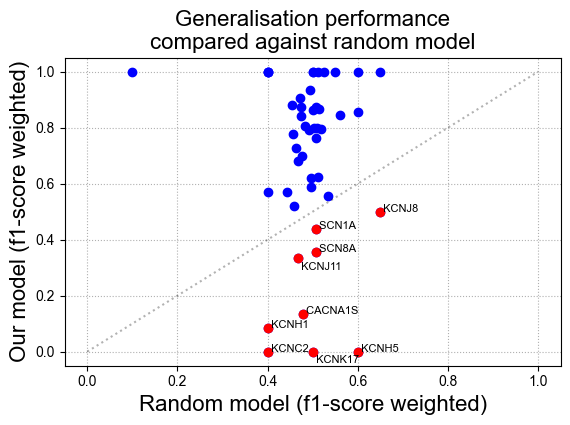

In [61]:
A = np.mean(random_model_scores, 0)
Y = np.array(Y)
print(A.shape)
print(Y.shape)

scores_mean = np.mean(random_model_scores, 0)

fig = plt.figure(figsize=(6.4, 4))
plt.scatter(scores_mean, np.array(Y), color='b')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.plot(np.linspace(0, 1, 10), np.linspace(0,1, 10), linestyle=':', color='k', alpha=0.3)
plt.grid(linestyle=':')

worse = []
for i in range(len(Y)):
    if Y[i] <= scores_mean[i]:
        worse.append(i)
        # plt.text(scores_mean[i], Y[i], genes[i], fontsize=7)



labels = genes
# Simple manual adjustment technique
texts = []
for i, (xi, yi, label) in enumerate(zip(scores_mean, Y, labels)):
    if xi >= yi:
        texts.append(plt.text(xi, yi, f" {label}", fontsize=8))

# Simple collision detection and adjustment
margin = 0.04  # minimum distance between labels
for i, text1 in enumerate(texts):
    bbox1 = text1.get_window_extent(renderer=fig.canvas.get_renderer())
    for j, text2 in enumerate(texts[i+1:], i+1):
        bbox2 = text2.get_window_extent(renderer=fig.canvas.get_renderer())
        
        if bbox1.overlaps(bbox2):
            # Move text2 down slightly
            text2_pos = text2.get_position()
            text2.set_position((text2_pos[0], text2_pos[1] - margin))



plt.scatter(scores_mean[worse], np.array(Y)[worse], color='r')
plt.title('Generalisation performance\ncompared against random model', fontsize=16)
plt.xlabel(f'Random model (f1-score {AVERAGE})', fontsize=fontsize_label)
plt.ylabel(f'Our model (f1-score {AVERAGE})', fontsize=fontsize_label)

save_fig(fig, f'group_fold_vs_random_model', fig_dir='.', fig_fmt='pdf', fig_size=(6.4, 4))

plt.show()

In [62]:
genes_sorted = ['CACNA1A', 'CACNA1C', 'CACNA1D', 'CACNA1E', 'CACNA1F', 'CACNA1S', 'KCNA1', 'KCNA2', 'KCNA4', 'KCNA5', 'KCNB1', 'KCNC1', 'KCNC2', 'KCNC3', 'KCND2', 'KCND3', 'KCNH1', 'KCNH2', 'KCNH5', 'KCNJ1', 'KCNJ10', 'KCNJ11', 'KCNJ2', 'KCNJ3', 'KCNJ5', 'KCNJ8', 'KCNK3', 'KCNK17', 'KCNMA1', 'KCNN4', 'KCNQ1', 'KCNQ2', 'KCNQ3', 'KCNQ4', 'KCNQ5', 'KCNT1', 'SCN1A', 'SCN2A', 'SCN3A', 'SCN4A', 'SCN5A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'HCN2', 'Sh']
df = pd.read_csv('../merged.csv')
temp = []
for g in genes_sorted:
    i = df.loc[df['gene'] == g].shape[0]
    x = f"({i}) {g}"
    temp.append(x)
genes_sorted_count = temp

In [78]:
def custom_fmt(val):
    # return '{:.0f}'.format(val) if val == 1.000 or val == 0.000 else f'.{val*100:.0f}' #'{:.2f}'.format(val)
    if val == 0 or val == 1:
        return f'{val:.0f}'
    else:
        # return f'.{x:.0f}'
        return f'.{f"{val:.02f}".split(".")[1]}'


print(custom_fmt(0.00))
print(custom_fmt(1.00))
print(custom_fmt(0.87))
print(custom_fmt(0.0833))

0
1
.87
.08


./png/group_fold_f1_accuracy.png


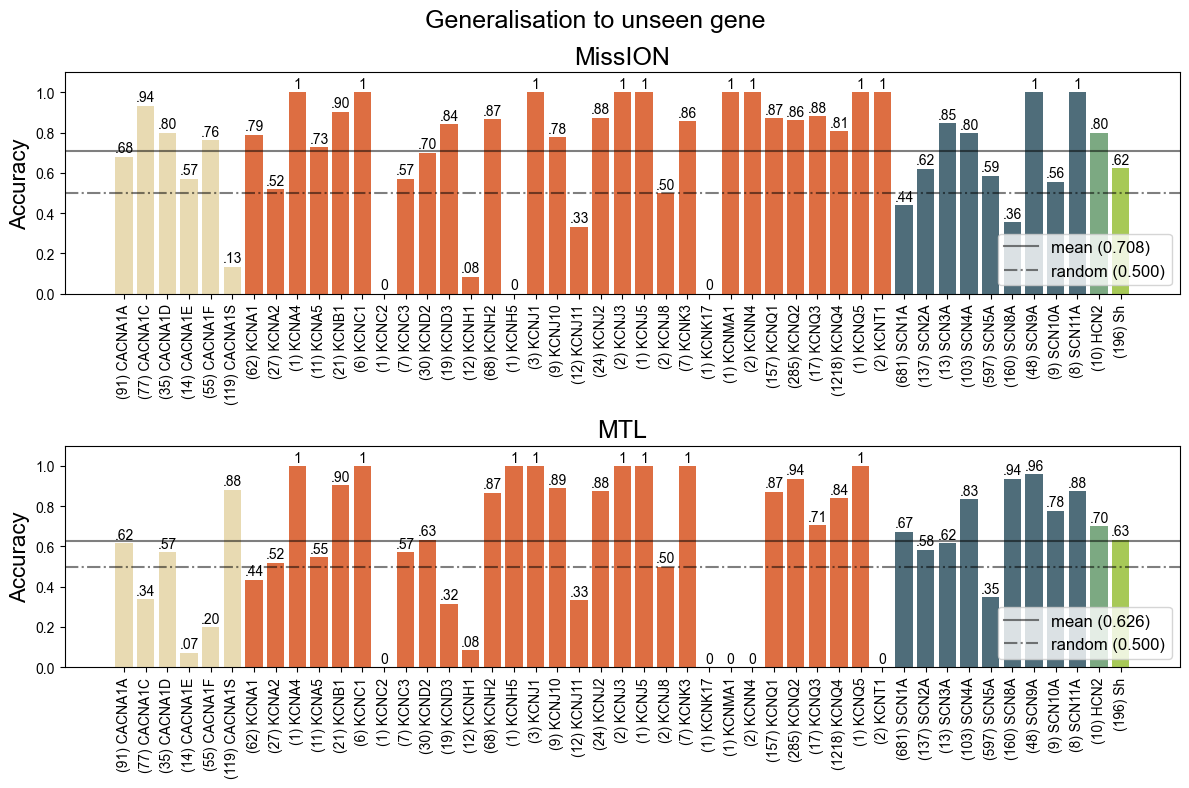

In [88]:
# runs['Random'] = generate_fake(None, df_for_fake)
if 'Random' in runs.keys():
    del runs['Random']
# fig, ax = plt.subplots(3, 1, figsize=(12, 12))
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax = ax.flatten()

def custom_fmt(val):
    # return '{:.0f}'.format(val) if val == 1.000 or val == 0.000 else f'.{val*100:.0f}' #'{:.2f}'.format(val)
    if val == 0 or val == 1:
        return f'{val:.0f}'
    else:
        # return f'.{x:.0f}'
        return f'.{f"{val:.02f}".split(".")[1]}'

colors = ['#dd6e42', '#e8dab2', '#4f6d7a', '#a7c957', '#7ca982']

idx = 0
bas_ls =[]
genes_ls = []
rect_ls = []
for k, v in runs.items():
    if 'svm' in k:
        # bas, genes = compute_ba_svm(v)
        bas, genes = compute_metric_svm(v, k, 'acc', 'binary')
    else:
        # bas, genes = compute_ba(v, ax[0], k, 0)
        bas, genes = compute_metric(v, k, 'acc', 'binary')
    bas_ls.append(bas)
    genes_ls.append(genes)

    bas_new = []
    for gg in genes_sorted:
        g_idx = genes.index(gg)
        bas_new.append(bas[g_idx])
    bas = bas_new
    genes = genes_sorted

    ax[idx].axhline(y=np.nanmean(bas), color='k', label=f'mean ({np.nanmean(bas):.3f})', alpha=0.5, linestyle='-')

    ## Random model performance line
    # ax[idx].axhline(y=np.nanmean(random_model_scores, (0, 1)), color='k', linestyle='-.', label=f"random ({np.nanmean(random_model_scores, (0, 1)):.3f})", alpha=0.5)
    ax[idx].axhline(y=0.5, color='k', linestyle='-.', label=f"random (0.500)", alpha=0.5)

    cs = []
    for gg in genes:
        if 'KCN' in gg:
            color = colors[0]
        elif 'CACNA' in gg:
            color = colors[1]
        elif 'SCN' in gg:
            color = colors[2]
        elif 'Sh' in gg:
            color = colors[3]
        else:
            color = colors[4]
        cs.append(color)
    
    
    # rects = ax[idx].bar(np.arange(len(genes)), bas, color='darkcyan')
    rects = ax[idx].bar(np.arange(len(genes)), bas, color=cs)
    ax[idx].bar_label(rects, padding=1, fmt=custom_fmt)
    rect_ls.append(rects.datavalues)
    # ax[idx].set_ylabel(f'F1-score ({AVERAGE})', fontsize=fontsize_label)
    ax[idx].set_ylabel(f'Accuracy', fontsize=fontsize_label)
    ax[idx].set_title(k.replace('(svm)', ''), fontsize=fontsize_title)
    
    ax[idx].set_xticks(np.arange(len(genes)))
    ax[idx].set_xticklabels(genes_sorted_count, ha='center')
    ax[idx].tick_params(axis='x', rotation=90)
    ax[idx].legend(loc=4, fontsize=fontsize_legend)
    # ax[idx].spines[['top', 'right']].set_visible(False)

    # ax[idx].set_yticklabels([0, 20, 40, 60, 80, 100, 120])
    
    ax[idx].set_ylim([0, 1.1])
    idx += 1

plt.suptitle('Generalisation to unseen gene', fontsize=fontsize_title)
plt.tight_layout()

# plt.savefig('../Figures/temp/gene_fold.svg', bbox_inches='tight')
# save_fig(fig, f'group_fold_f1_{AVERAGE}', fig_dir='.', fig_fmt='pdf', fig_size=(12, 8))
# save_fig(fig, f'group_fold_f1_accuracy', fig_dir='.', fig_fmt='pdf', fig_size=(12, 8))

plt.show()

In [876]:
def f(rect):
    agg = []
    for idx, g in enumerate(genes_sorted_count):
        c = g.split(' ')[0].replace('(', '').replace(')', '')
        c = int(c)
        # if c == 1:
        # if c > 100:
        if c < 15:
            agg.append(rect[idx])
    return agg

for i in rect_ls:
    temp = f(i)
    print(np.mean(temp))

nan
nan


[0.49041735 0.18132803]


IndexError: list index out of range

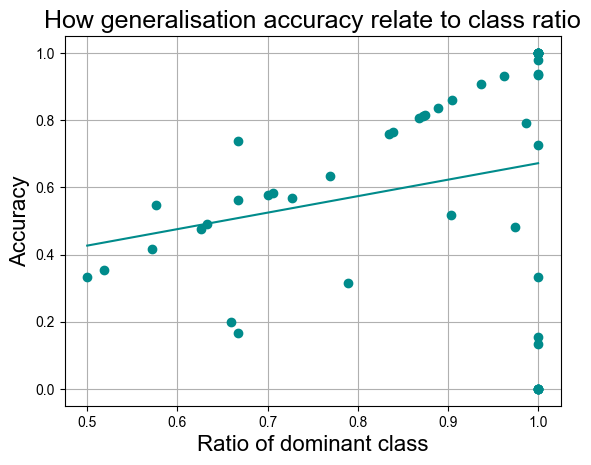

In [2472]:
def acc_by_ratio(bas: list[int], genes: list[str]):
    df = pd.read_csv('/home/sean/Arto_Annotations/Tables/Latest_VerifiedVariants.tsv', sep='\t')
    df = df.loc[df['netChange'] != 'neutral']

    ratios = []
    count = []
    ams = []
    for ii, g in enumerate(genes):
        # df = df.loc[df['gene'] == g][['VarID', 'netChange']]
        lof = df.loc[(df['gene'] == g) & (df['netChange'] == 'lof')].shape[0]
        gof = df.loc[(df['gene'] == g) & (df['netChange'] == 'gof')].shape[0]
        
        both = [lof, gof]
        am = np.argmax(both)
        ratio = both[am] / (sum(both))
        ratios.append(ratio)
        count.append(sum(both))
        # count.append(both[am])
        ams.append(am)
    return ratios, count, ams

bas = bas_ls[1]
genes = genes_ls[1]
ratios, counts, ams = acc_by_ratio(bas, genes)


dof = 1

plt.figure()

ams = np.array(ams)  # 0 if lof dominant, 1 if gof dominant
ratios = np.array(ratios)
counts = np.array(counts)
bas = np.array(bas)
# plt.scatter(ratios[np.where(ams == 0)[0]], bas[np.where(ams == 0)[0]], s=counts[np.where(ams == 0)[0]], c='firebrick')
# plt.scatter(ratios[np.where(ams == 1)[0]], bas[np.where(ams == 1)[0]], s=counts[np.where(ams == 1)[0]], c='darkcyan')
plt.scatter(ratios[np.where(ams == 0)[0]], bas[np.where(ams == 0)[0]], c='darkcyan')
plt.scatter(ratios[np.where(ams == 1)[0]], bas[np.where(ams == 1)[0]], c='darkcyan')

print(np.polyfit(ratios, bas, dof))
plt.plot(np.unique(ratios), np.poly1d(np.polyfit(ratios, bas, dof))(np.unique(ratios)), label='Ours', c='darkcyan')


plt.title('How generalisation accuracy relate to class ratio', fontsize=fontsize_title)
plt.ylabel('Accuracy', fontsize=fontsize_label)
plt.xlabel('Ratio of dominant class', fontsize=fontsize_label)
plt.grid()



bas = bas_ls[2]
genes = genes_ls[2]
ratios, counts, ams = acc_by_ratio(bas, genes)

ams = np.array(ams)  # 0 if lof dominant, 1 if gof dominant
ratios = np.array(ratios)
counts = np.array(counts)
bas = np.array(bas)
# plt.scatter(ratios[np.where(ams == 0)[0]], bas[np.where(ams == 0)[0]], s=counts[np.where(ams == 0)[0]], c='sandybrown', marker='s')
# plt.scatter(ratios[np.where(ams == 1)[0]], bas[np.where(ams == 1)[0]], s=counts[np.where(ams == 1)[0]], c='skyblue', marker='s')
plt.scatter(ratios[np.where(ams == 0)[0]], bas[np.where(ams == 0)[0]], c='darkorange')
plt.scatter(ratios[np.where(ams == 1)[0]], bas[np.where(ams == 1)[0]], c='darkorange')


print(np.polyfit(ratios, bas, dof))
plt.plot(np.unique(ratios), np.poly1d(np.polyfit(ratios, bas, dof))(np.unique(ratios)), label='MTL', c='darkorange')

plt.legend(fontsize=fontsize_label)

plt.savefig('../Figures/figure_3_group_ratio.png', bbox_inches='tight')
plt.show()

Text(0.0, 1.0, 'MTL')

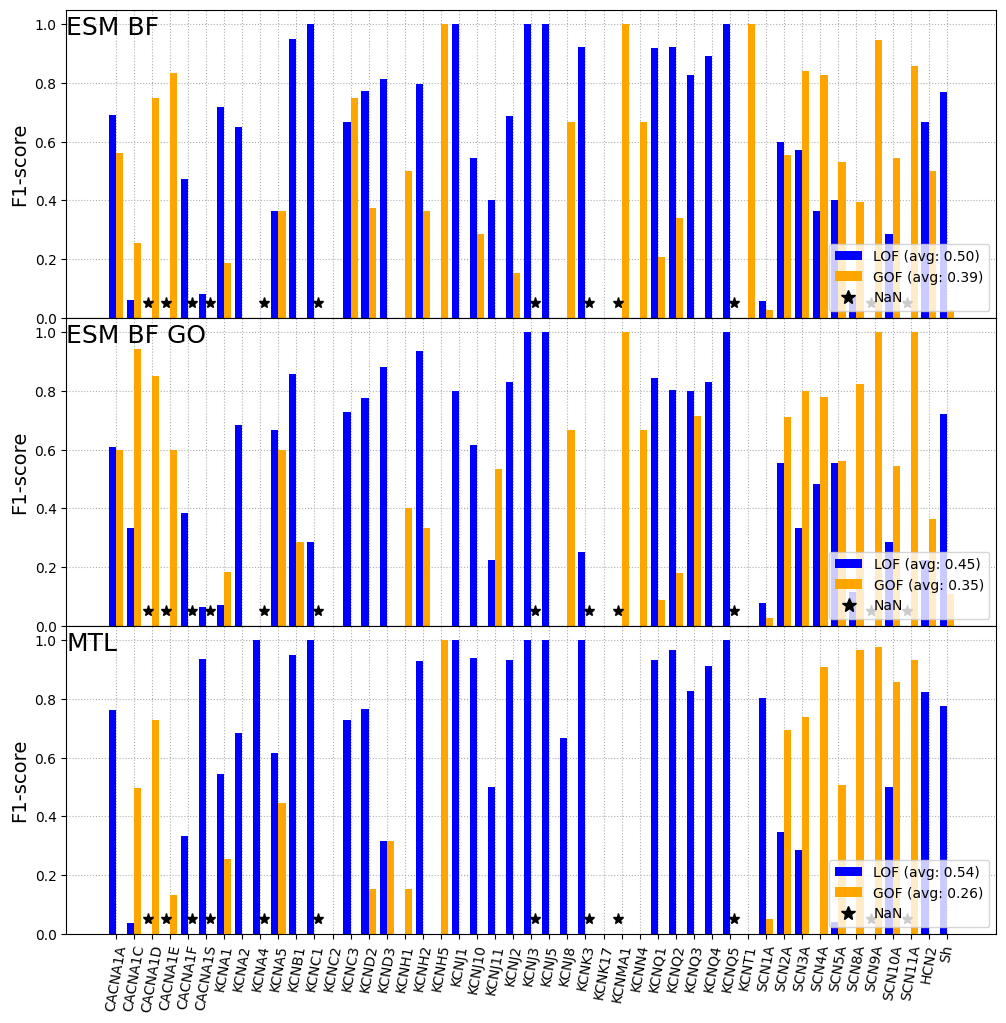

In [675]:

def compute_ba(folds: List[Fold], ax: plt.axes, name: str, positions: List[int]):
    bas = []
    acc_lofs = []
    acc_gofs = []
    genes = []
    for ii, fold in enumerate(folds):
        ba = []
        acc_lof = []
        acc_gof = []
        genes.append(fold.varids[0][0].split('_')[0])
        for epoch in range(fold.preds.shape[0]):
            p = fold.preds[epoch]
            l = fold.labels[epoch]
    
            p = np.argmax(p, 1)
            l = np.argmax(l, 1)

            # p = np.append(p, [1, 1, 0, 1])
            # l = np.append(l, [0, 1, 0, 0])
            
            # ba.append(sum(p == l)/len(p))
            ba.append(f1_score(l, p, average=None, labels=[0, 1], zero_division=np.nan))
            # ba.append(f1_score(l, p))
            # ba.append(balanced_accuracy_score(l, p))

        # best_epoch = np.argmax(ba)
        # bas.append(ba[best_epoch])
        bas.append(ba)
    bas = np.array(bas)
    bas = bas[:, 9, :]

    return bas, genes

def compute_ba_svm(folds: list[Fold]):
    bas = []
    genes = []
    for ii, fold in enumerate(folds):
        genes.append(fold.varids[0].split('_')[0])
        p = fold.preds[0]
        l = fold.labels[0]

        p = (p >= 0.0).astype(int)

        # bas.append(sum(p == l) / len(p))
        bas.append(f1_score(l, p, average=None, labels=[0, 1], zero_division=np.nan))
    bas = np.array(bas)
    return bas, genes

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax = ax.flatten()

def custom_fmt(val):
    return '{:.0f}'.format(val) if val == 1.000 or val == 0.000 else f'{val*100:.0f}' #'{:.2f}'.format(val)

idx = 0
bas_ls =[]
genes_ls = []
for k, v in runs.items():
    if 'svm' in k:
        bas, genes = compute_ba_svm(v)
    else:
        bas, genes = compute_ba(v, ax[0], k, 0)
    bas_ls.append(bas)
    genes_ls.append(genes)

    bas_new = []
    for gg in genes_sorted:
        g_idx = genes.index(gg)
        bas_new.append(bas[g_idx, :])
    bas = np.array(bas_new)
    genes = genes_sorted

    lofs = bas[:, 0]
    gofs = bas[:, 1]

    indices = np.arange(len(bas))
    b1 = ax[idx].bar(indices, lofs, width=bar_width, label=f'LOF (avg: {np.nanmean(lofs):.2f})', color='blue')
    b2 = ax[idx].bar(indices + bar_width, gofs, width=bar_width, label=f'GOF (avg: {np.nanmean(gofs):.2f})', color='orange')

    if idx == 2:
        ax[idx].set_xticks(np.arange(len(genes))+bar_width / 2)
        ax[idx].set_xticklabels(genes, ha='center', fontsize=10)
        ax[idx].tick_params(axis='x', rotation=80)
    else:
        ax[idx].set_xticks(np.arange(len(genes))+bar_width / 2)
        ax[idx].set_xticklabels([])
        # ax[idx].set_xticklabels(genes, ha='center', fontsize=6)
        # ax[idx].tick_params(axis='x', rotation=80)

    for i in range(len(v1)):
        if np.isnan(v1[i]):
            ax[idx].plot(indices[i], 0.05, 'k*', markersize=8)  # Red star at the base
        if np.isnan(v2[i]):
            ax[idx].plot(indices[i] + bar_width, 0.05, 'k*', markersize=8)

    star_marker = Line2D([0], [0], marker='*', color='k', markersize=10, linestyle='None', label='NaN')

    # ax.legend()
    ax[idx].legend(handles=[b1, b2, star_marker], fontsize=10, loc=4)
    ax[idx].grid(linestyle='dotted')
    # ax[idx].set_title('Per class f1-score', fontsize=18)
    ax[idx].set_ylabel('F1-score', fontsize=14)
    idx += 1

fig.subplots_adjust(hspace=0.0)
ax[0].set_title("ESM BF", loc='left', y=1.0, pad=-18, fontsize=18)
ax[1].set_title("ESM BF GO", loc='left', y=1.0, pad=-18, fontsize=18)
ax[2].set_title("MTL", loc='left', y=1.0, pad=-18, fontsize=18)

## Cut size comparison

    How many columns we take around the mutation column in the embeddings

In [41]:
runs = {
    '5': 'cut_size2/esm5',
    '10': 'cut_size2/esm10',
    '20': 'cut_size2/esm20',
    '50': 'cut_size2/esm50',
    '100': 'cut_size2/esm100',
    '200': 'cut_size2/esm200',
    '300': 'cut_size2/esm300',
    '400': 'cut_size2/esm400',
    '500': 'cut_size2/esm500',
    # 'msa': 'msa_only',
}

runs2 = {
    '5': 'cut_size/esm5',
    '10': 'cut_size/esm10',
    '20': 'cut_size/esm20',
    '50': 'cut_size/esm50',
    '100': 'cut_size/esm100',
    '200': 'cut_size/esm200',
    '300': 'cut_size/esm300',
    '400': 'cut_size/esm400',
    '500': 'cut_size/esm500',
}
runs2 = {
    '1': 'cut_size3/esm1',
    '5': 'cut_size3/esm5',
    '10': 'cut_size3/esm10',
    # '20': 'cut_size/esm20',
    '50': 'cut_size3/esm50',
    '100': 'cut_size3/esm100',
    '200': 'cut_size3/esm200',
    '300': 'cut_size3/esm300',
    '400': 'cut_size3/esm400',
    '500': 'cut_size3/esm500',
}

for k, v in runs.items():
    if 'svm' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs2.items():
    if 'svm' in k:
        runs2[k] = load_run(v, svm=True)
    else:
        runs2[k] = load_run(v)

> load_run :: 0.325 sec
> load_run :: 0.287 sec
> load_run :: 0.285 sec
> load_run :: 0.277 sec
> load_run :: 0.276 sec
> load_run :: 0.277 sec
> load_run :: 0.290 sec
> load_run :: 0.277 sec
> load_run :: 0.298 sec
> load_run :: 0.279 sec
> load_run :: 0.274 sec
> load_run :: 0.335 sec
> load_run :: 0.298 sec
> load_run :: 0.332 sec
> load_run :: 0.289 sec
> load_run :: 0.309 sec
> load_run :: 0.283 sec
> load_run :: 0.293 sec


In [42]:
def compute_ba(folds: List[Fold], name: str, positions: List[int]):
    bas = []
    acc_lofs = []
    acc_gofs = []
    genes = []
    for ii, fold in enumerate(folds):
        ba = []
        score = []
        acc_lof = []
        acc_gof = []
        genes.append(fold.varids[0][0].split('_')[0])
        for epoch in range(fold.preds.shape[0]):
            p = fold.preds[epoch]
            l = fold.labels[epoch]
    
            p = np.argmax(p, 1)
            l = np.argmax(l, 1)

            # p = np.append(p, [1, 1, 0, 1])
            # l = np.append(l, [0, 1, 0, 0])
            
            # ba.append(sum(p == l)/len(p))
            # ba.append(f1_score(l, p, average='weighted', labels=[0, 1], zero_division=0.0))
            # ba.append(f1_score(l, p))
            # ba.append(balanced_accuracy_score(l, p))
            score.append(f1_score(l, p, average='weighted', labels=[0, 1], zero_division=0.0))
            # score.append(f1_score(l, p, average='binary', pos_label=0, labels=[0, 1], zero_division=0.0))

        # best_epoch = np.argmax(ba)
        best_epoch = np.argmax(score)
        bas.append(score[best_epoch])

    return bas, genes

def compute_metric(folds: List[Fold], name: str, metric='f1', average='weighted'):
    scores = []
    genes = []
    for fold_idx, fold in enumerate(folds):
        genes.append(fold.varids[0][0].split('_')[0])
        be = fold.get_best_epoch()
        preds = fold.preds[be]
        labels = fold.labels[be]
        l = np.argmax(labels, 1)
        p = np.argmax(preds, 1)
        if 'random' in name.lower():
            p = np.random.randint(2, size=p.shape[0])
        if metric == 'f1':
            score = f1_score(l, p, average=average, labels=[0, 1], pos_label=1, zero_division=np.nan)
        elif metric == 'acc':
            score = accuracy_score(l, p)
        elif metric == 'ba':
            score = balanced_accuracy_score(l, p)
        else: 
            raise Exception('unsupported metric')
        scores.append(score)
    return scores, genes

In [43]:
scores_ls = []

./pdf/cut_sizes_final.pdf


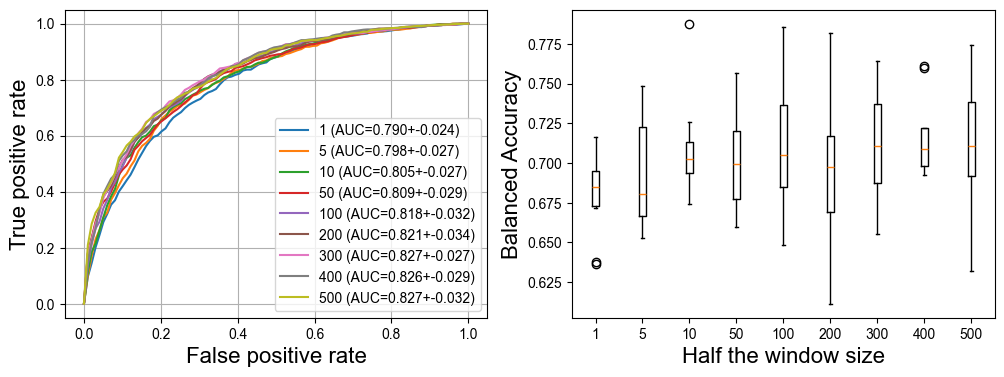

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

idx = 0
for k, v in runs2.items():
    be = [i.get_best_epoch() for i in v]
    aucs2 = main2.compute_roc2(v, ax[0], k, be)#, linestyle='-', color='k', alpha=0.2)

    # compute_pr(v, ax[1], k, be)

    # bas, _, = compute_ba(v, k, 0)
    bas, _ = compute_metric(v, k, 'ba', 'macro')
    scores_ls.append(bas)
    ax[1].boxplot(bas, positions=[idx])

    idx += 1

ax[0].set_ylabel('True positive rate', fontsize=fontsize_label)
ax[0].set_xlabel("False positive rate", fontsize=fontsize_label)
ax[0].grid()
ax[0].legend()
ax[1].set_xticklabels(runs2.keys())
ax[1].set_ylabel('Balanced Accuracy', fontsize=fontsize_label)
ax[1].set_xlabel('Half the window size', fontsize=fontsize_label)
# ax[1, 1].grid(linestyle='dashed')

# plt.suptitle("Performance with increasing window size around mutation", fontsize=18)

save_fig(fig, 'cut_sizes_final', fig_dir='.', fig_fmt='pdf', fig_size=(12, 4))

plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

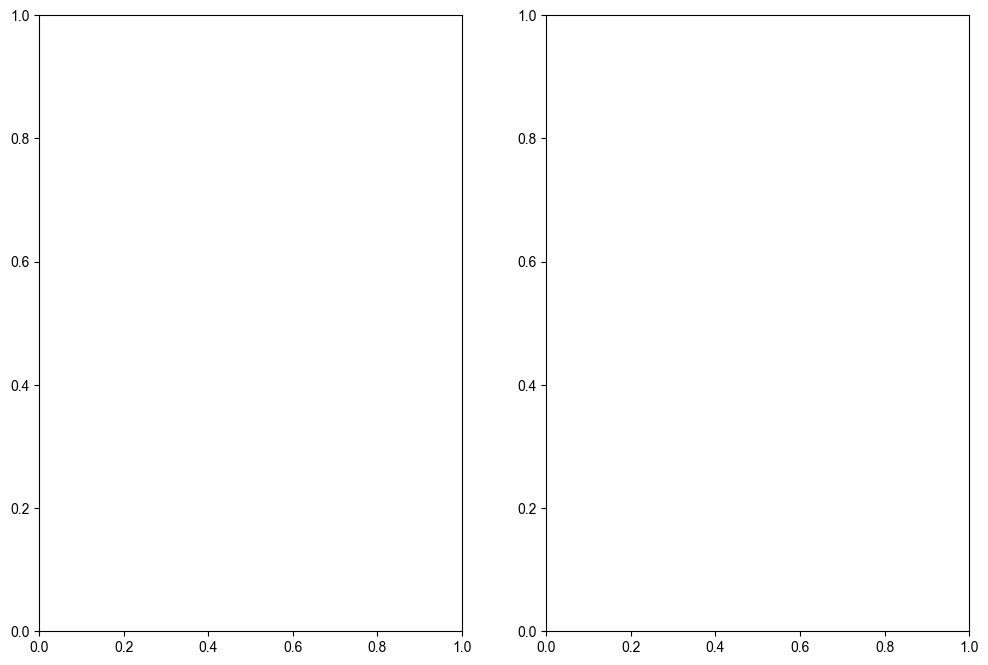

In [213]:

fig, ax = plt.subplots(2, 2, figsize=(12,8))

idx = 0
for k, v in runs.items():
    be = [i.get_best_epoch() for i in v]
    aucs2 = main2.compute_roc2(v, ax[0, 0], k, be)#, linestyle='-', color='k', alpha=0.2)

    # compute_pr(v, ax[1], k, be)

    bas, _, = compute_ba(v, k, 0)
    ax[0, 1].boxplot(bas, positions=[idx])

    idx += 1

ax[0, 0].set_title('ROC', fontsize=14)
ax[0, 0].set_ylabel('True positive rate', fontsize=fontsize_label)
# ax[0, 0].set_xlabel("False positive rate", fontsize=fontsize_label)
ax[0, 0].grid()
ax[0, 0].legend()

# ax[0, 1].grid(linestyle='dashed')
ax[0, 1].set_xticklabels(runs.keys())
ax[0, 1].set_title('F1-score', fontsize=14)
ax[0, 1].set_ylabel('F1-score (weighted)', fontsize=fontsize_label)
# ax[0, 1].set_xlabel('Half the window size', fontsize=fontsize_label)
# plt.savefig('../Figures/figure_4a.svg', bbox_inches='tight')


idx = 0
for k, v in runs2.items():
    be = [i.get_best_epoch() for i in v]
    aucs2 = main2.compute_roc2(v, ax[1, 0], k, be)#, linestyle='-', color='k', alpha=0.2)

    # compute_pr(v, ax[1], k, be)

    bas, _, = compute_ba(v, k, 0)
    ax[1, 1].boxplot(bas, positions=[idx])

    idx += 1

ax[1, 0].set_ylabel('True positive rate', fontsize=fontsize_label)
ax[1, 0].set_xlabel("False positive rate", fontsize=fontsize_label)
ax[1, 0].grid()
ax[1, 0].legend()
ax[1, 1].set_xticklabels(runs.keys())
ax[1, 1].set_ylabel('F1-score (weighted)', fontsize=fontsize_label)
ax[1, 1].set_xlabel('Half the window size', fontsize=fontsize_label)
# ax[1, 1].grid(linestyle='dashed')

plt.suptitle('How performance scales with emebdding size', fontsize=14)
# save_fig(fig, 'cut_sizes_both', fig_dir='.', fig_fmt='pdf', fig_size=(12, 8))

plt.show()

## Confidence

In [23]:
runs = {
    'ours2': 'Ablation2/esm_go2',
    'ours1': 'Ablation2/esm_bf_go',
    'ours': 'RepeatedKFold/esm_bf_go_fl',
    # 'ours': 'RepeatedKFold/esm',
    # 'ours': 'Ablation2/esm_bf',
    # 'ours': 'Ablation2/esm_bf_go_hpo',
    # 'ours': 'test',
    '(svm)mtl': 'mtl',
    # 'ours_with_hpo': 'esm_bf_hpo_go_all',
}

for k, v in runs.items():
    if '(svm)' in k:
        runs[k] = load_run(v, svm=True)
    else:
        runs[k] = load_run(v)

for k, v in runs.items():
    for e in range(len(v)):
        v[e].get_best_epoch()

> load_run :: 0.307 sec
> load_run :: 0.300 sec
> load_run :: 1.281 sec
> load_run :: 0.011 sec


In [24]:
from collections import Counter

In [25]:
def f(folds):
    epoch = 0
    count = defaultdict(int)
    for fold in folds:
        varids = fold.varids[epoch]
        for varid in varids:
            gene = varid.split('_')[0]
            count[gene] += 1
    return count

count = f(runs['ours1'])

Counter({'SCN5A': 159, 'Sh': 69, 'SCN2A': 30, 'CACNA1A': 25, 'KCNQ1': 20, 'KCNQ2': 16, 'KCND2': 13, 'KCNA2': 11, 'SCN4A': 10, 'SCN1A': 9, 'KCNQ4': 8, 'KCNH2': 8, 'SCN8A': 7, 'KCNC3': 6, 'KCNA1': 6, 'SCN10A': 5, 'KCNJ11': 5, 'HCN2': 3, 'SCN3A': 3, 'KCNJ2': 3, 'KCNA5': 3, 'KCNJ8': 2, 'KCNB1': 2, 'CACNA1C': 2, 'KCND3': 2, 'KCNJ5': 1, 'KCNH5': 1, 'KCNQ3': 1, 'KCNK17': 1, 'KCNC2': 1, 'KCNJ10': 1, 'KCNA4': 1})
Total: 434
./pdf/confidence_incorrect.pdf


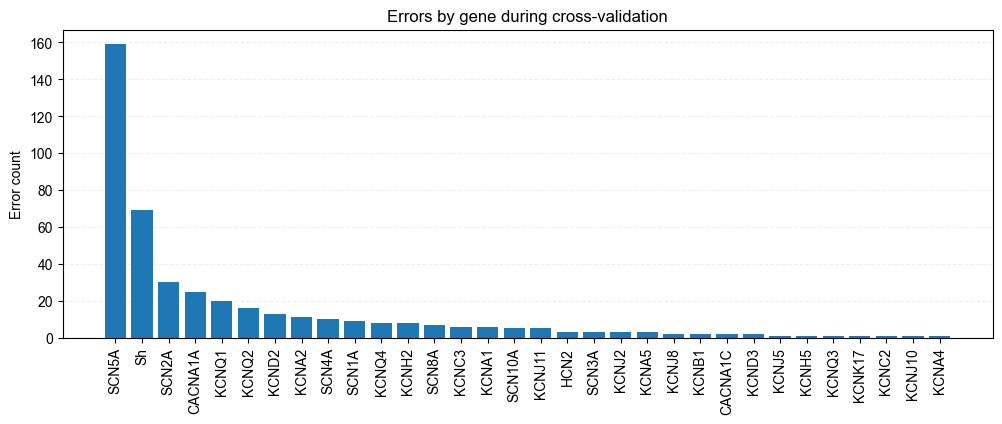

In [26]:
def count_errors(folds):
    gof_ls =[]
    lof_ls = []
    errors = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        pmax = np.argmax(p, 1)
        lmax = np.argmax(l, 1)
        for i in range(len(pmax)):
            if pmax[i] != lmax[i]:
                errors.append(fold.varids[fold.best_epoch][i].split('_')[0])
    return errors

def count_errors_by_class(folds):
    gof_ls =[]
    lof_ls = []
    errors_lof = []
    errors_gof = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        pmax = np.argmax(p, 1)
        lmax = np.argmax(l, 1)
        for i in range(len(pmax)):
            if pmax[i] != lmax[i]:
                if lmax[i] == 0:
                    errors_lof.append(fold.varids[fold.best_epoch][i].split('_')[0])
                elif lmax[i] == 1:
                    errors_gof.append(fold.varids[fold.best_epoch][i].split('_')[0])
    return errors_lof, errors_gof

errors = count_errors(runs['ours1'])
errors_count = Counter(errors)
# for k, v in errors_count.items():
#     errors_count[k] = v / count[k] * 100
print(errors_count)
print('Total:', sum(errors_count.values()))
errors_count = {k: v for k, v in sorted(errors_count.items(), key=lambda item: item[1], reverse=True)}

fig = plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(errors_count)), errors_count.values())
plt.xticks(ticks = np.arange(len(errors_count.keys())), labels = errors_count.keys(), rotation=90)
plt.ylabel('Error count')
plt.title('Errors by gene during cross-validation')
plt.grid(linestyle='dashed', alpha=0.2, axis='y')

save_fig(fig, 'confidence_incorrect', fig_dir='.', fig_fmt='pdf', fig_size=(12, 4))

plt.show()

In [27]:
errors_lof, errors_gof = count_errors_by_class(runs['ours1'])
errors_lof = Counter(errors_lof)
errors_gof = Counter(errors_gof)

print(errors_gof)
print(errors_lof)

Counter({'SCN5A': 108, 'Sh': 41, 'KCNQ1': 17, 'CACNA1A': 16, 'KCNQ2': 15, 'KCND2': 9, 'SCN1A': 9, 'KCNH2': 8, 'SCN2A': 7, 'KCNA2': 6, 'SCN4A': 6, 'KCNA1': 6, 'KCNQ4': 5, 'HCN2': 3, 'KCNC3': 3, 'KCNJ2': 3, 'SCN10A': 3, 'KCNA5': 3, 'KCNB1': 2, 'KCNJ11': 2, 'KCND3': 2, 'SCN8A': 1, 'KCNH5': 1, 'KCNK17': 1, 'SCN3A': 1, 'KCNC2': 1, 'KCNJ8': 1, 'KCNJ10': 1})
Counter({'SCN5A': 51, 'Sh': 28, 'SCN2A': 23, 'CACNA1A': 9, 'SCN8A': 6, 'KCNA2': 5, 'KCND2': 4, 'SCN4A': 4, 'KCNQ1': 3, 'KCNC3': 3, 'KCNQ4': 3, 'KCNJ11': 3, 'SCN10A': 2, 'SCN3A': 2, 'CACNA1C': 2, 'KCNJ5': 1, 'KCNQ2': 1, 'KCNJ8': 1, 'KCNQ3': 1, 'KCNA4': 1})


NameError: name 'preds_proba' is not defined

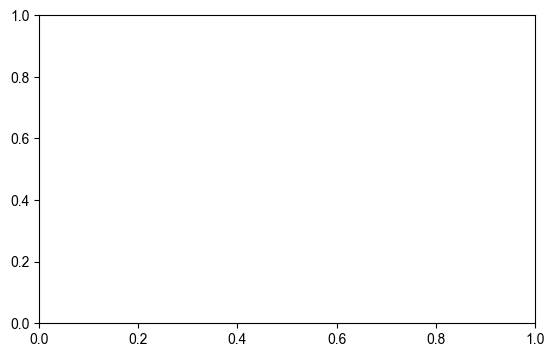

In [28]:
# preds_proba, preds, labels = confidence(runs['ours1'])

def per_class_precision(preds_proba, labels, label=0, ax=None):
    if label == 0:
        # Invert probabilities for negative class (0 as "positive")
        scores = 1 - preds_proba
        name = 'LOF'
    else:
        # Use original probabilities for positive class (1 as "positive")
        scores = preds_proba
        name = "GOF"
    
    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(labels, scores, pos_label=label)
    print('APS:', average_precision_score(labels, scores, pos_label=label))

    # plt.scatter(recall[::500], precision[::500])

    valid_idx = np.where(precision >= 0.9)[0]
    if len(valid_idx) > 0:
        idx = valid_idx[0]  # First threshold meeting criterion
        pos_threshold = thresholds[idx]
        print(f"Threshold for label {label}: {pos_threshold:.4f}")
    else:
        print(f"No threshold found for label {label} with precision >= 0.9")
        pos_threshold = None
        idx = None
    
    # if pos_threshold is not None:
    #     # The threshold corresponds to precision[idx] and recall[idx]
    #     ax.scatter([recall[idx]], [precision[idx]], color='red', zorder=5)  # Mark the point
    #     ax.annotate(f'Thresh: {pos_threshold:.2f}', 
    #                  (recall[idx], precision[idx]), 
    #                  textcoords="offset points", 
    #                  xytext=(-23, -15),  # Adjust position of text
    #                  ha='center', 
    #                  fontsize=10, 
    #                  color='black')
        
    ax.plot(recall, precision, label=f'{name}')


figsize=(6.4, 4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

per_class_precision(preds_proba, labels, 1, ax)
per_class_precision(preds_proba, labels, 0, ax)


ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.set_title(f'Precision-Recall Curve', fontsize=18)
ax.legend(loc=3)
ax.grid(True, linestyle='dashed', alpha=.3)

# save_fig(fig, '90_precision_threshold', fig_dir='.', fig_fmt='pdf', fig_size=figsize)

plt.show()

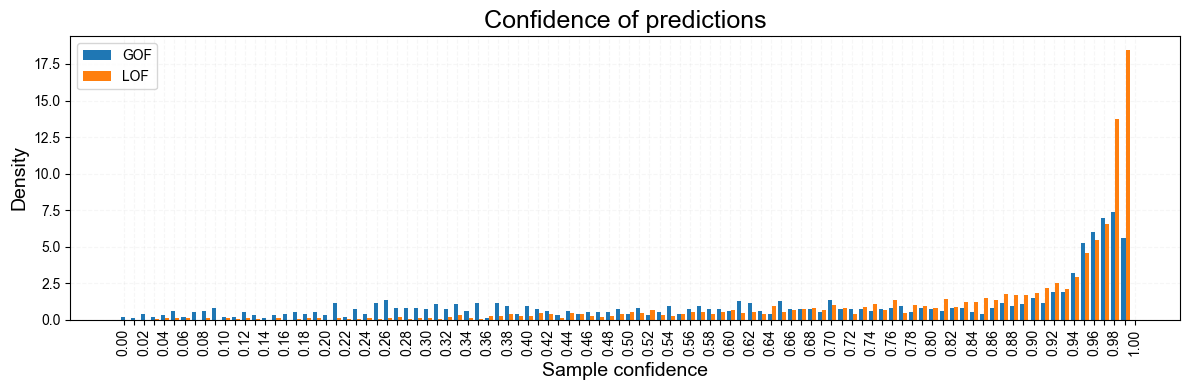

In [32]:
def confidence(folds):
    """Confidence of predictions
    With what probability did we predict the correct label
    """
    gof_ls =[]
    lof_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        lofs = p[lofs, 0]
        gofs = p[gofs, 1]
        lof_ls.extend(lofs)
        gof_ls.extend(gofs)
    return gof_ls, lof_ls


gof_ls, lof_ls = confidence(runs['ours1'])

bins = np.linspace(0, 1, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Midpoints for plotting


# Compute histograms
gof_hist, _ = np.histogram(gof_ls, bins=bins)
lof_hist, _ = np.histogram(lof_ls, bins=bins)

# Normalize to percentages
# gof_hist = gof_hist / gof_hist.sum() * 100
# lof_hist = lof_hist / lof_hist.sum() * 100

## Density
gof_hist = gof_hist / (sum(gof_hist) * np.diff(bins))
lof_hist = lof_hist / (sum(lof_hist) * np.diff(bins))

# gof_hist = np.log10(gof_hist)
# lof_hist = np.log10(lof_hist)

# Bar width
width = (bins[1] - bins[0]) * 0.4  # Adjust for side-by-side effect

# Plot
fig_size=(6.4, 4)
fig_size=(12, 4)
fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
rect_gof = ax.bar(bin_centers - width / 2, gof_hist, width=width, label='GOF', alpha=1)
rect_lof = ax.bar(bin_centers + width / 2, lof_hist, width=width, label='LOF', alpha=1)

# plt.xticks(bins, labels=[f"{b:.2f}" for b in bins], rotation=45, ha='right')
ax.set_xticks(bins+width)
# ax.set_xticklabels([f"{b:.2f}" for b in bins], ha='center', fontsize=10)
ax.set_xticklabels([f"{b:.2f}" if (k % 2 == 0) else "" for k, b in enumerate(bins) ], ha='center', fontsize=10)
ax.tick_params(axis='x', rotation=90)

ax.grid(linestyle='dashed', alpha=0.1)
ax.set_title('Confidence of predictions', fontsize=18)
ax.set_xlabel('Sample confidence', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
# ax.set_ylabel("log$_{10}$(count)", fontsize=14)
ax.legend()

# save_fig(fig, 'confidence', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

gof_values_100 = rect_gof.datavalues
lof_values_100 = rect_lof.datavalues

plt.show()

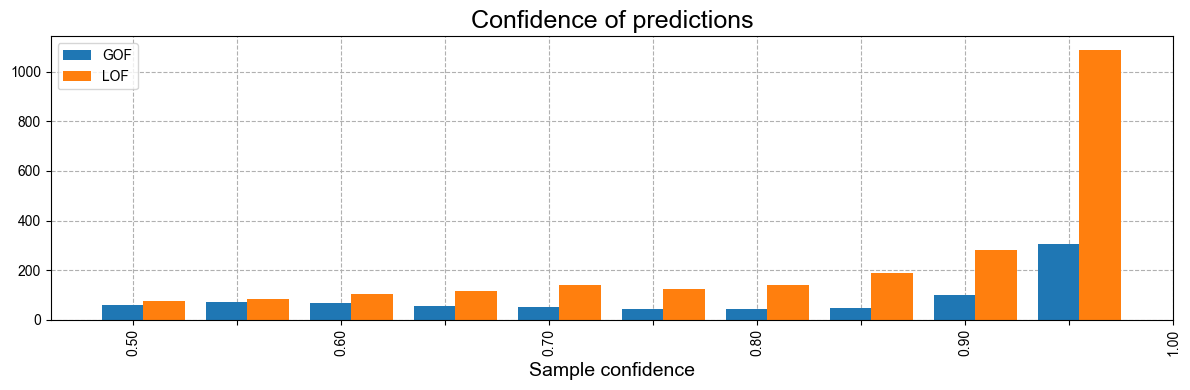

In [33]:
def confidenceA(folds):
    gof_ls =[]
    lof_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        pmax = np.argmax(p, 1)
        lmax = np.argmax(l, 1)
        for i in range(len(pmax)):
            # IF incorrect
            if pmax[i] != lmax[i]:
                # IF predicted GOF
                if pmax[i] == 1:
                    # STORE gof prediction confidence
                    gof_ls.append(p[i, 1])
                else:
                    lof_ls.append(p[i, 0])

    #     lofs = p[lofs, 0]
    #     gofs = p[gofs, 1]
    #     lof_ls.extend(lofs)
    #     gof_ls.extend(gofs)
    return gof_ls, lof_ls

def extract_gof(folds):
    """Extract GOF probabilities and labels"""
    preds_proba = [] # GOF probability
    labels = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.get_best_epoch()]
        l = fold.labels[fold.best_epoch]
        preds_proba.extend(p[:, 1])
        labels.extend(l[:, 1])

    preds_proba = np.array(preds_proba)
    labels = np.array(labels)
    preds = (preds_proba > 0.5).astype(int)

    return preds_proba, preds, labels


preds_proba, preds, labels = extract_gof(runs['ours1'])

# What is our confidence for LOF predictions
lof_confidence = np.where((preds == 0))[0]# & (labels == 0))[0]
lof_confidence = 1 - preds_proba[lof_confidence]

# What is our confidence for GOF predictions
gof_confidence = np.where((preds == 1))[0]# & (labels == 1))[0]
gof_confidence = preds_proba[gof_confidence]


# What is our confidence in our prediction when WRONG
wrong_lof_confidence = np.where((preds == 0) & (labels == 1))[0]
wrong_lof_confidence = 1 - preds_proba[wrong_lof_confidence]

# What is our confidence in our prediction when WRONG
wrong_gof_confidence = np.where((preds == 1) & (labels == 0))[0]
wrong_gof_confidence = preds_proba[wrong_gof_confidence]


# bins = np.linspace(0.5, 1, 21)
bins = np.linspace(0.5, 1, 11)
# bins = np.linspace(0.5, 1, 51)
# bins = np.linspace(0.5, 1, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2  # Midpoints for plotting


# Compute histograms
gof_hist, _ = np.histogram(gof_confidence, bins=bins)
lof_hist, _ = np.histogram(lof_confidence, bins=bins)

# gof_hist = gof_hist / gof_values
# lof_hist = lof_values / lof_values

# Normalize to percentages
# gof_hist = gof_hist / gof_hist.sum() * 100
# lof_hist = lof_hist / lof_hist.sum() * 100

# gof_hist = np.log10(gof_hist + 1)
# lof_hist = np.log10(lof_hist + 1)

# Bar width
width = (bins[1] - bins[0]) * 0.4  # Adjust for side-by-side effect

# Plot
fig_size=(12, 4)
fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
ax.bar(bin_centers - width / 2, gof_hist, width=width, label='GOF', alpha=1)
ax.bar(bin_centers + width / 2, lof_hist, width=width, label='LOF', alpha=1)

# plt.xticks(bins, labels=[f"{b:.2f}" for b in bins], rotation=45, ha='right')
ax.set_xticks(bins+width)
# ax.set_xticklabels([f"{b:.2f}" for b in bins], ha='center', fontsize=10)
ax.set_xticklabels([f"{b:.2f}" if (k % 2 == 0) else "" for k, b in enumerate(bins) ], ha='center', fontsize=10)
ax.tick_params(axis='x', rotation=90)

ax.grid(linestyle='dashed')
ax.set_title('Confidence of predictions', fontsize=18)
ax.set_xlabel('Sample confidence', fontsize=14)
# ax.set_ylabel('Percentage (%)', fontsize=14)
# ax.set_ylabel("log$_{10}$(count)", fontsize=14)
ax.legend()

# save_fig(fig, 'confidence_incorrect', fig_dir='.', fig_fmt='pdf', fig_size=(6.4, 4))

gof_values = gof_hist
lof_values = lof_hist

plt.show()

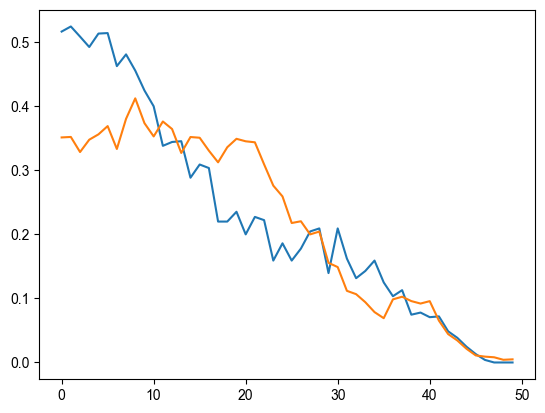

In [34]:

def windowed_conf(hist, w = 0.05):
    hist = np.array(sorted(hist))
    l = len(hist)
    start = 0.5
    end = start + w
    counts = []
    while start < 1.0:
        c = hist[np.where((hist >= start) & (hist < end))[0]]
        counts.append(len(c))
        start += 0.01
        end = start + w
    # plt.plot(np.linspace(0, 1, len(counts)), counts)
    return np.array(counts)

gof_c = windowed_conf(gof_confidence)
wrong_gof_c = windowed_conf(wrong_gof_confidence)
lof_c = windowed_conf(lof_confidence)
wrong_lof_c = windowed_conf(wrong_lof_confidence)

plt.plot(wrong_gof_c/gof_c)
plt.plot(wrong_lof_c/lof_c)
plt.show()

In [35]:
bin_centers

array([0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925,
       0.975])

./pdf/confidence_2_final.pdf


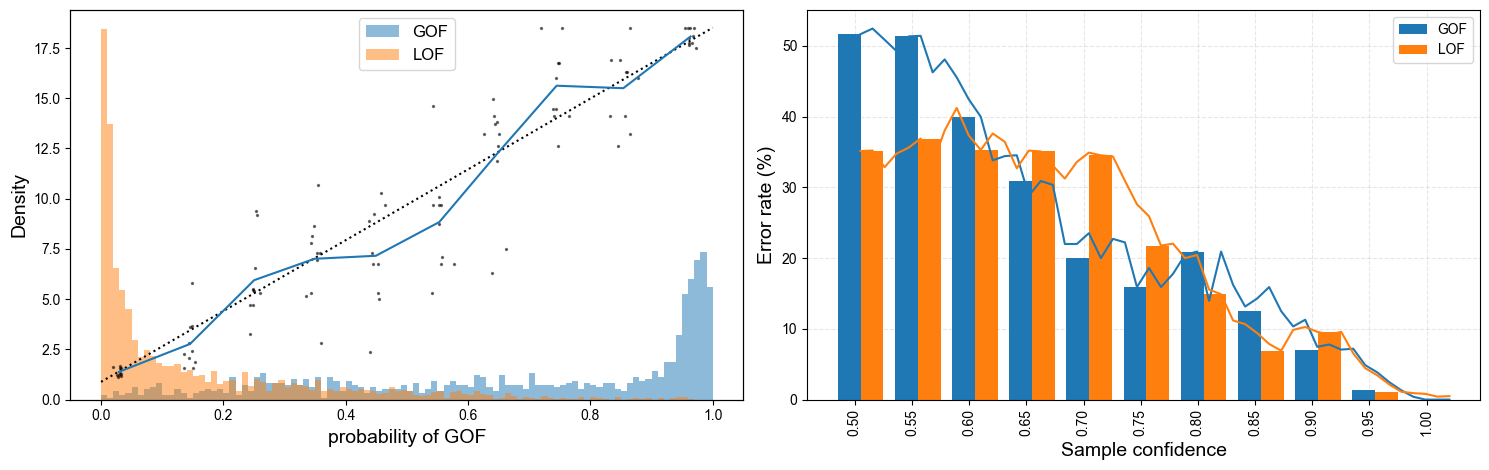

In [40]:
# Compute histograms
gof_hist, _ = np.histogram(wrong_gof_confidence, bins=bins)
lof_hist, _ = np.histogram(wrong_lof_confidence, bins=bins)

gof_hist = (gof_hist / gof_values) * 100
lof_hist = (lof_hist / lof_values) * 100

fig_size=(15, 4.8)
fig, ax = plt.subplots(1, 2, figsize=fig_size, tight_layout=True)
ax0 = ax[1]
ax0.bar(bin_centers - width / 2, gof_hist, width=width, label='GOF', alpha=1)
ax0.bar(bin_centers + width / 2, lof_hist, width=width, label='LOF', alpha=1)

# ax0.plot(bins[:-1], r_gof)
# ax0.plot(bins[:-1], r_lof)

ax0.set_xticks(bins+width)
ax0.set_xticklabels([f"{b:.2f}" for k, b in enumerate(bins) ], ha='center', fontsize=10)
# ax0.set_xticklabels(bins, ha='center', fontsize=10)
ax0.tick_params(axis='x', rotation=90)

# ax0_1 = ax0.twiny()
ax0.plot(np.linspace(0.525, 1.04, len(wrong_gof_c)), wrong_gof_c/gof_c * 100)
ax0.plot(np.linspace(0.525, 1.04, len(wrong_lof_c)), wrong_lof_c/lof_c * 100)

ax0.grid(linestyle='dashed', alpha=0.3)
# ax0.set_title('Confidence of incorrect predictions', fontsize=18)
# ax0.set_title('Error-rate of predictions at different confidence levels', fontsize=18)
ax0.set_xlabel('Sample confidence', fontsize=14)
ax0.set_ylabel('Error rate (%)', fontsize=14)
ax0.legend()


############### Real vs Confidence

ax1 = ax[0]

def real_vs_confidence(folds: list[Fold]):
    gof_ls =[]
    lof_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        lofs = p[lofs, 0]
        gofs = p[gofs, 1]
        lof_ls.extend(lofs)
        gof_ls.extend(gofs)
    return gof_ls, lof_ls


gof_ls, lof_ls = real_vs_confidence(runs['ours1'])

noise = gof_ls
density1 = stats.gaussian_kde(noise)
n, x1, _ = ax1.hist(noise, bins=np.linspace(0, 1, 101), 
                   histtype='bar', alpha=0.5, density=True, stacked=True, label='GOF')  


noise = 1 - np.array(lof_ls)
density2 = stats.gaussian_kde(noise)
n, x2, _ = ax1.hist(noise, bins=np.linspace(0, 1, 101), 
                   histtype='bar', alpha=0.5, density=True, stacked=True, label="LOF")
# ax[1].clear()

# plt.figure()
# ax1.plot(x1, density1(x1), color='blue', label='GOF', alpha=1)
# ax1.plot(x2, density2(x1), color='darkorange', label='LOF', alpha=1)


# ax1.set_title("Prediction confidence coloured by ground truth", fontsize=fontsize_title)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel('probability of GOF', fontsize=14)
ax1.legend(fontsize=fontsize_legend, loc=9)


############### Calibration curve

def compute_calibration(folds: list[Fold]):
    prob_true_ls = []
    prob_pred_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]

        prob_true, prob_pred = calibration_curve(np.argmax(l, 1), p[:, 1], pos_label=1, n_bins=10)
        prob_true_ls.append(prob_true)
        prob_pred_ls.append(prob_pred)

    return prob_true_ls, prob_pred_ls

a, b = compute_calibration(runs['ours1'])

ax1_1 = ax1.twinx()
ax1_1.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), linestyle=':', color='k', label='Perfect')

ax1_1.set_yticks([])

for i in range(len(a)):
    # ax1_1.plot(a[i], b[i], color='k', alpha=0.03, linestyle='-')
    ax1_1.scatter(b[i], a[i], color='k', alpha=0.5, s=2)
# ax1_1.plot(np.mean(a, 0), np.mean(b, 0), label='Ours')
# ax1_1.set_ylim([-0.05, 1.3])
# ax1_1.set_ylabel('Fraction of positives (Positive class: GOF)')
# ax1_1.set_xlabel('Mean predicted probability (Positive class: GOF)')

a = np.array(a)
b = np.array(b)
# ax1_1.errorbar(np.mean(b, 0), np.mean(a, 0), 
#              np.std(a, 0), np.std(b, 0), 
#              linestyle='-')
ax1_1.plot(np.mean(b, 0), np.mean(a, 0))

################# 90% precision threshold

# ax = ax[2]
# per_class_precision(preds_proba, labels, 1, ax)
# per_class_precision(preds_proba, labels, 0, ax)

# ax.set_xlabel('Recall', fontsize=14)
# ax.set_ylabel('Precision', fontsize=14)
# ax.set_title(f'Precision-Recall Curve', fontsize=18)
# ax.legend(loc=3)
# ax.grid(linestyle='dashed', alpha=.3)

save_fig(fig, 'confidence_2_final', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

plt.show()

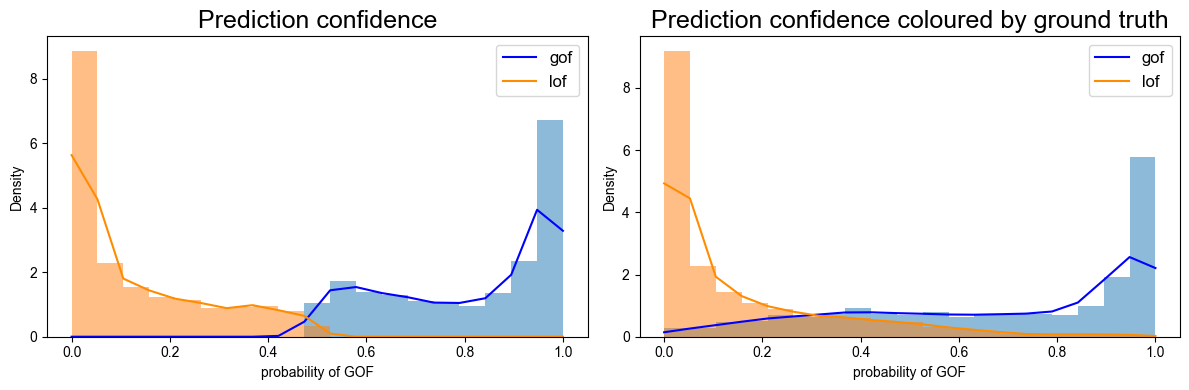

In [901]:
def confidence(folds: list[Fold], svm=False):
    gof_ls =[]
    lof_ls = []
    for i, fold in enumerate(folds):
        if not svm:
            p = fold.preds[fold.best_epoch]
            l = fold.labels[fold.best_epoch]
    
            lofs = np.where(p[:,0] > p[:, 1])[0]
            gofs = np.where(p[:,0] <= p[:, 1])[0]
    
            lofs = p[lofs, 0]
            gofs = p[gofs, 1]
        else:
            p = fold.preds[0]
            l = fold.preds[0]
            
            lofs = np.where(p < 0)[0]
            gofs = np.where(p >= 0)[0]
            lofs = p[lofs]
            gofs = p[gofs]
            
        lof_ls.extend(lofs)
        gof_ls.extend(gofs)
    return gof_ls, lof_ls


def real_vs_confidence(folds: list[Fold]):
    gof_ls =[]
    lof_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]
        lofs = np.where(l[:, 0] == 1)[0]
        gofs = np.where(l[:, 1] == 1)[0]

        lofs = p[lofs, 0]
        gofs = p[gofs, 1]
        lof_ls.extend(lofs)
        gof_ls.extend(gofs)
    return gof_ls, lof_ls


gof_ls, lof_ls = confidence(runs['ours'], False)

# plt.hist(gof_ls)
# plt.hist(1 - np.array(lof_ls))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
noise = gof_ls
density1 = stats.gaussian_kde(noise)
n, x1, _ = ax[0].hist(noise, bins=np.linspace(0, 1, 20), 
                   histtype='stepfilled', alpha=0.5, density=True)  


noise = 1 - np.array(lof_ls)
density2 = stats.gaussian_kde(noise)
n, x2, _ = ax[0].hist(noise, bins=np.linspace(0, 1, 20), 
                   histtype='stepfilled', alpha=0.5, density=True)
# ax[0].clear()

# plt.figure()
ax[0].plot(x1, density1(x1), color='blue', label='gof')
ax[0].plot(x2, density2(x1), color='darkorange', label='lof')


ax[0].set_title('Prediction confidence', fontsize=fontsize_title)
ax[0].legend(fontsize=fontsize_legend)

ax[0].set_ylabel('Density')
ax[0].set_xlabel('probability of GOF')



gof_ls, lof_ls = real_vs_confidence(runs['ours'])

noise = gof_ls
density1 = stats.gaussian_kde(noise)
n, x1, _ = ax[1].hist(noise, bins=np.linspace(0, 1, 20), 
                   histtype='stepfilled', alpha=0.5, density=True)  


noise = 1 - np.array(lof_ls)
density2 = stats.gaussian_kde(noise)
n, x2, _ = ax[1].hist(noise, bins=np.linspace(0, 1, 20), 
                   histtype='stepfilled', alpha=0.5, density=True)
# ax[1].clear()

# plt.figure()
ax[1].plot(x1, density1(x1), color='blue', label='gof', alpha=1)
ax[1].plot(x2, density2(x1), color='darkorange', label='lof', alpha=1)


ax[1].set_title("Prediction confidence coloured by ground truth", fontsize=fontsize_title)
ax[1].set_ylabel('Density')
ax[1].set_xlabel('probability of GOF')
ax[1].legend(fontsize=fontsize_legend)


plt.tight_layout()

# plt.savefig('../Figures/figure_3_confidence.png', bbox_inches='tight')

plt.show()

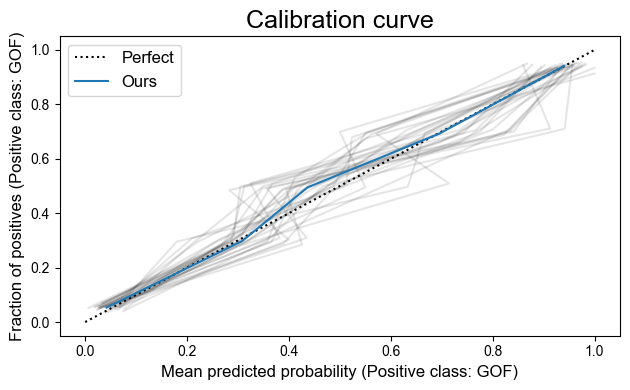

In [1907]:
def compute_calibration(folds: list[Fold]):
    prob_true_ls = []
    prob_pred_ls = []
    for i, fold in enumerate(folds):
        p = fold.preds[fold.best_epoch]
        l = fold.labels[fold.best_epoch]

        prob_true, prob_pred = calibration_curve(np.argmax(l, 1), p[:, 1])
        prob_true_ls.append(prob_true)
        prob_pred_ls.append(prob_pred)

    return prob_true_ls, prob_pred_ls

a, b = compute_calibration(runs['ours'])

fig_size = (6.4, 4.0)
fig = plt.figure(figsize=fig_size, tight_layout=True)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), linestyle=':', color='k', label='Perfect')

for i in range(len(a)):
    plt.plot(a[i], b[i], color='k', alpha=0.1)
plt.plot(np.mean(a, 0), np.mean(b, 0), label='Ours')
plt.xlabel('Mean predicted probability (Positive class: GOF)', fontsize=12)
plt.ylabel('Fraction of positives (Positive class: GOF)', fontsize=12)
plt.title('Calibration curve', fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
# plt.grid(linestyle='dashed')

# save_fig(fig, 'calibration_curve', fig_dir='.', fig_fmt='pdf', fig_size=fig_size)

plt.show()